# Comments
Both GHGRP (https://www.epa.gov/ghgemissions/understanding-global-warming-potentials) and CLIMATE TRACE report a GWP of 100 years. These will be compared

# Library imports

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import statsmodels.api as sm
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
import http.client
import json
import os
from scipy.spatial import cKDTree
from fuzzywuzzy import fuzz, process
from tqdm import tqdm
from pandas.core.indexes.base import InvalidIndexError
import re
import plotly.express as px
from geopy.distance import geodesic
from sklearn.neighbors import BallTree
from difflib import SequenceMatcher
import pickle
import itertools

# Loading GHGRP FLIGHT data

In [ ]:
# Load and preprocess data for all available years

# Load GHGRP Data
# Define the folder where CSV files are stored
data_folder = "data/"

# Load GHGRP Data
ghgrp_files = {
    year: os.path.join(data_folder, f"flight_{year}.csv")
    for year in range(2015, 2023)  # Change range if needed
}

ghgrp_data = []

# Load each file, preprocess, and combine
for year, file_path in ghgrp_files.items():
    try:
        df = pd.read_csv(file_path, delimiter=";")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        continue
    except pd.errors.ParserError:
        print(f"Parsing error in file: {file_path}")
        continue

    # Ensure 'YEAR' is of integer type
    df['REPORTING YEAR'] = pd.to_numeric(df['REPORTING YEAR'], errors='coerce').astype('Int64')

    # Convert LATITUDE and LONGITUDE to Numeric Format
    df['LATITUDE'] = df['LATITUDE'].astype(str).str.replace(',', '.')
    df['LONGITUDE'] = df['LONGITUDE'].astype(str).str.replace(',', '.')
    df['LATITUDE'] = pd.to_numeric(df['LATITUDE'], errors='coerce')
    df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'], errors='coerce')

    # Append the dataframe to the list
    ghgrp_data.append(df)

# Combine all years into a single DataFrame
ghgrp_combined = pd.concat(ghgrp_data, ignore_index=True)

# Create a COORDINATE column
ghgrp_combined['ghgrp_coordinate'] = list(zip(ghgrp_combined['LATITUDE'], ghgrp_combined['LONGITUDE']))

# Rename columns for clarity
ghgrp_combined = ghgrp_combined.rename(columns={
    'REPORTING YEAR': 'ghgrp_year',
    'FACILITY NAME': 'ghgrp_facility_name',
    'GHGRP ID': 'ghgrp_id',
    'REPORTED ADDRESS': 'ghgrp_reported_address',
    'LATITUDE': 'ghgrp_latitude',
    'LONGITUDE': 'ghgrp_longitude',
    'ghgrp_coordinate': 'ghgrp_coordinate',
    'CITY NAME': 'ghgrp_city_name',
    'STATE NAME': 'ghgrp_state_name',
    'ZIP CODE': 'ghgrp_zip_code',
    'COUNTY NAME': 'ghgrp_county_name',
    'PARENT COMPANIES': 'ghgrp_parent_companies',
    'GHG QUANTITY (METRIC TONS CO2e)': 'ghgrp_emissions_tons',
    'SUBPARTS': 'ghgrp_subparts',
    'STATE': 'ghgrp_STATE'
})

In [ ]:
# Rename ghgrp_subparts for clarity
# Mapping short codes to official definitions
subpart_mapping = {
    'AA': 'Pulp and Paper Manufacturing',
    'BB': 'Silicon Carbide Production',
    'C': 'General Stationary Fuel Combustion Sources',
    'D': 'Electricity Generation',
    'E': 'Adipic Acid Production',
    'F': 'Aluminum Production',
    'FF': 'Underground Coal Mines',
    'G': 'Ammonia Manufacturing',
    'H': 'Cement Production',
    'HH': 'Municipal Solid Waste Landfills',
    'I': 'Electronics Manufacturing',
    'II': 'Industrial Wastewater Treatment',
    'K': 'Ferroalloy Production',
    'L': 'Fluorinated Gas Production',
    'MM': 'Suppliers of Petroleum Products',
    'N': 'Glass Production',
    'NN': 'Suppliers of Natural Gas and Natural Gas Liquids',
    'O': 'HCFC-22 Production and HFC-23 Destruction',
    'OO': 'Suppliers of Industrial Greenhouse Gases',
    'P': 'Hydrogen Production',
    'PP': 'Suppliers of Carbon Dioxide',
    'Q': 'Iron and Steel Production',
    'QQ': 'Importers and Exporters of Equipment Pre-Charged with Fluorinated GHGs or Containing Fluorinated GHGs in Closed-Cell Foams',
    'R': 'Lead Production',
    'RR (RPT)': 'Geologic Sequestration of Carbon Dioxide',
    'S': 'Lime Manufacturing',
    'SS': 'Manufacture of Electric Transmission and Distribution Equipment',
    'T': 'Magnesium Production',
    'TT': 'Industrial Waste Landfills',
    'U': 'Miscellaneous Uses of Carbonate',
    'UU': 'Injection of Carbon Dioxide',
    'V': 'Nitric Acid Production',
    'W': 'Petroleum and Natural Gas Systems',
    'X': 'Petrochemical Production',
    'Y': 'Petroleum Refineries',
    'Z': 'Phosphoric Acid Production',
    'GG': 'Zinc Production',
    'CC': 'Soda Ash Manufacturing',
    'EE': 'Titanium Dioxide Production',
    'LL': 'Suppliers of Coal-based Liquid Fuels',
    'DD': 'Use of Electric Transmission and Distribution Equipment'
}

# Function to replace short codes with descriptive names
def replace_codes_with_descriptive_names(value):
    # Split the value by commas, map each code to its descriptive name, and join them back
    return ', '.join([subpart_mapping.get(code.strip(), code) for code in value.split(',')])

# Apply the function to the `ghgrp_subparts` column
ghgrp_combined['ghgrp_subparts'] = ghgrp_combined['ghgrp_subparts'].apply(replace_codes_with_descriptive_names)

In [ ]:
# Check for proper year coverage
year_coverage = ghgrp_combined['ghgrp_year'].value_counts().sort_index()
print(f"Year coverage:\n{year_coverage}")

Year coverage:
ghgrp_year
2015    7983
2016    7643
2017    7569
2018    7676
2019    7683
2020    7643
2021    7615
2022    7546
Name: count, dtype: Int64


In [ ]:
# Display basic info to ensure data loaded correctly
display(ghgrp_combined.head())

ghgrp_year                       ghgrp_facility_name  ghgrp_id  \
0        2015  #540 BONANZA CREEK ENERGY - DENVER BASIN   1000355   
1        2015            121 REGIONAL DISPOSAL FACILITY   1004377   
2        2015                         15-18565/15-18662   1010040   
3        2015                                  15-19015   1010085   
4        2015                            220 Gulf Coast   1009263   

        ghgrp_reported_address  ghgrp_latitude  ghgrp_longitude  \
0  410 17th Street, Suite 1500       39.744310      -104.988580   
1     3820 SAM RAYBURN HIGHWAY       33.298570       -96.535860   
2              1021 Tori Drive       37.274127       -83.239034   
3            1845 S. KY HWY 15       37.236617       -83.181260   
4          701 Cedar Lake Blvd       35.567190       -97.498270   

  ghgrp_city_name ghgrp_county_name ghgrp_STATE  ghgrp_zip_code  \
0          Denver               NaN          CO           80202   
1         MELISSA     COLLIN COUNTY          TX           75454   
2          Hazard      PERRY COUNTY          KY           40701   
3          Hazard      PERRY COUNTY          KY           41701   
4   Oklahoma City   OKLAHOMA COUNTY          OK           73114   

                        ghgrp_parent_companies  ghgrp_emissions_tons  \
0              BONANZA CREEK ENERGY INC (100%)                354851   
1  NORTH TEXAS MUNICIPAL WATER DISTRICT (100%)                199012   
2                     CAMBRIAN COAL LLC (100%)                118205   
3                     CAMBRIAN COAL LLC (100%)                 55873   
4                  CHAPARRAL ENERGY INC (100%)                  4448   

                      ghgrp_subparts         ghgrp_coordinate  
0  Petroleum and Natural Gas Systems   (39.74431, -104.98858)  
1    Municipal Solid Waste Landfills    (33.29857, -96.53586)  
2             Underground Coal Mines  (37.274127, -83.239034)  
3             Underground Coal Mines   (37.236617, -83.18126)  
4  Petroleum and Natural Gas Systems    (35.56719, -97.49827)

## Check for missing or duplicate values

In [ ]:
# Check for duplicate rows in the DataFrame
duplicate_rows = ghgrp_combined.duplicated()
num_duplicates = duplicate_rows.sum()

print(f"Number of duplicate rows: {num_duplicates}")
# Display duplicate rows if there are any
if num_duplicates > 0:
    display(ghgrp_combined[duplicate_rows])
else:
    print("No duplicate rows found.")

Number of duplicate rows: 0
No duplicate rows found.


In [ ]:
# Calculate the percentage of null values in each column
null_percentage = ghgrp_combined.isnull().mean() * 100
null_percentage_sorted = null_percentage.sort_values(ascending=False)

# Display the results
print("Percentage of null values in each column (sorted descending):")
display(null_percentage_sorted)

Percentage of null values in each column (sorted descending):


ghgrp_county_name         9.617328
ghgrp_reported_address    6.804329
ghgrp_parent_companies    0.399296
ghgrp_year                0.000000
ghgrp_facility_name       0.000000
ghgrp_id                  0.000000
ghgrp_latitude            0.000000
ghgrp_longitude           0.000000
ghgrp_city_name           0.000000
ghgrp_STATE               0.000000
ghgrp_zip_code            0.000000
ghgrp_emissions_tons      0.000000
ghgrp_subparts            0.000000
ghgrp_coordinate          0.000000
dtype: float64

No missing values in any of the key columns

## Check if ghgrp_id is stable

In [ ]:
# Group by 'ghgrp_facility_name' and 'ghgrp_coordinate' to count unique 'ghgrp_id's
ghgrp_id_stability = ghgrp_combined.groupby(['ghgrp_facility_name', 'ghgrp_coordinate'])['ghgrp_id'].nunique().reset_index()

# Filter combinations where 'ghgrp_id' count is greater than 1 (unstable)
unstable_ghgrp_ids = ghgrp_id_stability[ghgrp_id_stability['ghgrp_id'] > 1]

# Display the results
print(f"Total (ghgrp_facility_name, ghgrp_coordinate) combinations: {ghgrp_id_stability.shape[0]}")
print(f"Number of unstable combinations (multiple GHGRP IDs): {unstable_ghgrp_ids.shape[0]}")

if not unstable_ghgrp_ids.empty:
    print("\nSample of unstable (ghgrp_facility_name, ghgrp_coordinate) combinations:")
    display(unstable_ghgrp_ids.head(10))
else:
    print("All GHGRP IDs are stable for each (ghgrp_facility_name, ghgrp_coordinate) combination.")

Total (ghgrp_facility_name, ghgrp_coordinate) combinations: 10309
Number of unstable combinations (multiple GHGRP IDs): 0
All GHGRP IDs are stable for each (ghgrp_facility_name, ghgrp_coordinate) combination.


## Check if ghgrp_facility_name is stable

In [ ]:
# Group by 'ghgrp_id' and 'ghgrp_coordinate' to count unique 'ghgrp_facility_name's
facility_name_stability = ghgrp_combined.groupby(['ghgrp_id', 'ghgrp_coordinate'])['ghgrp_facility_name'].nunique().reset_index()

# Filter combinations where 'ghgrp_facility_name' count is greater than 1 (unstable)
unstable_facility_names = facility_name_stability[facility_name_stability['ghgrp_facility_name'] > 1]

# Display the results
print(f"Total (ghgrp_id, ghgrp_coordinate) combinations: {facility_name_stability.shape[0]}")
print(f"Number of unstable combinations (multiple ghgrp_facility_name): {unstable_facility_names.shape[0]}")

if not unstable_facility_names.empty:
    print("\nSample of unstable (ghgrp_id, ghgrp_coordinate) combinations:")
    display(unstable_facility_names.head(10))
else:
    print("All ghgrp_facility_name are stable for each (ghgrp_id, ghgrp_coordinate) combination.")

Total (ghgrp_id, ghgrp_coordinate) combinations: 10156
Number of unstable combinations (multiple ghgrp_facility_name): 153

Sample of unstable (ghgrp_id, ghgrp_coordinate) combinations:


ghgrp_id         ghgrp_coordinate  ghgrp_facility_name
28     1000032  (39.281072, -81.637901)                    2
220    1000255      (29.8169, -95.1086)                    2
286    1000334      (39.8466, -88.9261)                    2
304    1000355   (39.74431, -104.98858)                    2
335    1000401      (35.7433, -84.3208)                    2
580    1000704     (36.0441, -79.78814)                    2
661    1000811      (32.2792, -81.2842)                    2
662    1000812      (33.5883, -85.9731)                    2
1023   1001262      (40.2128, -75.3022)                    2
1050   1001292      (42.8543, -88.7297)                    2

In [ ]:
display(ghgrp_combined[ghgrp_combined['ghgrp_id'].astype(str).str.strip() == '1000032'])

ghgrp_year      ghgrp_facility_name  ghgrp_id ghgrp_reported_address  \
3879         2015  KRATON POLYMERS U S LLC   1000032   2419 State Route 618   
11750        2016       KRATON Corporation   1000032   2419 State Route 618   
19375        2017       KRATON Corporation   1000032   2419 State Route 618   
26980        2018       KRATON Corporation   1000032   2419 State Route 618   
34654        2019       KRATON Corporation   1000032   2419 State Route 618   
42318        2020       KRATON Corporation   1000032   2419 State Route 618   
49948        2021       KRATON Corporation   1000032   2419 State Route 618   
57525        2022       KRATON Corporation   1000032   2419 State Route 618   

       ghgrp_latitude  ghgrp_longitude ghgrp_city_name  ghgrp_county_name  \
3879        39.281072       -81.637901          BELPRE  WASHINGTON COUNTY   
11750       39.281072       -81.637901          BELPRE  WASHINGTON COUNTY   
19375       39.281072       -81.637901          BELPRE  WASHINGTON COUNTY   
26980       39.281072       -81.637901          BELPRE  WASHINGTON COUNTY   
34654       39.281072       -81.637901          BELPRE  WASHINGTON COUNTY   
42318       39.281072       -81.637901          BELPRE  WASHINGTON COUNTY   
49948       39.281072       -81.637901          BELPRE  WASHINGTON COUNTY   
57525       39.281072       -81.637901          BELPRE  WASHINGTON COUNTY   

      ghgrp_STATE  ghgrp_zip_code         ghgrp_parent_companies  \
3879           OH           45714  KRATON POLYMERS US LLC (100%)   
11750          OH           45714  KRATON POLYMERS US LLC (100%)   
19375          OH           45714  KRATON POLYMERS US LLC (100%)   
26980          OH           45714  KRATON POLYMERS US LLC (100%)   
34654          OH           45714  KRATON CHEMICAL CO LLC (100%)   
42318          OH           45714             KRATON CORP (100%)   
49948          OH           45714             KRATON CORP (100%)   
57525          OH           45714             KRATON CORP (100%)   

       ghgrp_emissions_tons                              ghgrp_subparts  \
3879                 258889  General Stationary Fuel Combustion Sources   
11750                206772  General Stationary Fuel Combustion Sources   
19375                206088  General Stationary Fuel Combustion Sources   
26980                214694  General Stationary Fuel Combustion Sources   
34654                206496  General Stationary Fuel Combustion Sources   
42318                205850  General Stationary Fuel Combustion Sources   
49948                209306  General Stationary Fuel Combustion Sources   
57525                208475  General Stationary Fuel Combustion Sources   

              ghgrp_coordinate  
3879   (39.281072, -81.637901)  
11750  (39.281072, -81.637901)  
19375  (39.281072, -81.637901)  
26980  (39.281072, -81.637901)  
34654  (39.281072, -81.637901)  
42318  (39.281072, -81.637901)  
49948  (39.281072, -81.637901)  
57525  (39.281072, -81.637901)

In [ ]:
display(ghgrp_combined[ghgrp_combined['ghgrp_id'].astype(str).str.strip() == '1000255'])

ghgrp_year               ghgrp_facility_name  ghgrp_id  \
5295         2015    Optim Energy Altura Cogen, LLC   1000255   
13087        2016  Odyssey Energy Altura Cogen, LLC   1000255   
20678        2017  Odyssey Energy Altura Cogen, LLC   1000255   
28314        2018  Odyssey Energy Altura Cogen, LLC   1000255   
35989        2019  Odyssey Energy Altura Cogen, LLC   1000255   
43656        2020  Odyssey Energy Altura Cogen, LLC   1000255   
51293        2021  Odyssey Energy Altura Cogen, LLC   1000255   
58852        2022  Odyssey Energy Altura Cogen, LLC   1000255   

      ghgrp_reported_address  ghgrp_latitude  ghgrp_longitude ghgrp_city_name  \
5295       2330 SHELDON ROAD         29.8169         -95.1086     CHANNELVIEW   
13087      2330 SHELDON ROAD         29.8169         -95.1086     CHANNELVIEW   
20678      2330 SHELDON ROAD         29.8169         -95.1086     CHANNELVIEW   
28314      2330 SHELDON ROAD         29.8169         -95.1086     CHANNELVIEW   
35989      2330 SHELDON ROAD         29.8169         -95.1086     CHANNELVIEW   
43656      2330 SHELDON ROAD         29.8169         -95.1086     CHANNELVIEW   
51293      2330 SHELDON ROAD         29.8169         -95.1086     CHANNELVIEW   
58852      2330 SHELDON ROAD         29.8169         -95.1086     CHANNELVIEW   

      ghgrp_county_name ghgrp_STATE  ghgrp_zip_code  \
5295             Harris          TX           77530   
13087            Harris          TX           77530   
20678            Harris          TX           77530   
28314            Harris          TX           77530   
35989            Harris          TX           77530   
43656            Harris          TX           77530   
51293            Harris          TX           77530   
58852            Harris          TX           77530   

                       ghgrp_parent_companies  ghgrp_emissions_tons  \
5295                  OPTIM ENERGY LLC (100%)               1977833   
13087                 OPTIM ENERGY LLC (100%)               1920324   
20678                 OPTIM ENERGY LLC (100%)               1946269   
28314                 OPTIM ENERGY LLC (100%)               1929685   
35989                 OPTIM ENERGY LLC (100%)               2027472   
43656                 OPTIM ENERGY LLC (100%)               2080962   
51293                 OPTIM ENERGY LLC (100%)               2020072   
58852  ODYSSEY ENERGY ALTURA COGEN LLC (100%)               1917696   

               ghgrp_subparts     ghgrp_coordinate  
5295   Electricity Generation  (29.8169, -95.1086)  
13087  Electricity Generation  (29.8169, -95.1086)  
20678  Electricity Generation  (29.8169, -95.1086)  
28314  Electricity Generation  (29.8169, -95.1086)  
35989  Electricity Generation  (29.8169, -95.1086)  
43656  Electricity Generation  (29.8169, -95.1086)  
51293  Electricity Generation  (29.8169, -95.1086)  
58852  Electricity Generation  (29.8169, -95.1086)

We can see that facility names sometomes change over time, however, since the GHGRP ID remains stable, no need to make changes.



## Check if different facilities share coordiantes

In [ ]:
# Grouping to count unqiue facilites
shared_coordinates = ghgrp_combined.groupby(['ghgrp_year', 'ghgrp_coordinate', 'ghgrp_parent_companies'])['ghgrp_id'].nunique().reset_index()

# Filter groups where more than one unique 'ghgrp_id' shares the same coordinates within a year
duplicate_facilities = shared_coordinates[shared_coordinates['ghgrp_id'] > 1]

# Display the results
print(f"Total (ghgrp_year, ghgrp_coordinate) combinations: {shared_coordinates.shape[0]}")
print(f"Number of ghgrp_coordinate overlaps (multiple facilities sharing the same coordinates within a year): {duplicate_facilities.shape[0]}")

if not duplicate_facilities.empty:
    print("\nSample of coordinate overlaps:")
    display(duplicate_facilities.head(10))
else:
    print("No different facilities share the same coordinates within the same year.")

Total (ghgrp_year, ghgrp_coordinate) combinations: 58345
Number of ghgrp_coordinate overlaps (multiple facilities sharing the same coordinates within a year): 1256

Sample of coordinate overlaps:


ghgrp_year           ghgrp_coordinate  \
323        2015    (28.651637, -98.000845)   
324        2015    (28.651637, -98.000845)   
327        2015    (28.665657, -96.567663)   
558        2015      (29.71629, -95.08965)   
580        2015      (29.73177, -95.43444)   
599        2015      (29.74993, -95.48192)   
602        2015    (29.752554, -95.370401)   
605        2015   (29.752554, -95.3704009)   
607        2015  (29.7530996, -95.4621203)   
609        2015      (29.75421, -95.36021)   

                       ghgrp_parent_companies  ghgrp_id  
323    ENTERPRISE PRODUCTS PARTNERS LP (100%)         7  
324  PIONEER NATURAL RESOURCES USA INC (100%)         2  
327          FORMOSA PLASTICS CORP USA (100%)         2  
558                      INEOS USA LLC (100%)         2  
580         SHERIDAN PRODUCTION CO LLC (100%)         2  
599     VANGUARD NATURAL RESOURCES INC (100%)         3  
602             CENTERPOINT ENERGY INC (100%)         3  
605                        LINN ENERGY (100%)         5  
607                       BHP BILLITON (100%)         2  
609                          HESS CORP (100%)         3

In [ ]:
display(ghgrp_combined[ghgrp_combined['ghgrp_coordinate'].astype(str).str.strip() == '(21.31948, -158.116295)'])

ghgrp_year                       ghgrp_facility_name  ghgrp_id  \
552         2015  Asphalt Hawaii Kalaeloa Asphalt Terminal   1004873   
3508        2015    IES DOWNSTREAM, LLC - KAPOLEI REFINERY   1004891   

      ghgrp_reported_address  ghgrp_latitude  ghgrp_longitude ghgrp_city_name  \
552   91-550 Malakole Street        21.31948      -158.116295         Kapolei   
3508  91-480 MALAKOLE STREET        21.31948      -158.116295         KAPOLEI   

     ghgrp_county_name ghgrp_STATE  ghgrp_zip_code  \
552    HONOLULU COUNTY          HI           96707   
3508   HONOLULU COUNTY          HI           96707   

                               ghgrp_parent_companies  ghgrp_emissions_tons  \
552   GRACE PACIFIC LLC (70%); JAS W GLOVER LTD (30%)                  2397   
3508                              CHEVRON CORP (100%)                521147   

                                         ghgrp_subparts  \
552   General Stationary Fuel Combustion Sources, Su...   
3508  General Stationary Fuel Combustion Sources, Hy...   

             ghgrp_coordinate  
552   (21.31948, -158.116295)  
3508  (21.31948, -158.116295)

In [ ]:
display(ghgrp_combined[ghgrp_combined['ghgrp_reported_address'].astype(str).str.strip() == '5911 County Road 136'])

ghgrp_year   ghgrp_facility_name  ghgrp_id ghgrp_reported_address  \
506          2015          Area 11B CGP   1011692   5911 County Road 136   
507          2015  Area 31 CGP Facility   1008611   5911 County Road 136   
508          2015  Area 41 CGP Facility   1008614   5911 County Road 136   
509          2015  Area 51 CGP Facility   1008677   5911 County Road 136   
510          2015  Area 61 CGP Facility   1008679   5911 County Road 136   
511          2015  Area 71 CGP Facility   1008680   5911 County Road 136   
512          2015  Area 72 CGP Facility   1008681   5911 County Road 136   
513          2015  Area 81 CGP Facility   1008682   5911 County Road 136   
8497         2016          Area 11B CGP   1011692   5911 County Road 136   
8498         2016  Area 51 CGP Facility   1008677   5911 County Road 136   
8499         2016  Area 71 CGP Facility   1008680   5911 County Road 136   
8500         2016  Area 72 CGP Facility   1008681   5911 County Road 136   
16139        2017          Area 11B CGP   1011692   5911 County Road 136   
16140        2017  Area 51 CGP Facility   1008677   5911 County Road 136   
16141        2017  Area 71 CGP Facility   1008680   5911 County Road 136   
16143        2017  Area 72 CGP Facility   1008681   5911 County Road 136   
23714        2018  Area 51 CGP Facility   1008677   5911 County Road 136   
23715        2018  Area 71 CGP Facility   1008680   5911 County Road 136   
23717        2018  Area 72 CGP Facility   1008681   5911 County Road 136   
31383        2019  Area 51 CGP Facility   1008677   5911 County Road 136   
31384        2019  Area 71 CGP Facility   1008680   5911 County Road 136   
31386        2019  Area 72 CGP Facility   1008681   5911 County Road 136   
39062        2020  Area 51 CGP Facility   1008677   5911 County Road 136   
39063        2020  Area 71 CGP Facility   1008680   5911 County Road 136   
39065        2020  Area 72 CGP Facility   1008681   5911 County Road 136   
46693        2021  Area 51 CGP Facility   1008677   5911 County Road 136   
46694        2021  Area 71 CGP Facility   1008680   5911 County Road 136   
46696        2021  Area 72 CGP Facility   1008681   5911 County Road 136   
54305        2022  Area 51 CGP Facility   1008677   5911 County Road 136   
54306        2022  Area 71 CGP Facility   1008680   5911 County Road 136   
54308        2022  Area 72 CGP Facility   1008681   5911 County Road 136   

       ghgrp_latitude  ghgrp_longitude       ghgrp_city_name  \
506         28.651637       -98.000845                Pawnee   
507         28.651637       -98.000845                Pawnee   
508         28.651637       -98.000845                Pawnee   
509         28.651637       -98.000845                Pawnee   
510         28.651637       -98.000845                Pawnee   
511         28.651637       -98.000845                Pawnee   
512         28.651637       -98.000845  5911 County Road 136   
513         28.651637       -98.000845                Pawnee   
8497        28.651637       -98.000845                Pawnee   
8498        28.651637       -98.000845                Pawnee   
8499        28.651637       -98.000845                Pawnee   
8500        28.651637       -98.000845  5911 County Road 136   
16139       28.651637       -98.000845                Pawnee   
16140       28.651637       -98.000845                Pawnee   
16141       28.651637       -98.000845                Pawnee   
16143       28.651637       -98.000845  5911 County Road 136   
23714       28.651637       -98.000845                Pawnee   
23715       28.651637       -98.000845                Pawnee   
23717       28.651637       -98.000845  5911 County Road 136   
31383       28.651637       -98.000845                Pawnee   
31384       28.651637       -98.000845                Pawnee   
31386       28.651637       -98.000845  5911 County Road 136   
39062       28.651637       -98.000845                Pawnee   
39063       28.651637       -98.000845

There are multiple facilities sharing coordinates or their address, this will need to be considered in the matching algorithm

## Add missing counties

In [ ]:
nan_percentage = ghgrp_combined['ghgrp_county_name'].isna().sum() / len(ghgrp_combined) * 100
print(f"Percentage of NaN rows in 'ghgrp_county_name': {nan_percentage:.2f}%")

Percentage of NaN rows in 'ghgrp_county_name': 9.62%


In [ ]:
# Load the ZIP-COUNTY mapping CSV
zip_county_mapping_path = os.path.join(data_folder, "ZIP-COUNTY-FIPS_2017-06.csv")
zip_county_mapping = pd.read_csv(zip_county_mapping_path)

# Ensure columns are strings for reliable matching
zip_county_mapping['ZIP'] = zip_county_mapping['ZIP'].astype(str)
zip_county_mapping['COUNTYNAME'] = zip_county_mapping['COUNTYNAME'].astype(str)

# Combine CSV mapping with the hardcoded dictionary
hardcoded_zip_to_county = {
    "23826": "Dinwiddie County",
    "24114": "Henry County",
    "24143": "Pulaski County",
    "24255": "Lee County",
    "24505": "City of Lynchburg",
    "27695": "Wake County",
    "36372": "Coffee County",
    "38702": "Washington County",
    "39224": "Hinds County",
    "39568": "Harrison County",
    "42401": "Hopkins County",
    "45418": "Montgomery County",
    "67504": "McPherson County",
    "70066": "Jefferson Parish",
    "70081": "St. Charles Parish",
    "70664": "Calcasieu Parish",
    "70735": "Ascension Parish",
    "70738": "Ascension Parish",
    "70765": "Iberville Parish",
    "71050": "Bienville Parish",
    "71120": "Caddo Parish",
    "74102": "Tulsa County",
    "74362": "Delaware County",
    "76644": "Hill County",
    "77631": "Jefferson County",
    "77641": "Jefferson County",
    "79187": "Potter County",
    "79978": "El Paso County",
    "80625": "Weld County",
    "81626": "Moffat County",
    "83415": "Teton County",
    "85219": "Pinal County",
    "85222": "Pinal County",
    "85228": "Pinal County",
    "85231": "Pinal County",
    "85232": "Pinal County",
    "85242": "Pinal County",
    "85245": "Pinal County",
    "89437": "Humboldt County",
    "93525": "Kern County",
    "1615": "Worcester County",
    "16531": "Erie County",
    "35609": "Morgan County",
    "43301": "Marion County",
    "43697": "Lucas County",
    "44005": "Ashtabula County",
    "45043": "Butler County",
    "48551": "Genesee County",
    "48686": "Midland County",
    "49355": "Kent County",
    "55459": "Hennepin County",
    "57117": "Minnehaha County",
    "72105": "Hot Spring County",
    "75507": "Bowie County",
    "75653": "Rusk County",
    "77592": "Galveston County",
    "79721": "Howard County",
    "88211": "Eddy County",
    "99695": "Lake and Peninsula Borough",
    "56712": "Polk County"
}
# Convert the CSV mapping into a dictionary
csv_zip_to_county = dict(zip(zip_county_mapping['ZIP'], zip_county_mapping['COUNTYNAME']))

# Merge CSV mapping with hardcoded mapping, prioritizing hardcoded values
zip_to_county_mapping = {**csv_zip_to_county, **hardcoded_zip_to_county}

# Update NaN counties in the given DataFrame
def update_nan_counties(df, zip_to_county_mapping):
    # Ensure ZIP codes are strings for consistent mapping
    df['ghgrp_zip_code'] = df['ghgrp_zip_code'].astype(str)

    # Only update rows where 'ghgrp_county_name' is NaN
    nan_rows = df['ghgrp_county_name'].isna()
    df.loc[nan_rows, 'ghgrp_county_name'] = df.loc[nan_rows, 'ghgrp_zip_code'].map(zip_to_county_mapping)

    return df

# Apply the function to the ghgrp_combined DataFrame
ghgrp_combined = update_nan_counties(ghgrp_combined, zip_to_county_mapping)

# Verify the results
print(f"Total NaN in 'ghgrp_county_name' after update: {ghgrp_combined['ghgrp_county_name'].isna().sum()}")

Total NaN in 'ghgrp_county_name' after update: 894


In [ ]:
nan_percentage = ghgrp_combined['ghgrp_county_name'].isna().sum() / len(ghgrp_combined) * 100
print(f"Percentage of NaN rows in 'ghgrp_county_name': {nan_percentage:.2f}%")

Percentage of NaN rows in 'ghgrp_county_name': 1.46%


In [ ]:
from rapidfuzz import process

# Step 1: Preprocess county names
def preprocess_county_name(name):
    """
    Standardizes county names by:
    - Stripping whitespace
    - Converting to title case
    - Adding 'County' if missing
    """
    if pd.isna(name) or name.strip() == "":
        return "Unknown County"  # Handle missing values
    name = name.strip().title()  # Standardize capitalization and strip whitespace
    if not name.endswith("County"):
        name = f"{name} County"  # Add 'County' if not present
    return name

# Apply preprocessing to all county names
ghgrp_combined['ghgrp_county_name'] = ghgrp_combined['ghgrp_county_name'].apply(preprocess_county_name)

# Step 2: Create a reference list from preprocessed county names
reference_list = list(ghgrp_combined['ghgrp_county_name'].unique())  # Ensure standardized reference list

# Step 3: Align county names using fuzzy matching
def align_county_names(county_name, reference_list, threshold=75):
    """
    Aligns a county name to the most similar name in the reference list using fuzzy matching.

    Parameters:
        county_name (str): The county name to align.
        reference_list (list): List of cleaned and standardized county names.
        threshold (int): Matching threshold for fuzzy matching.

    Returns:
        str: Aligned county name, or original name if no match meets the threshold.
    """
    if county_name == "Unknown County":
        return county_name  # Skip placeholder names
    result = process.extractOne(county_name, reference_list, score_cutoff=threshold)
    if result:  # Match found
        match, score, _ = result
        return match  # Return the best match
    return county_name  # No match found, return the original name

# Apply alignment to all county names
ghgrp_combined['ghgrp_county_name_cleaned'] = ghgrp_combined['ghgrp_county_name'].apply(
    lambda x: align_county_names(x, reference_list)
)

# Step 4: Identify and display changes
changed_names = ghgrp_combined[ghgrp_combined['ghgrp_county_name'] != ghgrp_combined['ghgrp_county_name_cleaned']]
print("Changed County Names:")
print(changed_names[['ghgrp_county_name', 'ghgrp_county_name_cleaned']].drop_duplicates())

# Step 5: Overwrite original column with cleaned names
ghgrp_combined['ghgrp_county_name'] = ghgrp_combined['ghgrp_county_name_cleaned']
ghgrp_combined.drop(columns=['ghgrp_county_name_cleaned'], inplace=True)

# Step 6: Validate final unique county names
final_reference_list = ghgrp_combined['ghgrp_county_name'].unique()
print("Final Reference List of Unique County Names:")
print(sorted(final_reference_list))

Changed County Names:
Empty DataFrame
Columns: [ghgrp_county_name, ghgrp_county_name_cleaned]
Index: []
Final Reference List of Unique County Names:
['Acadia County', 'Acadia Parish County', 'Accomack County', 'Ada County', 'Adams County', 'Addison County', 'Aiken County', 'Alachua County', 'Alamance County', 'Alameda County', 'Albany County', 'Albemarle County', 'Alcona County', 'Alcorn County', 'Aleutians East Borough County', 'Aleutians West Census Area County', 'Aleutians West County', 'Alexander County', 'Alexandria City County', 'Alfalfa County', 'Alger County', 'Allamakee County', 'Allegan County', 'Allegany County', 'Alleghany County', 'Allegheny County', 'Allen County', 'Allen Parish County', 'Allendale County', 'Alpena County', 'Amelia County', 'Amherst County', 'Anchorage Municipality County', 'Anderson County', 'Andrews County', 'Androscoggin County', 'Angelina County', 'Anne Arundel County', 'Anoka County', 'Anson County', 'Apache County', 'Appomattox County', 'Arapahoe Co

In [ ]:
# Find all rows where 'ghgrp_county_name' contains 'heard' (case-insensitive).
rows_with_heard = ghgrp_combined[ghgrp_combined['ghgrp_county_name'].str.contains('heard', case=False, na=False)]

# Print the rows
rows_with_heard

ghgrp_year                 ghgrp_facility_name  ghgrp_id  \
1636         2015       Chattahoochee Energy Facility   1001178   
3374         2015           Hawk Road Energy Facility   1005921   
7037         2015  Tenaska Georgia Generating Station   1001302   
7696         2015                      Wansley (6052)   1001015   
7697         2015                      Wansley (7946)   1007100   
7698         2015                          Wansley CC   1010612   
9558         2016       Chattahoochee Energy Facility   1001178   
11264        2016           Hawk Road Energy Facility   1005921   
14740        2016  Tenaska Georgia Generating Station   1001302   
15381        2016                      Wansley (6052)   1001015   
15382        2016                      Wansley (7946)   1007100   
15383        2016                          Wansley CC   1010612   
17183        2017       Chattahoochee Energy Facility   1001178   
18888        2017           Hawk Road Energy Facility   1005921   
22319        2017  Tenaska Georgia Generating Station   1001302   
22955        2017                      Wansley (6052)   1001015   
22956        2017                      Wansley (7946)   1007100   
22957        2017                          Wansley CC   1010612   
24765        2018       Chattahoochee Energy Facility   1001178   
26483        2018           Hawk Road Energy Facility   1005921   
29981        2018  Tenaska Georgia Generating Station   1001302   
30625        2018                      Wansley (6052)   1001015   
30626        2018                      Wansley (7946)   1007100   
30627        2018                          Wansley CC   1010612   
32433        2019       Chattahoochee Energy Facility   1001178   
34154        2019           Hawk Road Energy Facility   1005921   
37658        2019  Tenaska Georgia Generating Station   1001302   
38307        2019                      Wansley (6052)   1001015   
38308        2019                      Wansley (7946)   1007100   
38309        2019                          Wansley CC   1010612   
40106        2020       Chattahoochee Energy Facility   1001178   
41820        2020           Hawk Road Energy Facility   1005921   
45299        2020  Tenaska Georgia Generating Station   1001302   
45951        2020                      Wansley (6052)   1001015   
45952        2020                      Wansley (7946)   1007100   
45953        2020                          Wansley CC   1010612   
47731        2021       Chattahoochee Energy Facility   1001178   
49457        2021           Hawk Road Energy Facility   1005921   
52918        2021  Tenaska Georgia Generating Station   1001302   
53573        2021                      Wansley (6052)   1001015   
53574        2021                      Wansley (7946)   1007100   
53575        2021                          Wansley CC   1010612   
55334        2022       Chattahoochee Energy Facility   1001178   
57039        2022           Hawk Road Energy Facility   1005921   
60476        2022  Tenaska Georgia Generating Station   1001302   
61118        2022                      Wansley (6052)   1001015   
61119        2022                      Wansley (7946)   1007100   
61120        2022                          Wansley CC   1010612   

              ghgrp_reported_address  ghgrp_latitude  ghgrp_longitude  \
1636     3459 HOLLINGSWORTH FERRY RD         33.4070         -85.0387   
3374                     624 HAWK RD         33.3577         -84.9912   
7037         2100 GEORGIA BROWN ROAD         33.3516         -84.9996   
7696   3461 HOLLINGSWORTH FERRY ROAD         33.4124         -85.0345   
7697     3461 HOLLINGSWORTH FERRY RD         33.4082         -85.0399   
7698     3461 Hollingsworth Ferry Rd         33.4082         -85.0399   
9558     3459 HOLLINGSWORTH FERRY RD         33.4070         -85.0387   
11264                    624 HAWK RD         33.3577         -84.9912   
14740        2100 GEORGIA BROWN ROAD         33.3516         -84.9

## Clean and combine parent companies

In [ ]:
from rapidfuzz import process
import re

# Step 1: Preprocess individual company names
def preprocess_parent_company_name(name):
    """
    Standardizes a single parent company name by:
    - Stripping whitespace
    - Converting to uppercase
    - Removing common suffixes like "INC", "LLC", etc.
    - Normalizing spaces
    """
    if pd.isna(name) or name.strip() == "":
        return "Unknown Company"  # Handle missing values
    name = name.strip().upper()  # Standardize capitalization
    name = re.sub(r'\s+', ' ', name)  # Normalize spaces

    # Remove common suffixes
    common_suffixes = [" INC", " LLC", " LTD", " CORPORATION", " COMPANY", " CO", " LP", " LLP"]
    for suffix in common_suffixes:
        if name.endswith(suffix):
            name = name[: -len(suffix)].strip()
    return name

# Step 2: Split, clean, align, and recombine parent companies
def process_parent_companies(value, reference_list, threshold=85):
    """
    Splits semicolon-separated parent companies, preprocesses and aligns them, and recombines the cleaned list.

    Parameters:
        value (str): Original semicolon-separated parent companies.
        reference_list (list): List of cleaned and standardized parent company names.
        threshold (int): Matching threshold for fuzzy matching.

    Returns:
        str: Cleaned and aligned parent company names recombined into a single string.
    """
    if pd.isna(value):
        return "Other"  # Replace NaN with 'Other'

    # Remove percentages in parentheses and split by semicolon
    cleaned_value = re.sub(r'\([^)]*\)', '', str(value))
    companies = [company.strip() for company in cleaned_value.split(';')]

    # Preprocess and align each company name
    aligned_companies = []
    for company in companies:
        preprocessed_name = preprocess_parent_company_name(company)
        if preprocessed_name == "Unknown Company":
            aligned_companies.append(preprocessed_name)
            continue

        # Fuzzy match to reference list
        result = process.extractOne(preprocessed_name, reference_list, score_cutoff=threshold)
        if result:  # Match found
            match, score, _ = result
            aligned_companies.append(match)
        else:  # No match found
            aligned_companies.append(preprocessed_name)

    # Recombine aligned names into the original semicolon-separated format
    return '; '.join(aligned_companies)

# Step 3: Prepare the reference list
# Split and preprocess all parent company names in the dataset
split_and_cleaned = ghgrp_combined['ghgrp_parent_companies'].dropna().apply(
    lambda x: [preprocess_parent_company_name(company.strip()) for company in re.sub(r'\([^)]*\)', '', x).split(';')]
)
reference_list = list(set([item for sublist in split_and_cleaned for item in sublist]))  # Flatten and deduplicate

# Step 4: Apply the alignment process
ghgrp_combined['ghgrp_parent_companies_cleaned'] = ghgrp_combined['ghgrp_parent_companies'].apply(
    lambda x: process_parent_companies(x, reference_list)
)

# Step 5: Identify and display changes
changed_names = ghgrp_combined[ghgrp_combined['ghgrp_parent_companies'] != ghgrp_combined['ghgrp_parent_companies_cleaned']]

# Display a sample of changes
print("Changed Parent Company Names (Sample):")
print(changed_names[['ghgrp_parent_companies', 'ghgrp_parent_companies_cleaned']].drop_duplicates().head(10))

# Step 6: Integrate cleaned names back into the original data
ghgrp_combined['ghgrp_parent_companies'] = ghgrp_combined['ghgrp_parent_companies_cleaned']
ghgrp_combined.drop(columns=['ghgrp_parent_companies_cleaned'], inplace=True)

# Step 7: Validate final unique parent company names
final_reference_list = ghgrp_combined['ghgrp_parent_companies'].unique()
print("Final Reference List of Unique Parent Company Names:")
print(sorted(final_reference_list))

Changed Parent Company Names (Sample):
                         ghgrp_parent_companies  \
0               BONANZA CREEK ENERGY INC (100%)   
1   NORTH TEXAS MUNICIPAL WATER DISTRICT (100%)   
2                      CAMBRIAN COAL LLC (100%)   
4                   CHAPARRAL ENERGY INC (100%)   
5                      DEVON ENERGY CORP (100%)   
6                      QEP RESOURCES INC (100%)   
7               NEW YORK POWER AUTHORITY (100%)   
8                         BP AMERICA INC (100%)   
9                  WILLIAMS PARTNERS, LP (100%)   
12                ARCHDIOCESE OF CHICAGO (100%)   

          ghgrp_parent_companies_cleaned  
0                   BONANZA CREEK ENERGY  
1   NORTH TEXAS MUNICIPAL WATER DISTRICT  
2                          CAMBRIAN COAL  
4                       CHAPARRAL ENERGY  
5                      DEVON ENERGY CORP  
6                          QEP RESOURCES  
7               NEW YORK POWER AUTHORITY  
8                             BP AMERICA  
9           

# Loading Climate TRACE data

In [ ]:
# Define the folder where the Climate TRACE CSV files are stored
climate_trace_dir = os.path.join(BASE_DIR, "Climate_TRACE_data")

# Explicitly not considering the "Forestry and Land Use" category, as GHGRP FLIGHT does not include these types of facilities

# List all CSV files in the folder
csv_files = [f for f in os.listdir(climate_trace_dir) if f.endswith("_emissions_sources.csv")]

climate_trace_data = []

# Load each file and filter the data
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, low_memory=False)

    # Ensure 'source_id' and 'source_name' are included
    if 'lat' in df.columns and 'lon' in df.columns:
        # Keep necessary columns including 'source_id' and 'source_name'
        if 'source_id' in df.columns and 'source_name' in df.columns:
            df = df[['source_id', 'source_name', 'subsector', 'iso3_country', 'start_time', 'end_time', 'lat', 'lon', 'gas', 'emissions_quantity']]
            # Convert LATITUDE and LONGITUDE to Numeric Format
            df['lat'] = df['lat'].astype(str).str.replace(',', '.')
            df['lon'] = df['lon'].astype(str).str.replace(',', '.')
            df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
            df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
        else:
            # If 'source_id' or 'source_name' does not exist, log or handle it accordingly
            print(f"'source_id' or 'source_name' not found in {file_name}.")
            continue
    else:
        # Add placeholders for missing 'lat' and 'lon' columns
        df['lat'] = None
        df['lon'] = None
        if 'source_id' in df.columns and 'source_name' in df.columns:
            df = df[['source_id', 'source_name', 'subsector', 'iso3_country', 'start_time', 'end_time', 'lat', 'lon', 'gas', 'emissions_quantity']]
        else:
            print(f"'source_id' or 'source_name' not found in {file_name}.")
            continue

    # Filter for CO2e 100yr emissions only
    df = df[df['gas'] == 'co2e_100yr']



    # Add the filtered dataframe to the list
    climate_trace_data.append(df)

# Combine all years into a single DataFrame
climate_trace_combined = pd.concat(climate_trace_data, ignore_index=True)

# Create a COORDINATE column
climate_trace_combined['ct_coordinate'] = list(zip(climate_trace_combined['lat'], climate_trace_combined['lon']))

# Display basic info to ensure data loaded correctly
display(climate_trace_combined.head())

<ipython-input-31-46583856ce5a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'] = df['lat'].astype(str).str.replace(',', '.')
<ipython-input-31-46583856ce5a>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon'] = df['lon'].astype(str).str.replace(',', '.')
<ipython-input-31-46583856ce5a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

source_id        source_name               subsector iso3_country  \
0   25449983  491 E 48th Street  electricity-generation          USA   
1   25449983  491 E 48th Street  electricity-generation          USA   
2   25449983  491 E 48th Street  electricity-generation          USA   
3   25449983  491 E 48th Street  electricity-generation          USA   
4   25456804           500MW CC  electricity-generation          USA   

            start_time             end_time      lat      lon         gas  \
0  2019-01-01 00:00:00  2019-12-31 00:00:00  42.7568 -86.0849  co2e_100yr   
1  2020-01-01 00:00:00  2020-12-31 00:00:00  42.7568 -86.0849  co2e_100yr   
2  2021-01-01 00:00:00  2021-12-31 00:00:00  42.7568 -86.0849  co2e_100yr   
3  2022-01-01 00:00:00  2022-12-31 00:00:00  42.7568 -86.0849  co2e_100yr   
4  2019-01-01 00:00:00  2019-12-31 00:00:00  40.7889 -73.9069  co2e_100yr   

   emissions_quantity        ct_coordinate  
0            209000.0  (42.7568, -86.0849)  
1            214000.0  (42.7568, -86.0849)  
2            206000.0  (42.7568, -86.0849)  
3            220000.0  (42.7568, -86.0849)  
4            488000.0  (40.7889, -73.9069)

In [ ]:
# prompt: print number of rows in climate_trace_combined

print(len(climate_trace_combined))

363514


In [ ]:
# Rename columns for clarity
climate_trace_combined = climate_trace_combined.rename(columns={
    'source_id': 'ct_source_id',
    'source_name': 'ct_source_name',
    'subsector': 'ct_subsector',
    'iso3_country': 'ct_iso3_country',
    'start_time': 'ct_start_time',
    'end_time': 'ct_end_time',
    'lat': 'ct_lat',
    'lon': 'ct_lon',
    'gas': 'ct_gas',
    'emissions_quantity': 'ct_emissions_quantity'
})

## Check for missing values and duplicates

In [ ]:
# Check for duplicates
duplicate_rows = climate_trace_combined.duplicated()
num_duplicates = duplicate_rows.sum()

print(f"Number of duplicate rows based on specified columns: {num_duplicates}")
# Display duplicate rows if there are any
if num_duplicates > 0:
    display(climate_trace_combined[duplicate_rows])
else:
    print("No duplicate rows found based on the specified columns.")

Number of duplicate rows based on specified columns: 0
No duplicate rows found based on the specified columns.


In [ ]:
# Calculate the percentage of null values in each column
null_percentage = climate_trace_combined.isnull().mean() * 100
null_percentage_sorted = null_percentage.sort_values(ascending=False)

# Display the results
print("Percentage of null values in each column (sorted descending):")
display(null_percentage_sorted)

Percentage of null values in each column (sorted descending):


ct_emissions_quantity    1.830741
ct_source_name           1.112749
ct_lat                   0.105085
ct_lon                   0.105085
ct_source_id             0.000000
ct_subsector             0.000000
ct_iso3_country          0.000000
ct_start_time            0.000000
ct_end_time              0.000000
ct_gas                   0.000000
ct_coordinate            0.000000
dtype: float64

Some CT facilities have no emissions data at all. Since the goal of the thesis  is comparing emissions, rows without emissions data cannot contribute to this comparison. Dropping them will streamline the dataset to only relevant, comparable data.
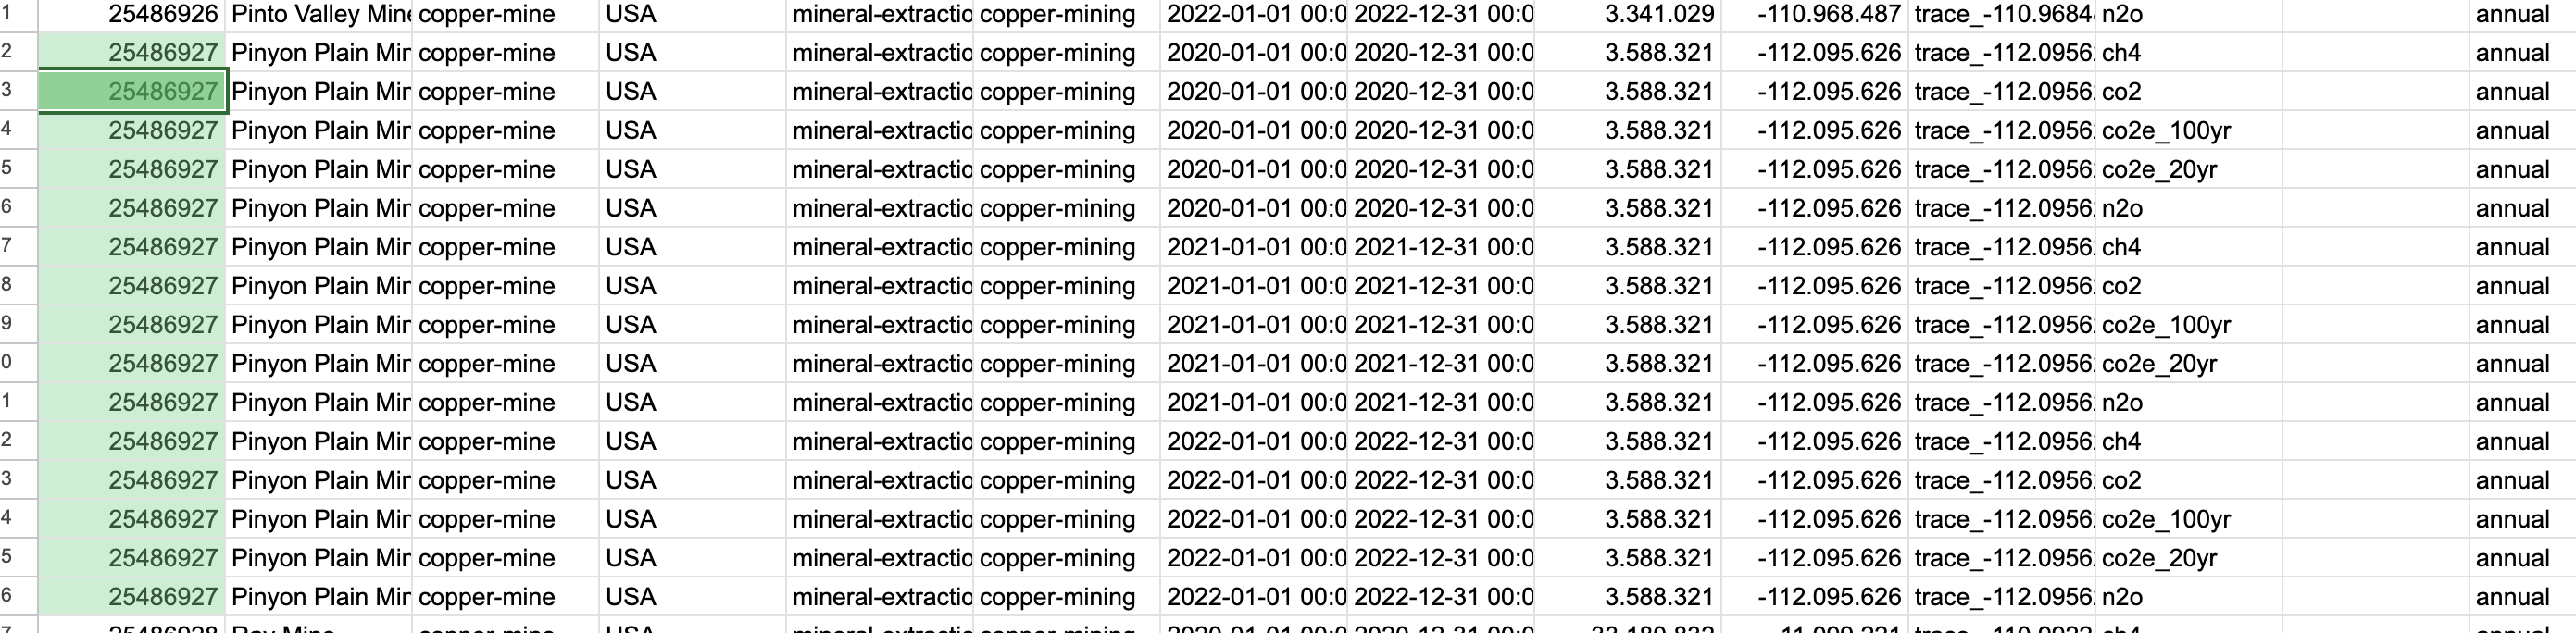

In [ ]:
# Drop rows where 'ct_emissions_quantity' is missing
climate_trace_combined_cleaned = climate_trace_combined.dropna(subset=['ct_emissions_quantity'])

## Check stability of ID

In [ ]:
display(climate_trace_combined[climate_trace_combined['ct_source_name'].astype(str).str.strip() == 'Asheville'])

ct_source_id ct_source_name            ct_subsector ct_iso3_country  \
373      25449770      Asheville  electricity-generation             USA   
374      25449771      Asheville  electricity-generation             USA   
375      25449771      Asheville  electricity-generation             USA   
376      25449771      Asheville  electricity-generation             USA   

           ct_start_time          ct_end_time   ct_lat   ct_lon      ct_gas  \
373  2019-01-01 00:00:00  2019-12-31 00:00:00  35.4731 -82.5417  co2e_100yr   
374  2020-01-01 00:00:00  2020-12-31 00:00:00  35.4731 -82.5417  co2e_100yr   
375  2021-01-01 00:00:00  2021-12-31 00:00:00  35.4731 -82.5417  co2e_100yr   
376  2022-01-01 00:00:00  2022-12-31 00:00:00  35.4731 -82.5417  co2e_100yr   

     ct_emissions_quantity        ct_coordinate  
373              2278000.0  (35.4731, -82.5417)  
374              1115000.0  (35.4731, -82.5417)  
375              1076000.0  (35.4731, -82.5417)  
376              1146000.0  (35.4731, -82.5417)

Here we can see that a facility (idenfified by same source_name, lat and lon) has changes to the source_id for different years

## Check stability of name

In [ ]:
display(climate_trace_combined[climate_trace_combined['ct_source_name'].astype(str).str.strip() == 'Barry'])

ct_source_id ct_source_name            ct_subsector ct_iso3_country  \
496      25448865          Barry  electricity-generation             USA   
497      25448865          Barry  electricity-generation             USA   
498      25448865          Barry  electricity-generation             USA   
499      25448866          Barry  electricity-generation             USA   

           ct_start_time          ct_end_time   ct_lat   ct_lon      ct_gas  \
496  2019-01-01 00:00:00  2019-12-31 00:00:00  31.0069 -88.0103  co2e_100yr   
497  2021-01-01 00:00:00  2021-12-31 00:00:00  31.0069 -88.0103  co2e_100yr   
498  2022-01-01 00:00:00  2022-12-31 00:00:00  31.0069 -88.0103  co2e_100yr   
499  2020-01-01 00:00:00  2020-12-31 00:00:00  31.0069 -88.0103  co2e_100yr   

     ct_emissions_quantity        ct_coordinate  
496              5648000.0  (31.0069, -88.0103)  
497              5772000.0  (31.0069, -88.0103)  
498              5669000.0  (31.0069, -88.0103)  
499              5073000.0  (31.0069, -88.0103)

Here different facilities share the same name

In conclusion:


*   A few facilites have unstable IDs -> need to consider this for matching
*   Facilities share the same coordinates -> also needs to be considered in matching, cannot be purely based on coordinates



## Aggregate monthly emissions data

In [ ]:
# Step 1: Convert 'ct_start_time' to datetime and extract the year
climate_trace_combined['ct_start_time'] = pd.to_datetime(climate_trace_combined['ct_start_time'], errors='coerce')

# Check for any conversion errors
if climate_trace_combined['ct_start_time'].isnull().any():
    print("Warning: Some 'ct_start_time' entries could not be converted to datetime.")

# Extract the year from 'ct_start_time'
climate_trace_combined['ct_year'] = climate_trace_combined['ct_start_time'].dt.year

# Step 2: Group by 'ct_source_id' and 'year' and count 'ct_start_time' entries
source_year_counts = climate_trace_combined.groupby(['ct_source_id', 'ct_year']).size().reset_index(name='start_time_count')

# Step 3: Identify unstable groups with multiple 'ct_start_time' entries
unstable_source_year = source_year_counts[source_year_counts['start_time_count'] > 1]

# Count the number of unstable groups
num_unstable = unstable_source_year.shape[0]

print(f"Number of (ct_source_id, ct_year) combinations with multiple ct_start_time: {num_unstable}")

# Step 4: Display a sample of unstable combinations
if num_unstable > 0:
    print("\nSample of unstable (ct_source_id, ct_year) combinations:")
    display(unstable_source_year.head(10))
else:
    print("All (ct_source_id, ct_year) combinations have stable ct_start_time.")

Number of (ct_source_id, ct_year) combinations with multiple ct_start_time: 8229

Sample of unstable (ct_source_id, ct_year) combinations:


ct_source_id  ct_year  start_time_count
521         62267     2015                12
522         62267     2016                12
523         62267     2017                12
524         62267     2018                12
525         62267     2019                12
526         62267     2020                12
527         62267     2021                12
528         62267     2022                12
529         62267     2023                 3
530         62268     2015                12

In [ ]:
display(climate_trace_combined[climate_trace_combined['ct_source_id'].astype(str).str.strip() == '62267'])

ct_source_id                       ct_source_name ct_subsector  \
10174         62267  Cleveland-Cliffs Butler steel plant        steel   
10175         62267  Cleveland-Cliffs Butler steel plant        steel   
10176         62267  Cleveland-Cliffs Butler steel plant        steel   
10177         62267  Cleveland-Cliffs Butler steel plant        steel   
10178         62267  Cleveland-Cliffs Butler steel plant        steel   
...             ...                                  ...          ...   
10268         62267  Cleveland-Cliffs Butler steel plant        steel   
10269         62267  Cleveland-Cliffs Butler steel plant        steel   
10270         62267  Cleveland-Cliffs Butler steel plant        steel   
10271         62267  Cleveland-Cliffs Butler steel plant        steel   
10272         62267  Cleveland-Cliffs Butler steel plant        steel   

      ct_iso3_country ct_start_time          ct_end_time     ct_lat  \
10174             USA    2015-01-01  2015-01-31 00:00:00  40.845524   
10175             USA    2015-02-01  2015-02-28 00:00:00  40.845524   
10176             USA    2015-03-01  2015-03-31 00:00:00  40.845524   
10177             USA    2015-04-01  2015-04-30 00:00:00  40.845524   
10178             USA    2015-05-01  2015-05-31 00:00:00  40.845524   
...               ...           ...                  ...        ...   
10268             USA    2022-11-01  2022-11-30 00:00:00  40.845524   
10269             USA    2022-12-01  2022-12-31 00:00:00  40.845524   
10270             USA    2023-01-01  2023-01-31 00:00:00  40.845524   
10271             USA    2023-02-01  2023-02-28 00:00:00  40.845524   
10272             USA    2023-03-01  2023-03-31 00:00:00  40.845524   

          ct_lon      ct_gas  ct_emissions_quantity            ct_coordinate  \
10174 -79.921452  co2e_100yr                19504.0  (40.845524, -79.921452)   
10175 -79.921452  co2e_100yr                15591.0  (40.845524, -79.921452)   
10176 -79.921452  co2e_100yr                16721.0  (40.845524, -79.921452)   
10177 -79.921452  co2e_100yr                15785.0  (40.845524, -79.921452)   
10178 -79.921452  co2e_100yr                17412.0  (40.845524, -79.921452)   
...          ...         ...                    ...                      ...   
10268 -79.921452  co2e_100yr                14809.0  (40.845524, -79.921452)   
10269 -79.921452  co2e_100yr                15223.0  (40.845524, -79.921452)   
10270 -79.921452  co2e_100yr                15925.0  (40.845524, -79.921452)   
10271 -79.921452  co2e_100yr                14574.0  (40.845524, -79.921452)   
10272 -79.921452  co2e_100yr                16700.0  (40.845524, -79.921452)   

       ct_year  
10174     2015  
10175     2015  
10176     2015  
10177     2015  
10178     2015  
...        ...  
10268     2022  
10269     2022  
10270     2023  
10271     2023  
10272     2023  

[99 rows x 12 columns]

We can see here that some rows have data for months of a year instead of full year emissions. This means we need to aggreate these into yearly rows and sum up their emissions

In [ ]:
print(f"Number of rows in climate_trace_combined before aggregation: {len(climate_trace_combined)}")

Number of rows in climate_trace_combined before aggregation: 363514


In [ ]:
# Define the grouping columns
group_cols = ['ct_source_id', 'ct_year']

# Perform the aggregation
annual_emissions = climate_trace_combined.groupby(group_cols).agg({
    'ct_emissions_quantity': 'sum',       # Sum emissions for the year
    'ct_source_name': 'first',
    'ct_subsector': 'first',
    'ct_iso3_country': 'first',
    'ct_lat': 'first',
    'ct_lon': 'first',
    'ct_gas': 'first',
    'ct_start_time': 'min',               # Earliest start_time of the year
    'ct_end_time': 'max',                 # Latest end_time of the year
    'ct_coordinate': 'first'
}).reset_index()


# Verify the Aggregation
# Check the number of unique (source_id, year) combinations
unique_combinations = annual_emissions.groupby(['ct_source_id', 'ct_year']).size().reset_index(name='count')
duplicates_after_agg = unique_combinations[unique_combinations['count'] > 1]

print(f"Total unique (source_id, year) combinations after aggregation: {annual_emissions.shape[0]}")
if duplicates_after_agg.empty:
    print("All (source_id, year) combinations are unique after aggregation.")
else:
    print(f"Number of duplicate (source_id, year) combinations after aggregation: {duplicates_after_agg.shape[0]}")
    display(duplicates_after_agg.head())

# Replace the original DataFrame with the aggregated annual data
climate_trace_combined = annual_emissions

Total unique (source_id, year) combinations after aggregation: 173073
All (source_id, year) combinations are unique after aggregation.


In [ ]:
print(f"Number of rows in climate_trace_combined before aggregation: {len(climate_trace_combined)}")

Number of rows in climate_trace_combined before aggregation: 173073


In [ ]:
display(climate_trace_combined[climate_trace_combined['ct_source_id'].astype(str).str.strip() == '62267'])

ct_source_id  ct_year  ct_emissions_quantity  \
521         62267     2015               196713.0   
522         62267     2016               195924.0   
523         62267     2017               201926.0   
524         62267     2018               202819.0   
525         62267     2019               204503.0   
526         62267     2020               174169.0   
527         62267     2021               215365.0   
528         62267     2022               195664.0   
529         62267     2023                47199.0   

                          ct_source_name ct_subsector ct_iso3_country  \
521  Cleveland-Cliffs Butler steel plant        steel             USA   
522  Cleveland-Cliffs Butler steel plant        steel             USA   
523  Cleveland-Cliffs Butler steel plant        steel             USA   
524  Cleveland-Cliffs Butler steel plant        steel             USA   
525  Cleveland-Cliffs Butler steel plant        steel             USA   
526  Cleveland-Cliffs Butler steel plant        steel             USA   
527  Cleveland-Cliffs Butler steel plant        steel             USA   
528  Cleveland-Cliffs Butler steel plant        steel             USA   
529  Cleveland-Cliffs Butler steel plant        steel             USA   

        ct_lat     ct_lon      ct_gas ct_start_time          ct_end_time  \
521  40.845524 -79.921452  co2e_100yr    2015-01-01  2015-12-31 00:00:00   
522  40.845524 -79.921452  co2e_100yr    2016-01-01  2016-12-31 00:00:00   
523  40.845524 -79.921452  co2e_100yr    2017-01-01  2017-12-31 00:00:00   
524  40.845524 -79.921452  co2e_100yr    2018-01-01  2018-12-31 00:00:00   
525  40.845524 -79.921452  co2e_100yr    2019-01-01  2019-12-31 00:00:00   
526  40.845524 -79.921452  co2e_100yr    2020-01-01  2020-12-31 00:00:00   
527  40.845524 -79.921452  co2e_100yr    2021-01-01  2021-12-31 00:00:00   
528  40.845524 -79.921452  co2e_100yr    2022-01-01  2022-12-31 00:00:00   
529  40.845524 -79.921452  co2e_100yr    2023-01-01  2023-03-31 00:00:00   

               ct_coordinate  
521  (40.845524, -79.921452)  
522  (40.845524, -79.921452)  
523  (40.845524, -79.921452)  
524  (40.845524, -79.921452)  
525  (40.845524, -79.921452)  
526  (40.845524, -79.921452)  
527  (40.845524, -79.921452)  
528  (40.845524, -79.921452)  
529  (40.845524, -79.921452)

We now have yearly emmissions data only

In [ ]:
# Check for proper year coverage
year_coverage = climate_trace_combined['ct_year'].value_counts().sort_index()
print(f"Year coverage:\n{year_coverage}")

Year coverage:
ct_year
2015    19643
2016    19600
2017    19614
2018    19611
2019    21874
2020    21799
2021    24574
2022    24595
2023     1763
Name: count, dtype: int64


# Define a broad category mapping between GHGRP and CT data




In [ ]:
# Define broad category mappings for `ghgrp_subparts`
ghgrp_broad_category_mapping = {

    # Manufacturing
    "Iron and Steel Production": ["Manufacturing"],
    "Glass Production": ["Manufacturing"],
    "Cement Production": ["Manufacturing"],
    "Pulp and Paper Manufacturing": ["Manufacturing"],
    "Lime Manufacturing": ["Manufacturing"],
    "Ammonia Manufacturing": ["Manufacturing"],
    "Petrochemical Production": ["Manufacturing"],
    "Hydrogen Production": ["Manufacturing"],
    "Aluminum Production": ["Manufacturing"],
    "Electronics Manufacturing": ["Manufacturing"],
    "Silicon Carbide Production": ["Manufacturing"],
    "Soda Ash Manufacturing": ["Manufacturing"],
    "Titanium Dioxide Production": ["Manufacturing"],
    "Manufacture of Electric Transmission and Distribution Equipment": ["Manufacturing"],
    "Lead Production": ["Manufacturing"],
    "Phosphoric Acid Production": ["Manufacturing"],
    "Nitric Acid Production": ["Manufacturing"],
    "Ferroalloy Production": ["Manufacturing"],
    "Zinc Production": ["Manufacturing"],
    "Magnesium Production": ["Manufacturing"],
    "Zinc Production": ["Manufacturing"],
    'Adipic Acid Production': ["Manufacturing"],

    # Mineral Extraction
    "Underground Coal Mines": ["Mineral Extraction"],

    # Power
    "Electricity Generation": ["Power"],

    # Transportation
    "Road Transportation": ["Transportation"],
    "Domestic Aviation": ["Transportation"],
    "International Aviation": ["Transportation"],

    # Waste
    "Municipal Solid Waste Landfills": ["Waste"],
    "Industrial Waste Landfills": ["Waste"],
    "Industrial Wastewater Treatment": ["Waste"],

    #Unsure -> 'Other' will always be valid
    "Geologic Sequestration of Carbon Dioxide": ["Other"],
    "Use of Electric Transmission and Distribution Equipment": ["Other"],
    "Importers and Exporters of Equipment Pre-Charged with Fluorinated GHGs or Containing Fluorinated GHGs in Closed-Cell Foams": ["Other"],
    "HCFC-22 Production and HFC-23 Destruction": ["Other"],
    "Injection of Carbon Dioxide": ["Other"],
    "Fluorinated Gas Production": ["Other"],
    "Petroleum Refineries": ["Other"], #  ["Fossil fuel operations & Fluorinated Gases"],
    "Suppliers of Natural Gas and Natural Gas Liquids": ["Other"], #  ["Fossil fuel operations & Fluorinated Gases"],
    "Suppliers of Petroleum Products": ["Other"], #  ["Fossil fuel operations & Fluorinated Gases"],
    "General Stationary Fuel Combustion Sources": ["Other"], #  ["Fossil fuel operations & Fluorinated Gases"],
    'Suppliers of Coal-based Liquid Fuels': ["Other"],
    'Suppliers of Carbon Dioxide': ["Other"],
    'Miscellaneous Uses of Carbonate': ["Other"],
    'Suppliers of Industrial Greenhouse Gases': ["Other"],

    # Fossil Fuel Operations & Fluorinated Gases
    "Petroleum and Natural Gas Systems": ["Fossil fuel operations & Fluorinated Gases"],
}

# Define broad category mappings for `ct_subsector`
ct_broad_category_mapping = {

    # Fossil Fuel Operations & Fluorinated Gases
    "oil-and-gas-production-and-transport": ["Fossil fuel operations & Fluorinated Gases"],
    "oil-and-gas-refining": ["Fossil fuel operations & Fluorinated Gases"],

    # Manufacturing
    "other-manufacturing": ["Manufacturing"],
    "aluminum": ["Manufacturing"],
    "petrochemicals": ["Manufacturing"],
    "steel": ["Manufacturing"],
    "cement": ["Manufacturing"],

    # Mineral Extraction
    "coal-mining": ["Mineral Extraction"],
    "copper-mining": ["Mineral Extraction"],
    "iron-mining": ["Mineral Extraction"],

    # Power
    "electricity-generation": ["Power"],

    # Transportation
    "road-transportation": ["Transportation"],
    "international-aviation": ["Transportation"],
    "domestic-aviation": ["Transportation"],
    "domestic-shipping": ["Transportation"],
    "international-shipping": ["Transportation"],

    # Waste
    "solid-waste-disposal": ["Waste"],
    "wastewater-treatment-and-discharge": ["Waste"],
}

# Apply the mappings to create the broad category columns
def map_ghgrp_broad_category(subparts):
    categories = set()
    for subpart in subparts.split(','):
        categories.update(ghgrp_broad_category_mapping.get(subpart.strip(), []))
    return ', '.join(categories)

def map_ct_broad_category(subsector):
    return ', '.join(ct_broad_category_mapping.get(subsector, []))

# Map the broad categories
ghgrp_combined['ghgrp_broad_category'] = ghgrp_combined['ghgrp_subparts'].apply(map_ghgrp_broad_category)
climate_trace_combined['ct_broad_category'] = climate_trace_combined['ct_subsector'].apply(map_ct_broad_category)

# Display results to verify
print("Sample of GHGRP broad categories:")
display(ghgrp_combined[['ghgrp_subparts', 'ghgrp_broad_category']].head())

print("Sample of Climate TRACE broad categories:")
display(climate_trace_combined[['ct_subsector', 'ct_broad_category']].head())

Sample of GHGRP broad categories:


ghgrp_subparts  \
0  Petroleum and Natural Gas Systems   
1    Municipal Solid Waste Landfills   
2             Underground Coal Mines   
3             Underground Coal Mines   
4  Petroleum and Natural Gas Systems   

                         ghgrp_broad_category  
0  Fossil fuel operations & Fluorinated Gases  
1                                       Waste  
2                          Mineral Extraction  
3                          Mineral Extraction  
4  Fossil fuel operations & Fluorinated Gases

Sample of Climate TRACE broad categories:


ct_subsector   ct_broad_category
0  coal-mining  Mineral Extraction
1  coal-mining  Mineral Extraction
2  coal-mining  Mineral Extraction
3  coal-mining  Mineral Extraction
4  coal-mining  Mineral Extraction

# Matching facility level emission data by coordinates

In [ ]:
# Convert 'ghgrp_coordinate' and 'ct_coordinate' columns to tuples if they are not already
# This will ensure they're formatted correctly for distance calculations
if ghgrp_combined['ghgrp_coordinate'].dtype == 'object':
    ghgrp_combined['ghgrp_coordinate'] = ghgrp_combined['ghgrp_coordinate'].apply(
        lambda x: eval(x) if isinstance(x, str) else x
    )

if climate_trace_combined['ct_coordinate'].dtype == 'object':
    climate_trace_combined['ct_coordinate'] = climate_trace_combined['ct_coordinate'].apply(
        lambda x: eval(x) if isinstance(x, str) else x
    )

# Check for any NaN values in critical matching columns
print("GHGRP Data NaN check for matching columns:")
print(ghgrp_combined[['ghgrp_year', 'ghgrp_latitude', 'ghgrp_longitude']].isnull().sum())

print("\nClimate TRACE Data NaN check for matching columns:")
print(climate_trace_combined[['ct_year', 'ct_lat', 'ct_lon']].isnull().sum())

GHGRP Data NaN check for matching columns:
ghgrp_year         0
ghgrp_latitude     0
ghgrp_longitude    0
dtype: int64

Climate TRACE Data NaN check for matching columns:
ct_year      0
ct_lat     382
ct_lon     382
dtype: int64


In [ ]:
# Define the distance thresholds in kilometers
distance_thresholds = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.075, 0.1, 0.5, 1.0]  # 5m, 10m, 15m, 20m, 25m, 30m, 35m, 40m, 45m, 50m, 75m, 100m, 500m, 1000m

# Iterate over each distance threshold
for threshold_km in distance_thresholds:
    print(f"\nRunning coordinate-based matching for threshold: {threshold_km * 1000:.0f} meters")

    # Define the path to save results for the current threshold
    coordinate_matches_file = f"/content/drive/MyDrive/Master_Thesis/coordinate_matches_{int(threshold_km * 1000)}m.pkl"

    if os.path.exists(coordinate_matches_file):
        # Load existing coordinate-based matches from file
        with open(coordinate_matches_file, 'rb') as file:
            matches = pickle.load(file)
        print(f"Loaded existing coordinate-based matches for {threshold_km * 1000:.0f} meters.")
        matched_df = pd.DataFrame(matches)
    else:
        # Initialize a list to store matches and matched indices
        matches = []
        matched_indices = set()

        # Loop through each year for matching
        for year in ghgrp_combined['ghgrp_year'].unique():
            ghgrp_year_data = ghgrp_combined[ghgrp_combined['ghgrp_year'] == year]
            climate_trace_year_data = climate_trace_combined[
                (climate_trace_combined['ct_year'] == year) &
                (~climate_trace_combined['ct_lat'].isna()) &
                (~climate_trace_combined['ct_lon'].isna())
            ].copy()

            # Build a k-d tree for Climate TRACE coordinates
            climate_trace_coords = np.array(climate_trace_year_data[['ct_lat', 'ct_lon']])
            climate_tree = cKDTree(climate_trace_coords)

            # Loop through GHGRP facilities and find the nearest Climate TRACE matches
            for i, ghgrp_row in tqdm(ghgrp_year_data.iterrows(), total=ghgrp_year_data.shape[0], desc=f"Matching year {year}"):
                ghgrp_coord = np.array(ghgrp_row['ghgrp_coordinate'])
                ghgrp_facility_name = ghgrp_row['ghgrp_facility_name']
                ghgrp_broad_categories = set(ghgrp_row['ghgrp_broad_category'].split(', '))

                # Query all Climate TRACE facilities within the threshold
                distances, indices = climate_tree.query(ghgrp_coord, k=len(climate_trace_coords), distance_upper_bound=threshold_km)

                # Filter for valid distances and create a new DataFrame
                valid_matches = climate_trace_year_data.iloc[indices[np.isfinite(distances)]].copy()
                valid_matches['distance'] = distances[np.isfinite(distances)]

                # Filter by category overlap
                valid_matches = valid_matches[
                    valid_matches['ct_broad_category'].apply(
                        lambda x: not ghgrp_broad_categories.isdisjoint(set(x.split(', ')))
                    ) | (ghgrp_broad_categories == {"Other"})
                ].copy()  # Ensure this is a fresh copy

                if not valid_matches.empty:
                    # Add name similarity scores
                    valid_matches['name_similarity'] = valid_matches['ct_source_name'].apply(
                        lambda x: fuzz.ratio(ghgrp_facility_name, x)
                    )

                    # Sort by combined score (prioritize name similarity and distance)
                    valid_matches['combined_score'] = (
                        0.5 * (1 - valid_matches['distance'] / threshold_km) +
                        0.5 * (valid_matches['name_similarity'] / 100)
                    )

                    # Sort valid matches and select the best one
                    valid_matches = valid_matches.sort_values(by='combined_score', ascending=False)

                    # Take the best match
                    best_match = valid_matches.iloc[0]
                    match = ghgrp_row.to_dict()
                    for col in valid_matches.columns:
                        match[col] = best_match[col]
                    matches.append(match)
                    matched_indices.add(best_match.name)

        # Save matches for this threshold
        with open(coordinate_matches_file, 'wb') as file:
            pickle.dump(matches, file)
        print(f"Matches for {threshold_km * 1000:.0f} meters saved.")


Running coordinate-based matching for threshold: 5 meters
Loaded existing coordinate-based matches for 5 meters.

Running coordinate-based matching for threshold: 10 meters
Loaded existing coordinate-based matches for 10 meters.

Running coordinate-based matching for threshold: 15 meters
Loaded existing coordinate-based matches for 15 meters.

Running coordinate-based matching for threshold: 20 meters
Loaded existing coordinate-based matches for 20 meters.

Running coordinate-based matching for threshold: 25 meters
Loaded existing coordinate-based matches for 25 meters.

Running coordinate-based matching for threshold: 30 meters
Loaded existing coordinate-based matches for 30 meters.

Running coordinate-based matching for threshold: 35 meters
Loaded existing coordinate-based matches for 35 meters.

Running coordinate-based matching for threshold: 40 meters
Loaded existing coordinate-based matches for 40 meters.

Running coordinate-based matching for threshold: 45 meters
Loaded existin

In [ ]:
# Initialize a dictionary to store each threshold's DataFrame
matched_dfs = {}

# Load each matched dataset
for threshold_km in distance_thresholds:
    # Define the path for the pickled matched data
    file_path = f"/content/drive/MyDrive/Master_Thesis/coordinate_matches_{int(threshold_km * 1000)}m.pkl"

    # Load the DataFrame directly from the pickled file
    with open(file_path, 'rb') as file:
        matches = pickle.load(file)
    matched_df = pd.DataFrame(matches)
    matched_dfs[f"{int(threshold_km * 1000)}m"] = matched_df

# Fuzzy matching for rows that have not found a match so far

In [ ]:
import pandas as pd
from fuzzywuzzy import fuzz, process
import os
import pickle
from tqdm import tqdm

# Define the path to save and load fuzzy match results
fuzzy_matches_file = os.path.join(data_folder, "fuzzy_matches.pkl")

# Step 1: Check if fuzzy matches file exists
if os.path.exists(fuzzy_matches_file):
    # Load existing fuzzy matches from file
    with open(fuzzy_matches_file, 'rb') as file:
        fuzzy_matches = pickle.load(file)
    print("Loaded existing fuzzy matches from file.")
else:
    # Step 2: Identify unmatched rows in GHGRP and Climate TRACE
    matched_ghgrp_indices = {match['ghgrp_id'] for match in matches}  # GHGRP matched indices
    matched_ct_indices = {match['ct_source_id'] for match in matches}  # Climate TRACE matched indices

    unmatched_ghgrp = ghgrp_combined[~ghgrp_combined['ghgrp_id'].isin(matched_ghgrp_indices)]
    unmatched_ct = climate_trace_combined[~climate_trace_combined['ct_source_id'].isin(matched_ct_indices)]

    # Step 3: Load and merge ownership data into Climate TRACE
    ownership_file_path = os.path.join(data_folder, "oil-and-gas-production-and-transport_emissions_sources_ownership.csv")
    ownership_df = pd.read_csv(ownership_file_path, low_memory=False)

    # Rename columns in ownership data for consistent merging
    ownership_df = ownership_df.rename(columns={
        'source_name': 'ct_source_name',
        'company_name': 'ct_ownership',  # Name used in Climate TRACE for matching
        'end_date': 'ct_end_time'
    })

    # Merge ownership data into unmatched Climate TRACE data
    unmatched_ct = pd.merge(
        unmatched_ct,
        ownership_df[['ct_source_name', 'ct_ownership', 'source_id', 'ct_end_time']],
        how='left',
        left_on=['ct_source_id', 'ct_end_time'],
        right_on=['source_id', 'ct_end_time']
    )

    # Resolve column naming conflicts after merge
    unmatched_ct['ct_source_name'] = unmatched_ct['ct_source_name_x'].combine_first(unmatched_ct['ct_source_name_y'])
    unmatched_ct = unmatched_ct.drop(columns=['ct_source_name_x', 'ct_source_name_y', 'source_id'])

    # Step 4: Perform Fuzzy Matching on Names and Ownership
    fuzzy_matches = []
    for i, ghgrp_row in tqdm(unmatched_ghgrp.iterrows(), total=unmatched_ghgrp.shape[0], desc="Fuzzy matching"):
        ghgrp_name = str(ghgrp_row['ghgrp_facility_name'])
        ghgrp_company = str(ghgrp_row['ghgrp_parent_companies'])
        ghgrp_year = ghgrp_row['ghgrp_year']

        # Filter unmatched CT data for the same year
        ct_year_data = unmatched_ct[unmatched_ct['ct_year'] == ghgrp_year]

        # Use fuzzy matching to find the best match for the facility name
        if not ct_year_data.empty:
            best_match_name, best_score_name = process.extractOne(ghgrp_name, ct_year_data['ct_source_name'].tolist(), scorer=fuzz.token_set_ratio)

            # Filter for the best name match and compare ownership
            if best_score_name > 70:
                ct_best_match_row = ct_year_data[ct_year_data['ct_source_name'] == best_match_name].iloc[0]
                ct_company = str(ct_best_match_row.get('ct_ownership', ''))
                company_similarity = fuzz.token_set_ratio(ghgrp_company, ct_company)
                combined_score = (best_score_name + company_similarity) / 2

                # Consider match only if combined score is above threshold
                if combined_score > 70:
                    # Combine both rows into a single dictionary, including all columns from both dataframes
                    match = {**ghgrp_row.to_dict(), **ct_best_match_row.to_dict(), 'similarity_score': combined_score}
                    fuzzy_matches.append(match)

                    # Mark this Climate TRACE row as matched to avoid duplicates
                    unmatched_ct = unmatched_ct.drop(ct_best_match_row.name)

    # Step 5: Save the fuzzy matches to a file
    with open(fuzzy_matches_file, 'wb') as file:
        pickle.dump(fuzzy_matches, file)
    print("Fuzzy matches have been saved to file.")

# Convert fuzzy_matches to a DataFrame for further analysis or merging
fuzzy_matches_df = pd.DataFrame(fuzzy_matches)
display(fuzzy_matches_df.head())

Loaded existing fuzzy matches from file.


ghgrp_year                         ghgrp_facility_name  ghgrp_id  \
0        2015           EPNG Station 6399 Black River, TX   1012153   
1        2015                                 Elk Station   1012043   
2        2015          Faith San Pedro Compressor Station   1011105   
3        2015                               Kemper County   1001179   
4        2015  Matador Production Company - Permian Basin   1012068   

         ghgrp_reported_address  ghgrp_latitude  ghgrp_longitude  \
0                           NaN       30.744447      -102.491284   
1          1454 County Road 315       33.861807      -101.843823   
2        23665 Faith Ranch Road       28.263946      -100.021955   
3              221 MARK COBB RD       32.797600       -88.605700   
4  5400 LBJ Freeway, Suite 1500       32.924583       -96.816715   

   ghgrp_city_name ghgrp_county_name ghgrp_STATE  ghgrp_zip_code  ...  \
0    Fort Stockton      PECOS COUNTY          TX           79735  ...   
1        Abernathy       HALE COUNTY          TX           79311  ...   
2  Carrizo Springs     DIMMIT COUNTY          TX           78834  ...   
3          DE KALB            Kemper          MS           39328  ...   
4           Dallas               NaN          TX           75240  ...   

  ct_iso3_country     ct_lat      ct_lon      ct_gas  ct_start_time  \
0             USA  33.620574  -95.049944  co2e_100yr     2015-01-01   
1             USA  37.453616  -96.244365  co2e_100yr     2015-01-01   
2             USA  37.702820 -120.419017  co2e_100yr     2015-01-01   
3             USA  32.753544  -88.640733  co2e_100yr     2015-01-01   
4             USA        NaN         NaN  co2e_100yr     2015-01-01   

           ct_end_time                             ct_coordinate ct_ownership  \
0  2015-12-31 00:00:00   (33.62057435270091, -95.04994365356008)          NaN   
1  2015-12-31 00:00:00   (37.45361554718224, -96.24436523137376)          NaN   
2  2015-12-31 00:00:00                   (37.70282, -120.419017)          NaN   
3  2015-12-31 00:00:00  (32.753543982789154, -88.64073300858284)          NaN   
4  2015-12-31 00:00:00                                (nan, nan)          NaN   

  ct_source_name  similarity_score  
0      Red River              85.5  
1            Elk             100.0  
2      Don Pedro              85.5  
3         Kemper             100.0  
4     Permian NM              91.0  

[5 rows x 28 columns]

In [ ]:
# Calculate the total number of rows in ghgrp_combined by year
total_ghgrp_by_year = ghgrp_combined.groupby('ghgrp_year').size()

# Calculate the number of fuzzy matches found by year
matched_ghgrp_by_year_fuzzy = fuzzy_matches_df['ghgrp_year'].value_counts()

# Calculate the percentage of fuzzy matches for each year
fuzzy_match_percentage_by_year = (matched_ghgrp_by_year_fuzzy / total_ghgrp_by_year * 100).round(2)

# Combine into a DataFrame for easy viewing
fuzzy_match_summary = pd.DataFrame({
    'Total GHGRP Rows': total_ghgrp_by_year,
    'Fuzzy Matched Rows': matched_ghgrp_by_year_fuzzy,
    'Fuzzy Match Percentage (%)': fuzzy_match_percentage_by_year
}).fillna(0)  # Fill NaN with 0 for years with no matches

# Display the fuzzy match summary by year
display(fuzzy_match_summary)

Total GHGRP Rows  Fuzzy Matched Rows  Fuzzy Match Percentage (%)
ghgrp_year                                                                  
2015                    7983                20.0                        0.25
2016                    7643                 8.0                        0.10
2017                    7569                 1.0                        0.01
2018                    7676                 0.0                        0.00
2019                    7683                 0.0                        0.00
2020                    7643                 0.0                        0.00
2021                    7615                 0.0                        0.00
2022                    7546                 9.0                        0.12

In [ ]:
print(fuzzy_matches_df.shape[0])

38


In [ ]:
# Adding distance to the matches where possible for better evaluation

# Define a function to calculate the Haversine distance
def haversine(coord1, coord2):
    # Radius of Earth in kilometers
    R = 6371.0

    # Unpack latitude/longitude from coordinates
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Compute differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Apply the distance calculation to rows with both coordinates available
fuzzy_matches_df['distance'] = fuzzy_matches_df.apply(
    lambda row: haversine(row['ghgrp_coordinate'], row['ct_coordinate'])
    if pd.notnull(row['ghgrp_coordinate']) and pd.notnull(row['ct_coordinate'])
    else np.nan,  # Set distance to NaN if coordinates are missing
    axis=1
)

## Manually confirming fuzzy matches

Manual confirmation using the web interfaces for [GHGRP](https://ghgdata.epa.gov/ghgp/main.do#/listFacility/?q=Ascent%20Resources%20-%20Utica%20(160a)&st=&bs=&et=&fid=&sf=10000100&lowE=-20000&highE=23000000&g1=1&g2=1&g3=1&g4=1&g5=1&g6=0&g7=1&g8=1&g9=1&g10=1&g11=1&g12=1&s1=1&s2=1&s3=1&s4=1&s5=1&s6=1&s7=1&s8=1&s9=1&s10=1&s201=1&s202=1&s203=1&s204=1&s301=1&s302=1&s303=1&s304=1&s305=1&s306=1&s307=1&s401=1&s402=1&s403=1&s404=1&s405=1&s601=1&s602=1&s701=1&s702=1&s703=1&s704=1&s705=1&s706=1&s707=1&s708=1&s709=1&s710=1&s711=1&s801=1&s802=1&s803=1&s804=1&s805=1&s806=1&s807=1&s808=1&s809=1&s810=1&s901=1&s902=1&s903=1&s904=1&s905=1&s906=1&s907=1&s908=1&s909=1&s910=1&s911=1&si=&ss=&so=0&ds=E&yr=2015&tr=current&cyr=2015&ol=0&sl=0&rs=ALL) and [CT](https://climatetrace.org/explore/#admin=&gas=co2e&year=2022&timeframe=100&sector=&asset=) as the latter offers more information, namely coordinates, online

In [ ]:
# Sort by similarity_score in descending order
fuzzy_matches_df_sorted = fuzzy_matches_df.sort_values(by='similarity_score', ascending=False)

# Display the selected columns with the new distance column, ordered by similarity_score
display(fuzzy_matches_df_sorted[['ghgrp_id', 'ghgrp_year', 'ghgrp_facility_name', 'ghgrp_parent_companies',
                                 'ct_source_name', 'ct_subsector', 'ct_ownership', 'distance', 'similarity_score']])

ghgrp_id  ghgrp_year                                ghgrp_facility_name  \
31   1011454        2022                    Ascent Resources - Utica (160a)   
18   1012060        2015               White Rock Oil & Gas LLC - 230 ArkLa   
32   1013230        2022  BCE-Mach III Midstream Holding LLC (Boosters -...   
15   1010745        2015               U.S. Air Force JBSA Fort Sam Houston   
1    1012043        2015                                        Elk Station   
13   1004219        2015          U S MARINE CORPS CHERRY POINT AIR STATION   
21   1001179        2016                                      Kemper County   
11   1012077        2015                     SandRidge 545 North Park Basin   
10   1012039        2015                             Saint Francis Hospital   
22   1003756        2016                     Naval Medical Center San Diego   
24   1004219        2016          U S MARINE CORPS CHERRY POINT AIR STATION   
7    1012163        2015                    New York State Electric and Gas   
6    1003756        2015                     Naval Medical Center San Diego   
26   1010745        2016               U.S. Air Force JBSA Fort Sam Houston   
3    1001179        2015                                      Kemper County   
33   1013601        2022          Blackbeard Operating - 345 - Arkoma Basin   
17   1001888        2015                 United States Department of Energy   
27   1003631        2016                                 US ARMY FORT BLISS   
16   1003631        2015                                 US ARMY FORT BLISS   
9    1012100        2015                 SEP Williston Basin 395 Production   
5    1013845        2015          Mewbourne Oil Company - Permian Basin 430   
4    1012068        2015         Matador Production Company - Permian Basin   
19   1013771        2015      Zavanna, LLC Williston Basin (395) Operations   
29   1008287        2022                             360 Anadarko Basin DEC   
20   1012651        2016                        Heritage-Crystal Clean, LLC   
23   1000857        2016                     POET BIOREFINING GLENVILLE LLC   
8    1000857        2015                     POET BIOREFINING GLENVILLE LLC   
28   1000857        2017                     POET BIOREFINING GLENVILLE LLC   
14   1001890        2015                      U.S. ARMY ANNISTON ARMY DEPOT   
12   1012042        2015                             Shamrock Landfill Inc.   
25   1001890        2016                      U.S. ARMY ANNISTON ARMY DEPOT   
30   1011393        2022                     Ascent Resources - Utica (160)   
0    1012153        2015                  EPNG Station 6399 Black River, TX   
2    1011105        2015                 Faith San Pedro Compressor Station   
34   1012437        2022        Blackbeard Operating - 360 - Anadarko Basin   
37   1012797        2022  Range Resources - Appalachia, LLC - Basin 160A...   
36   1014226        2022                     Formentera Anadarko Production   
35   1012731        2022                           EnLink Anadarko #360-G&B   

                   ghgrp_parent_companies                     ct_source_name  \
31  ASCENT RESOURCES OPERATING LLC (100%)                              Utica   
18                                    NaN                               Rock   
32                BCE-MACH III LLC (100%)                           Anadarko   
15                                    NaN                            Houston   
1                                     NaN                                Elk   
13                                    NaN                             Cherry   
21                                    NaN                             Kemper   
11                                    NaN                               Park   
10                                    NaN                            FRANCIS   
22                                    NaN                          San Diego   
24                                    NaN 

In [ ]:
# IDs of valid matches
valid_fuzzy_matches_ghgrp_id = [1011454, 1013230, 1013601, 1013845, 1012068, 1011393, 1012437, 1012731, 1012797, 1014226]

In [ ]:
# Drop all rowsfrom fuzzy_matches_df where the ghgrp_id is not in valid_fuzzy_matches_ghgrp_id

fuzzy_matches_df = fuzzy_matches_df[fuzzy_matches_df['ghgrp_id'].isin(valid_fuzzy_matches_ghgrp_id)]

# Combine two matched dataframes

In [ ]:
print(fuzzy_matches_df.shape[0])

10


In [ ]:
print(matched_df.shape[0])

48815


In [ ]:
# Define the list of distance thresholds
distance_thresholds = [10, 25, 50, 100, 1000]  # Distance thresholds in meters

# Loop over each threshold and process the corresponding coordinate match file
for threshold in distance_thresholds:
    # Load the coordinate-based match DataFrame for the current threshold
    coord_match_file = f"/content/drive/MyDrive/Master_Thesis/matched_data_{threshold}m.pkl"
    if os.path.exists(coord_match_file):
        with open(coord_match_file, 'rb') as file:
            matches = pickle.load(file)
        matched_df = pd.DataFrame(matches)
        print(f"Loaded coordinate-based matches for {threshold}m.")

        # Step 1: Check for overlaps in `ghgrp_id` and `ghgrp_year` between fuzzy and coordinate matches
        overlap_fuzzy = fuzzy_matches_df[['ghgrp_id', 'ghgrp_year']]
        overlap_coord = matched_df[['ghgrp_id', 'ghgrp_year']]

        # Find overlapping rows in both DataFrames
        overlap = pd.merge(overlap_fuzzy, overlap_coord, on=['ghgrp_id', 'ghgrp_year'], how='inner')

        # Display overlapping rows if any exist
        if not overlap.empty:
            print(f"Warning: Overlapping rows found in both fuzzy and {threshold}m coordinate matches:")
            display(overlap)
        else:
            print(f"No overlaps found for the {threshold}m coordinate matches. Proceeding with the merge.")

        # Step 2: Remove overlaps to avoid duplication
        fuzzy_matches_df_non_overlap = fuzzy_matches_df[~fuzzy_matches_df.set_index(['ghgrp_id', 'ghgrp_year']).index.isin(overlap.set_index(['ghgrp_id', 'ghgrp_year']).index)]
        matched_df_non_overlap = matched_df[~matched_df.set_index(['ghgrp_id', 'ghgrp_year']).index.isin(overlap.set_index(['ghgrp_id', 'ghgrp_year']).index)]

        # Step 3: Combine the unique rows from both DataFrames
        final_combined_df = pd.concat([fuzzy_matches_df_non_overlap, matched_df_non_overlap], ignore_index=True)

        # Save the combined DataFrame for this threshold
        output_file = f"/content/drive/MyDrive/Master_Thesis/final_combined_{threshold}m.pkl"
        with open(output_file, 'wb') as file:
            pickle.dump(final_combined_df, file)
        print(f"Final combined DataFrame for {threshold}m saved to {output_file}")

        # Optional: Display the combined DataFrame for verification
        display(final_combined_df)
    else:
        print(f"Coordinate match file for {threshold}m does not exist.")

Coordinate match file for 10m does not exist.
Coordinate match file for 25m does not exist.
Coordinate match file for 50m does not exist.
Coordinate match file for 100m does not exist.
Coordinate match file for 1000m does not exist.


# Clean the result

In [ ]:
# Define the columns to drop
columns_to_drop = [
    'ghgrp_latitude', 'ghgrp_longitude', 'ct_iso3_country', 'ct_lat', 'ct_lon',
    'ct_gas', 'ct_start_time', 'ct_end_time', 'ct_ownership'
]

# Initialize a dictionary to store cleaned DataFrames
cleaned_dfs = {}

# Loop through each threshold DataFrame, drop columns, and check null values
for threshold_label, df in matched_dfs.items():
    # Create a copy to avoid modifying the original matched_dfs
    df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

    # Store the cleaned DataFrame in the dictionary
    cleaned_dfs[threshold_label] = df_cleaned

    # Display the DataFrame after dropping columns
    print(f"\nDataFrame for threshold {threshold_label} after dropping columns:")
    display(df_cleaned)

    # Loop through each column and print the percentage of null values
    print(f"\nNull value percentages for threshold {threshold_label}:")
    for column in df_cleaned.columns:
        null_percentage = df_cleaned[column].isnull().mean() * 100
        print(f"Column '{column}' has {null_percentage:.2f}% null values.")


DataFrame for threshold 5m after dropping columns:


ghgrp_year                      ghgrp_facility_name  ghgrp_id  \
0            2015                             3M BROWNWOOD   1003188   
1            2015                             3M CO - GUIN   1003739   
2            2015           3M Cottage Grove Center - Site   1004836   
3            2015  3M MAGNETIC TAPE MANUFACTURING DIVISION   1004914   
4            2015                          3M NEVADA PLANT   1004804   
...           ...                                      ...       ...   
17767        2022                           ZFS Ithaca LLC   1013961   
17768        2022               Zeeland Generating Station   1001308   
17769        2022                       Zion Energy Center   1000805   
17770        2022                        voestalpine Texas   1012625   
17771        2022                       white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0              4501 HIGHWAY 377 SOUTH       BROWNWOOD         Brown County   
1                  6675 US HIGHWAY 43            GUIN        Marion County   
2                 10746 Innovation Rd   Cottage Grove    Washington County   
3      905-915 ADAMS STREET SOUTHEAST      HUTCHINSON        Mcleod County   
4                      2120 E. AUSTIN          NEVADA        Vernon County   
...                               ...             ...                  ...   
17767          1266 E WASHINGTON ROAD          ITHACA       Gratiot County   
17768                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
17769                   5701 NINTH ST            ZION          Lake County   
17770  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
17771             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code ghgrp_parent_companies  ghgrp_emissions_tons  \
0              TX          76801                     3M                 36755   
1              AL          35563                     3M                 31695   
2              MN          55016                     3M                 45416   
3              MN          55350                     3M                 36317   
4              MO          64772                     3M                 31007   
...           ...            ...                    ...                   ...   
17767          MI          48847             ZFS ITHACA                 47503   
17768          MI          49464        CMS ENERGY CORP               1924014   
17769          IL          60099         CPN MANAGEMENT                202771   
17770          TX          78374     VOESTALPINE, TEXAS                788416   
17771          NC          28785      COUNTY OF HAYWOOD                105620   

       ... ct_source_id ct_year ct_emissions_quantity  \
0      ...      3192390    2015          3.675650e+04   
1      ...      3192391    2015          3.169526e+04   
2      ...      3192392    2015          3.067302e+04   
3      ...      3192393    2015          3.891980e+04   
4      ...      3192394    2015          3.100945e+04   
...    ...          ...     ...                   ...   
17767  ...      3194491    2022          4.235283e+04   
17768  ...     25449346    2022          1.086000e+06   
17769  ...     25456644    2022          8.100000e+05   
17770  ...      3194069    2022          9.223109e+04   
17771  ...     25768777    2022          8.926176e+04   

                                ct_source_name            ct_subsector  \
0                                 3M BROWNWOOD     other-manufacturing   
1                                 3M CO - GUIN     other-manufacturing   
2               3M Cottage Grove Center - Site     other-manufacturing   
3      3M MAGNETIC TAPE MANUFACTURING DIVISION     other-manufacturing   
4                              3M NEVADA PLANT     other-manufacturing   
...                                        ...                     ...   
17767                        


Null value percentages for threshold 5m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 1.43% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.02% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null va

ghgrp_year                      ghgrp_facility_name  ghgrp_id  \
0            2015                             3M BROWNWOOD   1003188   
1            2015                             3M CO - GUIN   1003739   
2            2015           3M Cottage Grove Center - Site   1004836   
3            2015  3M MAGNETIC TAPE MANUFACTURING DIVISION   1004914   
4            2015                          3M NEVADA PLANT   1004804   
...           ...                                      ...       ...   
20286        2022                           ZFS Ithaca LLC   1013961   
20287        2022               Zeeland Generating Station   1001308   
20288        2022                       Zion Energy Center   1000805   
20289        2022                        voestalpine Texas   1012625   
20290        2022                       white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0              4501 HIGHWAY 377 SOUTH       BROWNWOOD         Brown County   
1                  6675 US HIGHWAY 43            GUIN        Marion County   
2                 10746 Innovation Rd   Cottage Grove    Washington County   
3      905-915 ADAMS STREET SOUTHEAST      HUTCHINSON        Mcleod County   
4                      2120 E. AUSTIN          NEVADA        Vernon County   
...                               ...             ...                  ...   
20286          1266 E WASHINGTON ROAD          ITHACA       Gratiot County   
20287                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
20288                   5701 NINTH ST            ZION          Lake County   
20289  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
20290             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code ghgrp_parent_companies  ghgrp_emissions_tons  \
0              TX          76801                     3M                 36755   
1              AL          35563                     3M                 31695   
2              MN          55016                     3M                 45416   
3              MN          55350                     3M                 36317   
4              MO          64772                     3M                 31007   
...           ...            ...                    ...                   ...   
20286          MI          48847             ZFS ITHACA                 47503   
20287          MI          49464        CMS ENERGY CORP               1924014   
20288          IL          60099         CPN MANAGEMENT                202771   
20289          TX          78374     VOESTALPINE, TEXAS                788416   
20290          NC          28785      COUNTY OF HAYWOOD                105620   

       ... ct_source_id ct_year ct_emissions_quantity  \
0      ...      3192390    2015          3.675650e+04   
1      ...      3192391    2015          3.169526e+04   
2      ...      3192392    2015          3.067302e+04   
3      ...      3192393    2015          3.891980e+04   
4      ...      3192394    2015          3.100945e+04   
...    ...          ...     ...                   ...   
20286  ...      3194491    2022          4.235283e+04   
20287  ...     25449346    2022          1.086000e+06   
20288  ...     25456644    2022          8.100000e+05   
20289  ...      3194069    2022          9.223109e+04   
20290  ...     25768777    2022          8.926176e+04   

                                ct_source_name            ct_subsector  \
0                                 3M BROWNWOOD     other-manufacturing   
1                                 3M CO - GUIN     other-manufacturing   
2               3M Cottage Grove Center - Site     other-manufacturing   
3      3M MAGNETIC TAPE MANUFACTURING DIVISION     other-manufacturing   
4                              3M NEVADA PLANT     other-manufacturing   
...                                        ...                     ...   
20286                        


Null value percentages for threshold 10m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 1.57% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.01% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null v

ghgrp_year             ghgrp_facility_name  ghgrp_id  \
0            2015                    3M BROWNWOOD   1003188   
1            2015                    3M CO - GUIN   1003739   
2            2015         3M CO - WAUSAU DOWNTOWN   1007698   
3            2015                      3M COMPANY   1004206   
4            2015  3M Cottage Grove Center - Site   1004836   
...           ...                             ...       ...   
22152        2022                   ZION LANDFILL   1005985   
22153        2022      Zeeland Generating Station   1001308   
22154        2022              Zion Energy Center   1000805   
22155        2022               voestalpine Texas   1012625   
22156        2022              white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0              4501 HIGHWAY 377 SOUTH       BROWNWOOD         Brown County   
1                  6675 US HIGHWAY 43            GUIN        Marion County   
2                    144 ROSECRANS ST          WAUSAU      Marathon County   
3                1400 STATE DOCKS RD.         DECATUR        Morgan County   
4                 10746 Innovation Rd   Cottage Grove    Washington County   
...                               ...             ...                  ...   
22152              701 GREEN BAY ROAD            ZION          Lake County   
22153                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
22154                   5701 NINTH ST            ZION          Lake County   
22155  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
22156             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code      ghgrp_parent_companies  \
0              TX          76801                          3M   
1              AL          35563                          3M   
2              WI          54401                          3M   
3              AL          35609                          3M   
4              MN          55016                          3M   
...           ...            ...                         ...   
22152          IL          60099  GFL ENVIRONMENTAL HOLDINGS   
22153          MI          49464             CMS ENERGY CORP   
22154          IL          60099              CPN MANAGEMENT   
22155          TX          78374          VOESTALPINE, TEXAS   
22156          NC          28785           COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                     36755  ...      3192390    2015          3.675650e+04   
1                     31695  ...      3192391    2015          3.169526e+04   
2                     22927  ...      3278446    2015          3.537177e+03   
3                     47000  ...      3192581    2015          4.026672e+04   
4                     45416  ...      3192392    2015          3.067302e+04   
...                     ...  ...          ...     ...                   ...   
22152                 62157  ...     25768398    2022          6.660668e+04   
22153               1924014  ...     25449346    2022          1.086000e+06   
22154                202771  ...     25456644    2022          8.100000e+05   
22155                788416  ...      3194069    2022          9.223109e+04   
22156                105620  ...     25768777    2022          8.926176e+04   

                       ct_source_name                        ct_subsector  \
0                        3M BROWNWOOD                 other-manufacturing   
1                        3M CO - GUIN                 other-manufacturing   
2                         WAUSAU WWTP  wastewater-treatment-and-discharge   
3                      AlphaPET, Inc.                 other-manufacturing   
4      3M Cottage Grove Center - Site                 other-manufacturing   
...                               ...                                 ...   
22152                   Zion Landfill                sol


Null value percentages for threshold 15m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 1.58% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.01% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null v

ghgrp_year             ghgrp_facility_name  ghgrp_id  \
0            2015                    3M BROWNWOOD   1003188   
1            2015                    3M CO - GUIN   1003739   
2            2015         3M CO - WAUSAU DOWNTOWN   1007698   
3            2015                      3M COMPANY   1004206   
4            2015  3M Cottage Grove Center - Site   1004836   
...           ...                             ...       ...   
23416        2022                   ZION LANDFILL   1005985   
23417        2022      Zeeland Generating Station   1001308   
23418        2022              Zion Energy Center   1000805   
23419        2022               voestalpine Texas   1012625   
23420        2022              white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0              4501 HIGHWAY 377 SOUTH       BROWNWOOD         Brown County   
1                  6675 US HIGHWAY 43            GUIN        Marion County   
2                    144 ROSECRANS ST          WAUSAU      Marathon County   
3                1400 STATE DOCKS RD.         DECATUR        Morgan County   
4                 10746 Innovation Rd   Cottage Grove    Washington County   
...                               ...             ...                  ...   
23416              701 GREEN BAY ROAD            ZION          Lake County   
23417                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
23418                   5701 NINTH ST            ZION          Lake County   
23419  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
23420             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code      ghgrp_parent_companies  \
0              TX          76801                          3M   
1              AL          35563                          3M   
2              WI          54401                          3M   
3              AL          35609                          3M   
4              MN          55016                          3M   
...           ...            ...                         ...   
23416          IL          60099  GFL ENVIRONMENTAL HOLDINGS   
23417          MI          49464             CMS ENERGY CORP   
23418          IL          60099              CPN MANAGEMENT   
23419          TX          78374          VOESTALPINE, TEXAS   
23420          NC          28785           COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                     36755  ...      3192390    2015          3.675650e+04   
1                     31695  ...      3192391    2015          3.169526e+04   
2                     22927  ...      3278446    2015          3.537177e+03   
3                     47000  ...      3192581    2015          4.026672e+04   
4                     45416  ...      3192392    2015          3.067302e+04   
...                     ...  ...          ...     ...                   ...   
23416                 62157  ...     25768398    2022          6.660668e+04   
23417               1924014  ...     25449346    2022          1.086000e+06   
23418                202771  ...     25456644    2022          8.100000e+05   
23419                788416  ...      3194069    2022          9.223109e+04   
23420                105620  ...     25768777    2022          8.926176e+04   

                       ct_source_name                        ct_subsector  \
0                        3M BROWNWOOD                 other-manufacturing   
1                        3M CO - GUIN                 other-manufacturing   
2                         WAUSAU WWTP  wastewater-treatment-and-discharge   
3                      AlphaPET, Inc.                 other-manufacturing   
4      3M Cottage Grove Center - Site                 other-manufacturing   
...                               ...                                 ...   
23416                   Zion Landfill                sol


Null value percentages for threshold 20m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 1.58% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.01% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null v

ghgrp_year         ghgrp_facility_name  ghgrp_id  \
0            2015                3M BROWNWOOD   1003188   
1            2015                3M CO - GUIN   1003739   
2            2015     3M CO - WAUSAU DOWNTOWN   1007698   
3            2015                  3M COMPANY   1004206   
4            2015                  3M CORDOVA   1006665   
...           ...                         ...       ...   
24484        2022               ZION LANDFILL   1005985   
24485        2022  Zeeland Generating Station   1001308   
24486        2022          Zion Energy Center   1000805   
24487        2022           voestalpine Texas   1012625   
24488        2022          white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0              4501 HIGHWAY 377 SOUTH       BROWNWOOD         Brown County   
1                  6675 US HIGHWAY 43            GUIN        Marion County   
2                    144 ROSECRANS ST          WAUSAU      Marathon County   
3                1400 STATE DOCKS RD.         DECATUR        Morgan County   
4                22614 ROUTE 84 NORTH         CORDOVA   Rock Island County   
...                               ...             ...                  ...   
24484              701 GREEN BAY ROAD            ZION          Lake County   
24485                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
24486                   5701 NINTH ST            ZION          Lake County   
24487  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
24488             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code      ghgrp_parent_companies  \
0              TX          76801                          3M   
1              AL          35563                          3M   
2              WI          54401                          3M   
3              AL          35609                          3M   
4              IL          61242                          3M   
...           ...            ...                         ...   
24484          IL          60099  GFL ENVIRONMENTAL HOLDINGS   
24485          MI          49464             CMS ENERGY CORP   
24486          IL          60099              CPN MANAGEMENT   
24487          TX          78374          VOESTALPINE, TEXAS   
24488          NC          28785           COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                     36755  ...      3192390    2015          3.675650e+04   
1                     31695  ...      3192391    2015          3.169526e+04   
2                     22927  ...      3278446    2015          3.537177e+03   
3                     47000  ...      3192581    2015          4.026672e+04   
4                    889485  ...      3267610    2015          4.052733e+02   
...                     ...  ...          ...     ...                   ...   
24484                 62157  ...     25768398    2022          6.660668e+04   
24485               1924014  ...     25449346    2022          1.086000e+06   
24486                202771  ...     25456644    2022          8.100000e+05   
24487                788416  ...      3194069    2022          9.223109e+04   
24488                105620  ...     25768777    2022          8.926176e+04   

                   ct_source_name                        ct_subsector  \
0                    3M BROWNWOOD                 other-manufacturing   
1                    3M CO - GUIN                 other-manufacturing   
2                     WAUSAU WWTP  wastewater-treatment-and-discharge   
3                  AlphaPET, Inc.                 other-manufacturing   
4                   CAMANCHE WWTP  wastewater-treatment-and-discharge   
...                           ...                                 ...   
24484               Zion Landfill                solid-waste-disposal   
24485  Zeeland Generating Station              electricity-


Null value percentages for threshold 25m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 1.59% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.01% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null v

ghgrp_year         ghgrp_facility_name  ghgrp_id  \
0            2015                3M BROWNWOOD   1003188   
1            2015                3M CO - GUIN   1003739   
2            2015     3M CO - WAUSAU DOWNTOWN   1007698   
3            2015                  3M COMPANY   1004206   
4            2015                  3M CORDOVA   1006665   
...           ...                         ...       ...   
25645        2022               ZION LANDFILL   1005985   
25646        2022  Zeeland Generating Station   1001308   
25647        2022          Zion Energy Center   1000805   
25648        2022           voestalpine Texas   1012625   
25649        2022          white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0              4501 HIGHWAY 377 SOUTH       BROWNWOOD         Brown County   
1                  6675 US HIGHWAY 43            GUIN        Marion County   
2                    144 ROSECRANS ST          WAUSAU      Marathon County   
3                1400 STATE DOCKS RD.         DECATUR        Morgan County   
4                22614 ROUTE 84 NORTH         CORDOVA   Rock Island County   
...                               ...             ...                  ...   
25645              701 GREEN BAY ROAD            ZION          Lake County   
25646                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
25647                   5701 NINTH ST            ZION          Lake County   
25648  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
25649             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code      ghgrp_parent_companies  \
0              TX          76801                          3M   
1              AL          35563                          3M   
2              WI          54401                          3M   
3              AL          35609                          3M   
4              IL          61242                          3M   
...           ...            ...                         ...   
25645          IL          60099  GFL ENVIRONMENTAL HOLDINGS   
25646          MI          49464             CMS ENERGY CORP   
25647          IL          60099              CPN MANAGEMENT   
25648          TX          78374          VOESTALPINE, TEXAS   
25649          NC          28785           COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                     36755  ...      3192390    2015          3.675650e+04   
1                     31695  ...      3192391    2015          3.169526e+04   
2                     22927  ...      3278446    2015          3.537177e+03   
3                     47000  ...      3192581    2015          4.026672e+04   
4                    889485  ...      3267610    2015          4.052733e+02   
...                     ...  ...          ...     ...                   ...   
25645                 62157  ...     25768398    2022          6.660668e+04   
25646               1924014  ...     25449346    2022          1.086000e+06   
25647                202771  ...     25456644    2022          8.100000e+05   
25648                788416  ...      3194069    2022          9.223109e+04   
25649                105620  ...     25768777    2022          8.926176e+04   

                   ct_source_name                        ct_subsector  \
0                    3M BROWNWOOD                 other-manufacturing   
1                    3M CO - GUIN                 other-manufacturing   
2                     WAUSAU WWTP  wastewater-treatment-and-discharge   
3                  AlphaPET, Inc.                 other-manufacturing   
4                   CAMANCHE WWTP  wastewater-treatment-and-discharge   
...                           ...                                 ...   
25645               Zion Landfill                solid-waste-disposal   
25646  Zeeland Generating Station              electricity-


Null value percentages for threshold 30m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 1.69% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.01% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null v

ghgrp_year         ghgrp_facility_name  ghgrp_id  \
0            2015                    15-19015   1010085   
1            2015                3M BROWNWOOD   1003188   
2            2015                3M CO - GUIN   1003739   
3            2015     3M CO - WAUSAU DOWNTOWN   1007698   
4            2015                  3M COMPANY   1004206   
...           ...                         ...       ...   
26748        2022               ZION LANDFILL   1005985   
26749        2022  Zeeland Generating Station   1001308   
26750        2022          Zion Energy Center   1000805   
26751        2022           voestalpine Texas   1012625   
26752        2022          white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0                   1845 S. KY HWY 15          Hazard         Perry County   
1              4501 HIGHWAY 377 SOUTH       BROWNWOOD         Brown County   
2                  6675 US HIGHWAY 43            GUIN        Marion County   
3                    144 ROSECRANS ST          WAUSAU      Marathon County   
4                1400 STATE DOCKS RD.         DECATUR        Morgan County   
...                               ...             ...                  ...   
26748              701 GREEN BAY ROAD            ZION          Lake County   
26749                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
26750                   5701 NINTH ST            ZION          Lake County   
26751  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
26752             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code      ghgrp_parent_companies  \
0              KY          41701               CAMBRIAN COAL   
1              TX          76801                          3M   
2              AL          35563                          3M   
3              WI          54401                          3M   
4              AL          35609                          3M   
...           ...            ...                         ...   
26748          IL          60099  GFL ENVIRONMENTAL HOLDINGS   
26749          MI          49464             CMS ENERGY CORP   
26750          IL          60099              CPN MANAGEMENT   
26751          TX          78374          VOESTALPINE, TEXAS   
26752          NC          28785           COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                     55873  ...      3164606    2015          1.520832e+05   
1                     36755  ...      3192390    2015          3.675650e+04   
2                     31695  ...      3192391    2015          3.169526e+04   
3                     22927  ...      3278446    2015          3.537177e+03   
4                     47000  ...      3192581    2015          4.026672e+04   
...                     ...  ...          ...     ...                   ...   
26748                 62157  ...     25768398    2022          6.660668e+04   
26749               1924014  ...     25449346    2022          1.086000e+06   
26750                202771  ...     25456644    2022          8.100000e+05   
26751                788416  ...      3194069    2022          9.223109e+04   
26752                105620  ...     25768777    2022          8.926176e+04   

                   ct_source_name                        ct_subsector  \
0              Bear Branch 2 Mine                         coal-mining   
1                    3M BROWNWOOD                 other-manufacturing   
2                    3M CO - GUIN                 other-manufacturing   
3                     WAUSAU WWTP  wastewater-treatment-and-discharge   
4                  AlphaPET, Inc.                 other-manufacturing   
...                           ...                                 ...   
26748               Zion Landfill                solid-waste-disposal   
26749  Zeeland Generating Station              electricity-


Null value percentages for threshold 35m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 1.78% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.01% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null v

ghgrp_year         ghgrp_facility_name  ghgrp_id  \
0            2015           15-18565/15-18662   1010040   
1            2015                    15-19015   1010085   
2            2015                3M BROWNWOOD   1003188   
3            2015                3M CO - GUIN   1003739   
4            2015     3M CO - WAUSAU DOWNTOWN   1007698   
...           ...                         ...       ...   
27973        2022               ZION LANDFILL   1005985   
27974        2022  Zeeland Generating Station   1001308   
27975        2022          Zion Energy Center   1000805   
27976        2022           voestalpine Texas   1012625   
27977        2022          white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0                     1021 Tori Drive          Hazard         Perry County   
1                   1845 S. KY HWY 15          Hazard         Perry County   
2              4501 HIGHWAY 377 SOUTH       BROWNWOOD         Brown County   
3                  6675 US HIGHWAY 43            GUIN        Marion County   
4                    144 ROSECRANS ST          WAUSAU      Marathon County   
...                               ...             ...                  ...   
27973              701 GREEN BAY ROAD            ZION          Lake County   
27974                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
27975                   5701 NINTH ST            ZION          Lake County   
27976  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
27977             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code      ghgrp_parent_companies  \
0              KY          40701               CAMBRIAN COAL   
1              KY          41701               CAMBRIAN COAL   
2              TX          76801                          3M   
3              AL          35563                          3M   
4              WI          54401                          3M   
...           ...            ...                         ...   
27973          IL          60099  GFL ENVIRONMENTAL HOLDINGS   
27974          MI          49464             CMS ENERGY CORP   
27975          IL          60099              CPN MANAGEMENT   
27976          TX          78374          VOESTALPINE, TEXAS   
27977          NC          28785           COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                    118205  ...      3164563    2015          0.000000e+00   
1                     55873  ...      3164606    2015          1.520832e+05   
2                     36755  ...      3192390    2015          3.675650e+04   
3                     31695  ...      3192391    2015          3.169526e+04   
4                     22927  ...      3278446    2015          3.537177e+03   
...                     ...  ...          ...     ...                   ...   
27973                 62157  ...     25768398    2022          6.660668e+04   
27974               1924014  ...     25449346    2022          1.086000e+06   
27975                202771  ...     25456644    2022          8.100000e+05   
27976                788416  ...      3194069    2022          9.223109e+04   
27977                105620  ...     25768777    2022          8.926176e+04   

                   ct_source_name                        ct_subsector  \
0          #1 Coal Mine (Ki-Coal)                         coal-mining   
1              Bear Branch 2 Mine                         coal-mining   
2                    3M BROWNWOOD                 other-manufacturing   
3                    3M CO - GUIN                 other-manufacturing   
4                     WAUSAU WWTP  wastewater-treatment-and-discharge   
...                           ...                                 ...   
27973               Zion Landfill                solid-waste-disposal   
27974  Zeeland Generating Station              electricity-


Null value percentages for threshold 40m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 1.83% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.02% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null v

ghgrp_year         ghgrp_facility_name  ghgrp_id  \
0            2015           15-18565/15-18662   1010040   
1            2015                    15-19015   1010085   
2            2015                3M BROWNWOOD   1003188   
3            2015                3M CO - GUIN   1003739   
4            2015     3M CO - WAUSAU DOWNTOWN   1007698   
...           ...                         ...       ...   
28831        2022               ZION LANDFILL   1005985   
28832        2022  Zeeland Generating Station   1001308   
28833        2022          Zion Energy Center   1000805   
28834        2022           voestalpine Texas   1012625   
28835        2022          white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0                     1021 Tori Drive          Hazard         Perry County   
1                   1845 S. KY HWY 15          Hazard         Perry County   
2              4501 HIGHWAY 377 SOUTH       BROWNWOOD         Brown County   
3                  6675 US HIGHWAY 43            GUIN        Marion County   
4                    144 ROSECRANS ST          WAUSAU      Marathon County   
...                               ...             ...                  ...   
28831              701 GREEN BAY ROAD            ZION          Lake County   
28832                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
28833                   5701 NINTH ST            ZION          Lake County   
28834  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
28835             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code      ghgrp_parent_companies  \
0              KY          40701               CAMBRIAN COAL   
1              KY          41701               CAMBRIAN COAL   
2              TX          76801                          3M   
3              AL          35563                          3M   
4              WI          54401                          3M   
...           ...            ...                         ...   
28831          IL          60099  GFL ENVIRONMENTAL HOLDINGS   
28832          MI          49464             CMS ENERGY CORP   
28833          IL          60099              CPN MANAGEMENT   
28834          TX          78374          VOESTALPINE, TEXAS   
28835          NC          28785           COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                    118205  ...      3164563    2015          0.000000e+00   
1                     55873  ...      3164606    2015          1.520832e+05   
2                     36755  ...      3192390    2015          3.675650e+04   
3                     31695  ...      3192391    2015          3.169526e+04   
4                     22927  ...      3278446    2015          3.537177e+03   
...                     ...  ...          ...     ...                   ...   
28831                 62157  ...     25768398    2022          6.660668e+04   
28832               1924014  ...     25449346    2022          1.086000e+06   
28833                202771  ...     25456644    2022          8.100000e+05   
28834                788416  ...      3194069    2022          9.223109e+04   
28835                105620  ...     25768777    2022          8.926176e+04   

                   ct_source_name                        ct_subsector  \
0          #1 Coal Mine (Ki-Coal)                         coal-mining   
1              Bear Branch 2 Mine                         coal-mining   
2                    3M BROWNWOOD                 other-manufacturing   
3                    3M CO - GUIN                 other-manufacturing   
4                     WAUSAU WWTP  wastewater-treatment-and-discharge   
...                           ...                                 ...   
28831               Zion Landfill                solid-waste-disposal   
28832  Zeeland Generating Station              electricity-


Null value percentages for threshold 45m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 1.83% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.02% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null v

ghgrp_year             ghgrp_facility_name  ghgrp_id  \
0            2015  121 REGIONAL DISPOSAL FACILITY   1004377   
1            2015               15-18565/15-18662   1010040   
2            2015                        15-19015   1010085   
3            2015                    3M BROWNWOOD   1003188   
4            2015                    3M CO - GUIN   1003739   
...           ...                             ...       ...   
29694        2022                   ZION LANDFILL   1005985   
29695        2022      Zeeland Generating Station   1001308   
29696        2022              Zion Energy Center   1000805   
29697        2022               voestalpine Texas   1012625   
29698        2022              white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0            3820 SAM RAYBURN HIGHWAY         MELISSA        Collin County   
1                     1021 Tori Drive          Hazard         Perry County   
2                   1845 S. KY HWY 15          Hazard         Perry County   
3              4501 HIGHWAY 377 SOUTH       BROWNWOOD         Brown County   
4                  6675 US HIGHWAY 43            GUIN        Marion County   
...                               ...             ...                  ...   
29694              701 GREEN BAY ROAD            ZION          Lake County   
29695                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
29696                   5701 NINTH ST            ZION          Lake County   
29697  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
29698             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code                ghgrp_parent_companies  \
0              TX          75454  NORTH TEXAS MUNICIPAL WATER DISTRICT   
1              KY          40701                         CAMBRIAN COAL   
2              KY          41701                         CAMBRIAN COAL   
3              TX          76801                                    3M   
4              AL          35563                                    3M   
...           ...            ...                                   ...   
29694          IL          60099            GFL ENVIRONMENTAL HOLDINGS   
29695          MI          49464                       CMS ENERGY CORP   
29696          IL          60099                        CPN MANAGEMENT   
29697          TX          78374                    VOESTALPINE, TEXAS   
29698          NC          28785                     COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                    199012  ...      3276781    2015          6.658061e+02   
1                    118205  ...      3164563    2015          0.000000e+00   
2                     55873  ...      3164606    2015          1.520832e+05   
3                     36755  ...      3192390    2015          3.675650e+04   
4                     31695  ...      3192391    2015          3.169526e+04   
...                     ...  ...          ...     ...                   ...   
29694                 62157  ...     25768398    2022          6.660668e+04   
29695               1924014  ...     25449346    2022          1.086000e+06   
29696                202771  ...     25456644    2022          8.100000e+05   
29697                788416  ...      3194069    2022          9.223109e+04   
29698                105620  ...     25768777    2022          8.926176e+04   

                   ct_source_name                        ct_subsector  \
0                       Anna WWTP  wastewater-treatment-and-discharge   
1          #1 Coal Mine (Ki-Coal)                         coal-mining   
2              Bear Branch 2 Mine                         coal-mining   
3                    3M BROWNWOOD                 other-manufacturing   
4                    3M CO - GUIN                 other-manufacturing   
...                           ...    


Null value percentages for threshold 50m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 1.93% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.02% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null v

ghgrp_year                            ghgrp_facility_name  ghgrp_id  \
0            2015       #540 BONANZA CREEK ENERGY - DENVER BASIN   1000355   
1            2015                 121 REGIONAL DISPOSAL FACILITY   1004377   
2            2015                              15-18565/15-18662   1010040   
3            2015                                       15-19015   1010085   
4            2015             230 Arkla Basin QEP Energy Company   1009283   
...           ...                                            ...       ...   
33775        2022  Zavanna, LLC Williston Basin (395) Operations   1013771   
33776        2022                     Zeeland Generating Station   1001308   
33777        2022                             Zion Energy Center   1000805   
33778        2022                              voestalpine Texas   1012625   
33779        2022                             white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0         410 17th Street, Suite 1500          Denver        Denver County   
1            3820 SAM RAYBURN HIGHWAY         MELISSA        Collin County   
2                     1021 Tori Drive          Hazard         Perry County   
3                   1845 S. KY HWY 15          Hazard         Perry County   
4           1050 17th Street Unit 800          Denver        Denver County   
...                               ...             ...                  ...   
33775    1200 17th Street, Suite 1100          Denver        Denver County   
33776                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
33777                   5701 NINTH ST            ZION          Lake County   
33778  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
33779             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code                ghgrp_parent_companies  \
0              CO          80202                  BONANZA CREEK ENERGY   
1              TX          75454  NORTH TEXAS MUNICIPAL WATER DISTRICT   
2              KY          40701                         CAMBRIAN COAL   
3              KY          41701                         CAMBRIAN COAL   
4              CO          80265                         QEP RESOURCES   
...           ...            ...                                   ...   
33775          CO          80202                               ZAVANNA   
33776          MI          49464                       CMS ENERGY CORP   
33777          IL          60099                        CPN MANAGEMENT   
33778          TX          78374                    VOESTALPINE, TEXAS   
33779          NC          28785                     COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                    354851  ...      3143681    2015          3.487035e+05   
1                    199012  ...      3276781    2015          6.658061e+02   
2                    118205  ...      3164563    2015          0.000000e+00   
3                     55873  ...      3164606    2015          1.520832e+05   
4                    135085  ...      3143665    2015          6.489759e+05   
...                     ...  ...          ...     ...                   ...   
33775                181782  ...      3143665    2022          6.130781e+05   
33776               1924014  ...     25449346    2022          1.086000e+06   
33777                202771  ...     25456644    2022          8.100000e+05   
33778                788416  ...      3194069    2022          9.223109e+04   
33779                105620  ...     25768777    2022          8.926176e+04   

                                   ct_source_name  \
0      Suncor Energy (USA) Inc Commerce City East   
1                                       Anna WWTP   
2                          #1 Coal Mine (Ki-Coal)   
3                              Bear Branch 2 Mine   
4      Suncor Energy (USA) Inc


Null value percentages for threshold 75m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 2.09% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.01% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null v

ghgrp_year                            ghgrp_facility_name  ghgrp_id  \
0            2015       #540 BONANZA CREEK ENERGY - DENVER BASIN   1000355   
1            2015                 121 REGIONAL DISPOSAL FACILITY   1004377   
2            2015                              15-18565/15-18662   1010040   
3            2015                                       15-19015   1010085   
4            2015             230 Arkla Basin QEP Energy Company   1009283   
...           ...                                            ...       ...   
36008        2022  Zavanna, LLC Williston Basin (395) Operations   1013771   
36009        2022                     Zeeland Generating Station   1001308   
36010        2022                             Zion Energy Center   1000805   
36011        2022                              voestalpine Texas   1012625   
36012        2022                             white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0         410 17th Street, Suite 1500          Denver        Denver County   
1            3820 SAM RAYBURN HIGHWAY         MELISSA        Collin County   
2                     1021 Tori Drive          Hazard         Perry County   
3                   1845 S. KY HWY 15          Hazard         Perry County   
4           1050 17th Street Unit 800          Denver        Denver County   
...                               ...             ...                  ...   
36008    1200 17th Street, Suite 1100          Denver        Denver County   
36009                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
36010                   5701 NINTH ST            ZION          Lake County   
36011  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
36012             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code                ghgrp_parent_companies  \
0              CO          80202                  BONANZA CREEK ENERGY   
1              TX          75454  NORTH TEXAS MUNICIPAL WATER DISTRICT   
2              KY          40701                         CAMBRIAN COAL   
3              KY          41701                         CAMBRIAN COAL   
4              CO          80265                         QEP RESOURCES   
...           ...            ...                                   ...   
36008          CO          80202                               ZAVANNA   
36009          MI          49464                       CMS ENERGY CORP   
36010          IL          60099                        CPN MANAGEMENT   
36011          TX          78374                    VOESTALPINE, TEXAS   
36012          NC          28785                     COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                    354851  ...      3143681    2015          3.487035e+05   
1                    199012  ...      3276781    2015          6.658061e+02   
2                    118205  ...      3164563    2015          0.000000e+00   
3                     55873  ...      3164606    2015          1.520832e+05   
4                    135085  ...      3143665    2015          6.489759e+05   
...                     ...  ...          ...     ...                   ...   
36008                181782  ...      3143665    2022          6.130781e+05   
36009               1924014  ...     25449346    2022          1.086000e+06   
36010                202771  ...     25456644    2022          8.100000e+05   
36011                788416  ...      3194069    2022          9.223109e+04   
36012                105620  ...     25768777    2022          8.926176e+04   

                                   ct_source_name  \
0      Suncor Energy (USA) Inc Commerce City East   
1                                       Anna WWTP   
2                          #1 Coal Mine (Ki-Coal)   
3                              Bear Branch 2 Mine   
4      Suncor Energy (USA) Inc


Null value percentages for threshold 100m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 2.24% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.04% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null 

ghgrp_year                            ghgrp_facility_name  ghgrp_id  \
0            2015       #540 BONANZA CREEK ENERGY - DENVER BASIN   1000355   
1            2015                 121 REGIONAL DISPOSAL FACILITY   1004377   
2            2015                              15-18565/15-18662   1010040   
3            2015                                       15-19015   1010085   
4            2015             230 Arkla Basin QEP Energy Company   1009283   
...           ...                                            ...       ...   
44552        2022  Zavanna, LLC Williston Basin (395) Operations   1013771   
44553        2022                     Zeeland Generating Station   1001308   
44554        2022                             Zion Energy Center   1000805   
44555        2022                              voestalpine Texas   1012625   
44556        2022                             white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0         410 17th Street, Suite 1500          Denver        Denver County   
1            3820 SAM RAYBURN HIGHWAY         MELISSA        Collin County   
2                     1021 Tori Drive          Hazard         Perry County   
3                   1845 S. KY HWY 15          Hazard         Perry County   
4           1050 17th Street Unit 800          Denver        Denver County   
...                               ...             ...                  ...   
44552    1200 17th Street, Suite 1100          Denver        Denver County   
44553                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
44554                   5701 NINTH ST            ZION          Lake County   
44555  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
44556             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code                ghgrp_parent_companies  \
0              CO          80202                  BONANZA CREEK ENERGY   
1              TX          75454  NORTH TEXAS MUNICIPAL WATER DISTRICT   
2              KY          40701                         CAMBRIAN COAL   
3              KY          41701                         CAMBRIAN COAL   
4              CO          80265                         QEP RESOURCES   
...           ...            ...                                   ...   
44552          CO          80202                               ZAVANNA   
44553          MI          49464                       CMS ENERGY CORP   
44554          IL          60099                        CPN MANAGEMENT   
44555          TX          78374                    VOESTALPINE, TEXAS   
44556          NC          28785                     COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                    354851  ...      3143681    2015          3.487035e+05   
1                    199012  ...      3276781    2015          6.658061e+02   
2                    118205  ...      3164563    2015          0.000000e+00   
3                     55873  ...      3164563    2015          0.000000e+00   
4                    135085  ...      3143665    2015          6.489759e+05   
...                     ...  ...          ...     ...                   ...   
44552                181782  ...      3143665    2022          6.130781e+05   
44553               1924014  ...     25449346    2022          1.086000e+06   
44554                202771  ...     25456644    2022          8.100000e+05   
44555                788416  ...     18648335    2022          1.905387e+06   
44556                105620  ...     25768777    2022          8.926176e+04   

                                   ct_source_name  \
0      Suncor Energy (USA) Inc Commerce City East   
1                                       Anna WWTP   
2                          #1 Coal Mine (Ki-Coal)   
3                          #1 Coal Mine (Ki-Coal)   
4      Suncor Energy (USA) Inc


Null value percentages for threshold 500m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 3.64% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.10% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null 

ghgrp_year                       ghgrp_facility_name  ghgrp_id  \
0            2015  #540 BONANZA CREEK ENERGY - DENVER BASIN   1000355   
1            2015            121 REGIONAL DISPOSAL FACILITY   1004377   
2            2015                         15-18565/15-18662   1010040   
3            2015                                  15-19015   1010085   
4            2015                            220 Gulf Coast   1009263   
...           ...                                       ...       ...   
48810        2022                Zeeland Generating Station   1001308   
48811        2022                                     Zider   1010592   
48812        2022                        Zion Energy Center   1000805   
48813        2022                         voestalpine Texas   1012625   
48814        2022                        white oak landfill   1011696   

               ghgrp_reported_address ghgrp_city_name    ghgrp_county_name  \
0         410 17th Street, Suite 1500          Denver        Denver County   
1            3820 SAM RAYBURN HIGHWAY         MELISSA        Collin County   
2                     1021 Tori Drive          Hazard         Perry County   
3                   1845 S. KY HWY 15          Hazard         Perry County   
4                 701 Cedar Lake Blvd   Oklahoma City      Oklahoma County   
...                               ...             ...                  ...   
48810                425 FAIRVIEW AVE         ZEELAND        Ottawa County   
48811                   N 31 42'14.83           Aiken        Shelby County   
48812                   5701 NINTH ST            ZION          Lake County   
48813  2800 Kay Bailey Hutchison Road        Portland  San Patricio County   
48814             3898 fines creek rd     waynesville       Haywood County   

      ghgrp_STATE ghgrp_zip_code                ghgrp_parent_companies  \
0              CO          80202                  BONANZA CREEK ENERGY   
1              TX          75454  NORTH TEXAS MUNICIPAL WATER DISTRICT   
2              KY          40701                         CAMBRIAN COAL   
3              KY          41701                         CAMBRIAN COAL   
4              OK          73114                      CHAPARRAL ENERGY   
...           ...            ...                                   ...   
48810          MI          49464                       CMS ENERGY CORP   
48811          TX          75935                          M6 MIDSTREAM   
48812          IL          60099                        CPN MANAGEMENT   
48813          TX          78374                    VOESTALPINE, TEXAS   
48814          NC          28785                     COUNTY OF HAYWOOD   

       ghgrp_emissions_tons  ... ct_source_id ct_year ct_emissions_quantity  \
0                    354851  ...      3143681    2015          3.487035e+05   
1                    199012  ...      3276781    2015          6.658061e+02   
2                    118205  ...      3164563    2015          0.000000e+00   
3                     55873  ...      3164563    2015          0.000000e+00   
4                      4448  ...      3143659    2015          7.850357e+05   
...                     ...  ...          ...     ...                   ...   
48810               1924014  ...     25449346    2022          1.086000e+06   
48811                 13126  ...      3143672    2022          3.325406e+05   
48812                202771  ...     25456644    2022          8.100000e+05   
48813                788416  ...     18648335    2022          1.905387e+06   
48814                105620  ...     25768777    2022          8.926176e+04   

                                   ct_source_name  \
0      Suncor Energy (USA) Inc Commerce City East   
1                                       Anna WWTP   
2                          #1 Coal Mine (Ki-Coal)   
3                          #1 Coal Mine (Ki-Coal)   
4                 Wynnewood Refining Co Wynnewood   
...                                  


Null value percentages for threshold 1000m:
Column 'ghgrp_year' has 0.00% null values.
Column 'ghgrp_facility_name' has 0.00% null values.
Column 'ghgrp_id' has 0.00% null values.
Column 'ghgrp_reported_address' has 4.71% null values.
Column 'ghgrp_city_name' has 0.00% null values.
Column 'ghgrp_county_name' has 0.00% null values.
Column 'ghgrp_STATE' has 0.00% null values.
Column 'ghgrp_zip_code' has 0.00% null values.
Column 'ghgrp_parent_companies' has 0.00% null values.
Column 'ghgrp_emissions_tons' has 0.00% null values.
Column 'ghgrp_subparts' has 0.00% null values.
Column 'ghgrp_coordinate' has 0.00% null values.
Column 'ghgrp_broad_category' has 0.00% null values.
Column 'ct_source_id' has 0.00% null values.
Column 'ct_year' has 0.00% null values.
Column 'ct_emissions_quantity' has 0.00% null values.
Column 'ct_source_name' has 0.08% null values.
Column 'ct_subsector' has 0.00% null values.
Column 'ct_coordinate' has 0.00% null values.
Column 'ct_broad_category' has 0.00% null

Checking the original CT data, we can see that some rows are indeed missing a source_name. As they hold all other information, they are still included 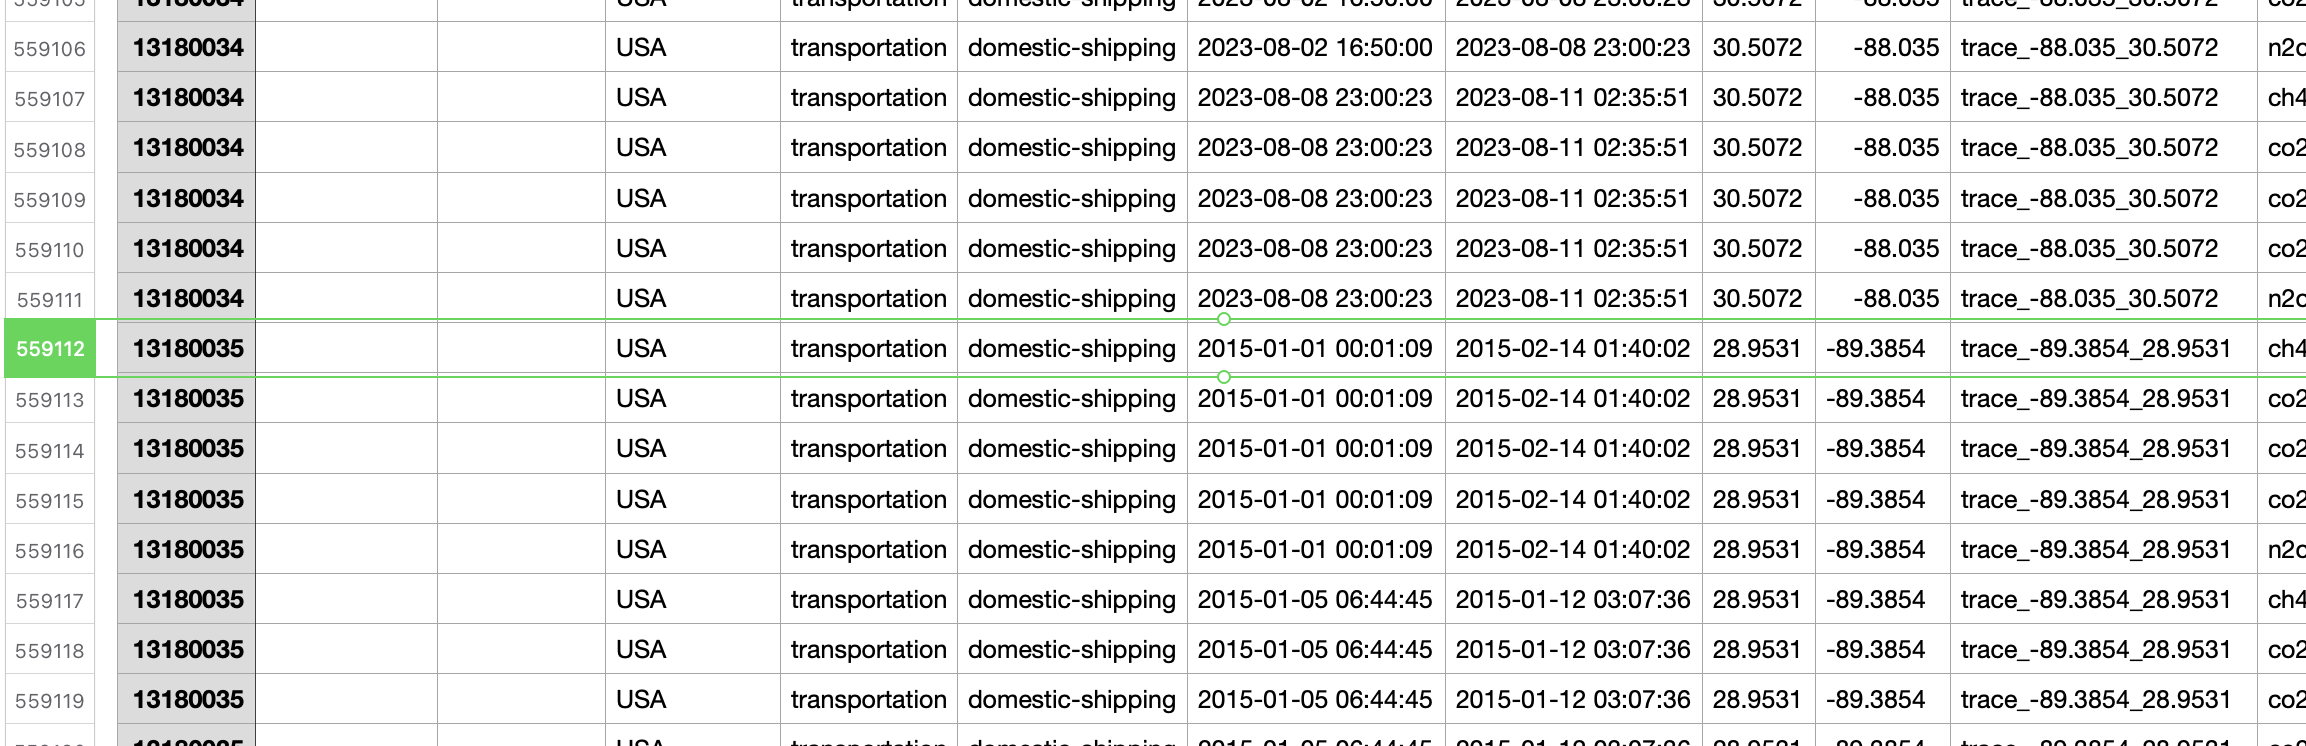

No missing data in any key column

# Add name similarity also to coordiante based matches for better evaluation

In [ ]:
import pandas as pd
import pickle
from rapidfuzz import fuzz
import re

# Preprocessing function to standardize facility and source names
def preprocess_name(name):
    """
    Standardizes a name by making it lowercase, removing special characters,
    and replacing common domain-specific abbreviations.
    """
    if not isinstance(name, str) or pd.isna(name):
        return ""  # Return an empty string for None or NaN values
    name = name.lower()  # Case insensitive
    name = re.sub(r'[^a-z0-9\s]', '', name)  # Remove special characters
    name = re.sub(r'\s+', ' ', name).strip()  # Normalize whitespace
    # Replace domain-specific abbreviations
    name = name.replace("cogen", "cogeneration")
    name = name.replace("facility", "")  # Remove redundant "facility"
    name = name.replace("plant", "")  # Remove "plant"
    return name

# Function to calculate similarity score
def calculate_similarity(row):
    """
    Calculates the similarity score between two standardized names.
    """
    ghgrp_name = preprocess_name(row['ghgrp_facility_name'])
    ct_name = preprocess_name(row['ct_source_name'])
    return fuzz.token_set_ratio(ghgrp_name, ct_name)

# Iterate through each threshold DataFrame in `cleaned_dfs`
for threshold_label, df in cleaned_dfs.items():
    # Define the path to save/load the updated file with similarity scores
    similarity_file_path = f"/content/drive/MyDrive/Master_Thesis/similarity_scores_{threshold_label}.pkl"

    if os.path.exists(similarity_file_path):
        # Load DataFrame with similarity scores if it exists
        with open(similarity_file_path, "rb") as file:
            cleaned_dfs[threshold_label] = pickle.load(file)
        print(f"Loaded similarity scores for threshold: {threshold_label}")
    else:
        # Ensure 'similarity_score' column exists and is initialized
        if 'similarity_score' not in df.columns:
            df['similarity_score'] = pd.NA

        # Calculate or update similarity scores
        df['similarity_score'] = df.apply(calculate_similarity, axis=1)

        # Save the updated DataFrame with similarity scores
        with open(similarity_file_path, "wb") as file:
            pickle.dump(cleaned_dfs[threshold_label], file)
        print(f"Similarity scores calculated and saved for threshold: {threshold_label}")

Loaded similarity scores for threshold: 5m
Loaded similarity scores for threshold: 10m
Loaded similarity scores for threshold: 15m
Loaded similarity scores for threshold: 20m
Loaded similarity scores for threshold: 25m
Loaded similarity scores for threshold: 30m
Loaded similarity scores for threshold: 35m
Loaded similarity scores for threshold: 40m
Loaded similarity scores for threshold: 45m
Loaded similarity scores for threshold: 50m
Loaded similarity scores for threshold: 75m
Loaded similarity scores for threshold: 100m
Loaded similarity scores for threshold: 500m
Loaded similarity scores for threshold: 1000m


# Evaluate match quality

In [ ]:
# Step 1: Check for duplicates across scenarios
duplicate_results = []

for threshold, df in matched_dfs.items():
    duplicate_rows = df.duplicated(subset=['ghgrp_id', 'ct_source_id', 'ghgrp_year'])
    num_duplicates = duplicate_rows.sum()
    total_rows = len(df)
    duplicates_percentage = (num_duplicates / total_rows) * 100

    # Append results for the current threshold
    duplicate_results.append({
        "Threshold": threshold,
        "Total Rows": total_rows,
        "Number of Duplicates": num_duplicates,
        "Percentage of Duplicates (%)": round(duplicates_percentage, 2)
    })

# Convert to DataFrame and display as a table
duplicate_results_df = pd.DataFrame(duplicate_results)
display(duplicate_results_df)

Threshold  Total Rows  Number of Duplicates  Percentage of Duplicates (%)
0         5m       17772                     0                           0.0
1        10m       20291                     0                           0.0
2        15m       22157                     0                           0.0
3        20m       23421                     0                           0.0
4        25m       24489                     0                           0.0
5        30m       25650                     0                           0.0
6        35m       26753                     0                           0.0
7        40m       27978                     0                           0.0
8        45m       28836                     0                           0.0
9        50m       29699                     0                           0.0
10       75m       33780                     0                           0.0
11      100m       36013                     0                           0.0
12      500m       44557                     0                           0.0
13     1000m       48815                     0                           0.0

In [ ]:
# Step 2: Compare unique GHGRP facilities matched across scenarios
facility_match_results = []

for threshold, df in matched_dfs.items():
    total_ghgrp_facilities = ghgrp_combined['ghgrp_facility_name'].nunique()
    unique_ghgrp_facilities_matched = df['ghgrp_facility_name'].nunique()
    matched_percentage = (unique_ghgrp_facilities_matched / total_ghgrp_facilities) * 100

    # Append results for the current threshold
    facility_match_results.append({
        "Threshold": threshold,
        "Total GHGRP Facilities": total_ghgrp_facilities,
        "Unique Facilities Matched": unique_ghgrp_facilities_matched,
        "Matched Percentage (%)": round(matched_percentage, 2)
    })

# Convert to DataFrame and display as a table
facility_match_results_df = pd.DataFrame(facility_match_results)
display(facility_match_results_df)

Threshold  Total GHGRP Facilities  Unique Facilities Matched  \
0         5m                    9686                       3526   
1        10m                    9686                       4072   
2        15m                    9686                       4409   
3        20m                    9686                       4611   
4        25m                    9686                       4765   
5        30m                    9686                       4917   
6        35m                    9686                       5072   
7        40m                    9686                       5225   
8        45m                    9686                       5329   
9        50m                    9686                       5428   
10       75m                    9686                       5877   
11      100m                    9686                       6133   
12      500m                    9686                       7484   
13     1000m                    9686                       8255   

    Matched Percentage (%)  
0                    36.40  
1                    42.04  
2                    45.52  
3                    47.60  
4                    49.19  
5                    50.76  
6                    52.36  
7                    53.94  
8                    55.02  
9                    56.04  
10                   60.68  
11                   63.32  
12                   77.27  
13                   85.23

In [ ]:
# Step 3: Matched rows comparison across scenarios
row_match_results = []

for threshold, df in matched_dfs.items():
    total_ghgrp_rows = len(ghgrp_combined)
    matched_ghgrp_rows = len(df)
    percentage_matched_rows = (matched_ghgrp_rows / total_ghgrp_rows) * 100

    # Append results for the current threshold
    row_match_results.append({
        "Threshold": threshold,
        "Total GHGRP Rows": total_ghgrp_rows,
        "Matched GHGRP Rows": matched_ghgrp_rows,
        "Percentage of Matched Rows (%)": round(percentage_matched_rows, 2)
    })

# Convert to DataFrame and display as a table
row_match_results_df = pd.DataFrame(row_match_results)
display(row_match_results_df)

Threshold  Total GHGRP Rows  Matched GHGRP Rows  \
0         5m             61358               17772   
1        10m             61358               20291   
2        15m             61358               22157   
3        20m             61358               23421   
4        25m             61358               24489   
5        30m             61358               25650   
6        35m             61358               26753   
7        40m             61358               27978   
8        45m             61358               28836   
9        50m             61358               29699   
10       75m             61358               33780   
11      100m             61358               36013   
12      500m             61358               44557   
13     1000m             61358               48815   

    Percentage of Matched Rows (%)  
0                            28.96  
1                            33.07  
2                            36.11  
3                            38.17  
4                            39.91  
5                            41.80  
6                            43.60  
7                            45.60  
8                            47.00  
9                            48.40  
10                           55.05  
11                           58.69  
12                           72.62  
13                           79.56

In [ ]:
# Step 4: Distribution of match percentages by year across scenarios
year_percentage_results = []

# Ensure thresholds are ordered from smallest to largest after stripping "m"
ordered_thresholds = sorted(matched_dfs.keys(), key=lambda x: int(x.replace('m', '')))

for threshold in ordered_thresholds:
    df = matched_dfs[threshold]
    year_distribution = df['ghgrp_year'].value_counts().sort_index()
    total_matches_by_year = year_distribution.sum()

    for year, count in year_distribution.items():
        percentage = (count / total_matches_by_year) * 100
        year_percentage_results.append({
            "Threshold": threshold,  # Threshold already labeled with "m"
            "Year": year,
            "Percentage of Matches (%)": round(percentage, 2)
        })

# Convert to DataFrame and display as a table
year_percentage_df = pd.DataFrame(year_percentage_results)

# Pivot the table for a cleaner display of percentages across thresholds by year
pivoted_year_percentage_df = year_percentage_df.pivot(index="Year", columns="Threshold", values="Percentage of Matches (%)")

# Ensure columns are in ascending order of numeric thresholds
pivoted_year_percentage_df = pivoted_year_percentage_df[ordered_thresholds]  # Columns already ordered

print("\nPercentage of matches by year across different distance thresholds:")
display(pivoted_year_percentage_df)


Percentage of matches by year across different distance thresholds:


Threshold     5m    10m    15m    20m    25m    30m    35m    40m    45m  \
Year                                                                       
2015        8.41   8.60   8.85   9.07   9.27   9.57   9.77  10.05  10.26   
2016        8.33   8.42   8.62   8.80   8.99   9.20   9.41   9.64   9.79   
2017        8.24   8.34   8.55   8.73   8.89   9.08   9.27   9.49   9.62   
2018        8.37   8.47   8.66   8.86   9.01   9.19   9.38   9.59   9.73   
2019       15.42  14.88  14.61  14.42  14.31  14.21  14.13  14.04  13.99   
2020       15.14  14.64  14.38  14.21  14.12  14.03  13.96  13.88  13.85   
2021       18.08  18.35  18.21  17.98  17.73  17.39  17.06  16.67  16.40   
2022       18.01  18.30  18.13  17.92  17.69  17.34  17.02  16.63  16.36   

Threshold    50m    75m   100m   500m  1000m  
Year                                          
2015       10.44  11.18  11.54  12.29  12.22  
2016        9.93  10.54  10.80  11.31  11.36  
2017        9.76  10.36  10.60  11.16  11.22  
2018        9.87  10.46  10.70  11.22  11.32  
2019       13.96  13.83  13.78  13.62  13.57  
2020       13.82  13.69  13.67  13.51  13.49  
2021       16.13  14.99  14.48  13.48  13.48  
2022       16.09  14.93  14.42  13.40  13.36

In [ ]:
# Step 5: Climate TRACE subsector distribution across scenarios
sector_percentage_results = []

# Ensure thresholds are ordered from smallest to largest
ordered_thresholds = sorted(matched_dfs.keys(), key=lambda x: int(x.replace("m", "")))

for threshold in ordered_thresholds:
    df = matched_dfs[threshold]
    sector_distribution = df['ct_subsector'].value_counts()
    total_matches = sector_distribution.sum()  # Total matches for this threshold
    total_sector_counts = climate_trace_combined['ct_subsector'].value_counts()

    for sector, count in sector_distribution.items():
        # Percentage of total subsector matched
        total_percentage = (count / total_sector_counts.get(sector, 1)) * 100
        # Contribution of this subsector's matches to overall matches for this threshold
        matched_percentage = (count / total_matches) * 100
        sector_percentage_results.append({
            "Threshold": threshold,
            "Subsector": sector,
            "Percentage of Total Subsector (%)": round(total_percentage, 2),
            "Contribution to Overall Matches (%)": round(matched_percentage, 2)
        })

# Convert to DataFrame and display as a table
sector_percentage_df = pd.DataFrame(sector_percentage_results)

# Pivot the table for a cleaner display across thresholds by subsector
pivoted_sector_percentage_df = sector_percentage_df.pivot(index="Subsector", columns="Threshold",
                                                          values=["Percentage of Total Subsector (%)",
                                                                  "Contribution to Overall Matches (%)"])

# Reorder columns based on `ordered_thresholds`
pivoted_sector_percentage_df = pivoted_sector_percentage_df.reindex(columns=ordered_thresholds, level=1)

print("\nClimate TRACE subsector distribution across different distance thresholds (ordered by threshold):")
display(pivoted_sector_percentage_df)


Climate TRACE subsector distribution across different distance thresholds (ordered by threshold):


Percentage of Total Subsector (%)         \
Threshold                                                         5m    10m   
Subsector                                                                     
aluminum                                                       57.41  77.78   
cement                                                         75.21  78.51   
coal-mining                                                     2.22   4.09   
copper-mining                                                    NaN    NaN   
domestic-aviation                                               0.22   0.39   
domestic-shipping                                               0.24   0.62   
electricity-generation                                         56.99  61.37   
international-aviation                                          0.24   0.52   
international-shipping                                          0.10   0.66   
iron-mining                                                      NaN    NaN   
oil-and-gas-refining                                           35.87  45.96   
other-manufacturing                                            73.60  78.88   
petrochemicals                                                 23.90  54.04   
road-transportation                                             0.48   1.45   
solid-waste-disposal                                           25.56  36.23   
steel                                                          50.37  59.11   
wastewater-treatment-and-discharge                              0.24   0.70   

                                                                              \
Threshold                             15m    20m    25m    30m    35m    40m   
Subsector                                                                      
aluminum                            62.96  62.96  62.96  62.96  62.96  62.96   
cement                              78.63  81.56  81.93  82.42  82.54  83.52   
coal-mining                          5.80   6.87   7.33   7.33   7.67   8.74   
copper-mining                        2.63   2.63   2.63   2.63   2.63   2.63   
domestic-aviation                    0.69   0.78   1.20   1.57   1.90   2.17   
domestic-shipping                    1.03   2.53   2.90   3.10   3.16   3.36   
electricity-generation              62.73  63.64  64.66  65.09  65.24  65.54   
international-aviation               0.75   1.11   1.41   1.80   2.20   2.56   
international-shipping               0.86   2.54   2.77   3.16   3.29   3.62   
iron-mining                           NaN    NaN    NaN    NaN    NaN    NaN   
oil-and-gas-refining                48.46  49.13  51.44  55.58  71.73  86.92   
other-manufacturing                 82.56  84.69  86.07  87.51  88.58  89.40   
petrochemicals                      70.22  66.91  66.54  65.44  66.91  66.91   
road-transportation                  3.07   4.12   5.25   5.89   6.78   7.43   
solid-waste-disposal                41.43  43.86  45.18  46.29  47.47  48.18   
steel                               69.78  70.96  72.15  75.70  76.59  78.67   
wastewater-treatment-and-discharge   1.35   1.83   2.34   2.97   3.51   4.17   

                                                  ...  \
Threshold                             45m    50m  ...   
Subsector                                         ...   
aluminum                            62.96  62.96  ...   
cement                              83.64  84.25  ...   
coal-mining                          9.02   9.48  ...   
copper-mining                        2.63   2.63  ...   
domestic-aviation                    2.39   2.63  ...   
domestic-shipping                    3.78   3.85  ...   
electricity-generation              65.66  65.68  ...   
international-aviation               2.77   3.05  ...   
international-shipping               3.29   3.39  ...   
iron-mining                           NaN    NaN  ...   
oil-and-gas-refining                88.46  90.38  ...   
other-manufacturing                 90.45  91.23  ...  

In [ ]:
# Step 6: GHGRP state distribution across scenarios
state_percentage_results = []

# Ensure thresholds are ordered from smallest to largest
ordered_thresholds = sorted(matched_dfs.keys(), key=lambda x: int(x.replace("m", "")))

for threshold in ordered_thresholds:
    df = matched_dfs[threshold]
    state_distribution = df['ghgrp_STATE'].value_counts()
    total_matches = state_distribution.sum()  # Total matches for this threshold
    total_state_counts = ghgrp_combined['ghgrp_STATE'].value_counts()

    for state, count in state_distribution.items():
        # Percentage of total state matched
        total_percentage = (count / total_state_counts.get(state, 1)) * 100
        # Contribution of this state's matches to overall matches for this threshold
        matched_percentage = (count / total_matches) * 100
        state_percentage_results.append({
            "Threshold": threshold,
            "State": state,
            "Percentage of Total State (%)": round(total_percentage, 2),
            "Contribution to Overall Matches (%)": round(matched_percentage, 2)
        })

# Convert to DataFrame and display as a table
state_percentage_df = pd.DataFrame(state_percentage_results)

# Pivot the table for a cleaner display across thresholds by state
pivoted_state_percentage_df = state_percentage_df.pivot(index="State", columns="Threshold",
                                                        values=["Percentage of Total State (%)",
                                                                "Contribution to Overall Matches (%)"])

# Reorder columns based on `ordered_thresholds`
pivoted_state_percentage_df = pivoted_state_percentage_df.reindex(columns=ordered_thresholds, level=1)

print("\nGHGRP state distribution across different distance thresholds (ordered by threshold):")
display(pivoted_state_percentage_df)


GHGRP state distribution across different distance thresholds (ordered by threshold):


Percentage of Total State (%)                                     \
Threshold                            5m    10m    15m    20m    25m    30m   
State                                                                        
AK                                15.15  19.06  25.08  26.38  27.04  30.29   
AL                                38.81  42.68  44.89  49.24  51.59  54.63   
AR                                34.33  39.86  41.71  43.66  45.05  46.20   
AZ                                26.36  28.89  31.82  34.49  35.82  36.88   
CA                                35.42  39.38  42.61  43.78  46.46  49.71   
CO                                11.67  13.79  14.61  15.32  15.87  16.09   
CT                                37.05  42.06  44.29  48.75  49.86  51.81   
DC                                24.39  24.39  29.27  48.78  58.54  58.54   
DE                                34.50  39.77  47.95  47.95  59.06  59.06   
FL                                35.85  40.12  43.45  45.62  46.10  46.57   
GA                                35.49  39.21  42.78  46.35  48.44  50.37   
GU                                 3.28   3.28   3.28   3.28   3.28   3.28   
HI                                38.22  50.67  56.44  59.11  65.33  69.78   
IA                                33.49  36.80  43.89  46.10  50.91  53.19   
ID                                41.88  47.73  47.73  48.38  48.70  51.95   
IL                                36.81  41.61  46.45  50.25  52.30  54.55   
IN                                41.27  47.90  53.86  56.79  57.58  59.53   
KS                                30.62  34.69  36.51  36.51  38.54  40.69   
KY                                34.98  40.09  46.70  48.37  48.63  50.75   
LA                                21.09  25.40  27.65  30.02  30.38  31.64   
MA                                35.71  40.48  45.24  46.67  48.57  50.95   
MD                                21.80  31.60  35.20  36.00  39.60  45.40   
ME                                24.19  28.84  32.56  32.56  36.74  40.47   
MI                                38.92  43.46  46.38  49.03  50.43  55.03   
MN                                28.72  30.92  33.49  35.32  37.25  38.17   
MO                                41.67  43.72  47.51  49.57  53.35  55.84   
MS                                26.64  28.19  30.08  30.97  31.19  32.85   
MT                                42.59  47.91  53.99  53.99  53.99  54.37   
NC                                43.25  47.03  50.05  51.84  54.86  56.85   
ND                                17.69  18.74  19.44  21.19  23.99  27.67   
NE                                25.32  28.57  32.95  38.15  41.40  44.97   
NH                                38.85  38.85  41.73  47.48  47.48  58.27   
NJ                                37.05  47.15  49.22  52.33  54.15  57.38   
NM                                16.60  18.35  21.85  22.35  22.35  22.47   
NV                                30.92  34.82  36.49  39.00  42.06  44.01   
NY                                32.71  38.16  40.94  46.17  49.29  51.28   
OH                                40.65  47.04  51.98  53.94  56.74  58.23   
OK                                13.20  16.69  17.72  19.10  20.53  22.34   
OR                                31.57  38.14  39.83  40.68  42.16  46.82   
PA                                27.13  32.51  36.02  38.67  42.26  44.30   
PR                                 4.81   6.42   8.56   8.56  11.23  15.51   
RI                                35.96  35.96  37.08  50.56  52.81  52.81   
SC                                45.88  51.25  57.38  60.50  63.50  65.00   
SD                                20.49  25.09  25.80  26.15  26.15  36.40   
TN                                35.96  42.76  48.01  51.02  51.21  53.16   
TX                                18.76  21.24  22.78  23.62  23.88  24.45   
UT                                28.12  31.79  32.59  34.50  37.70  38.98   
VA                                32.00  36.79  39.67  41.06  44.46  45.34   
VI                              

In [ ]:
# Step 7: Summary statistics for matching distance across scenarios
distance_stats_results = []

# Ensure thresholds are ordered from smallest to largest
ordered_thresholds = sorted(matched_dfs.keys(), key=lambda x: int(x.replace("m", "")))

for threshold in ordered_thresholds:
    df = matched_dfs[threshold]
    # Calculate summary statistics for distance
    distance_stats = df['distance'].describe()
    distance_stats_results.append(distance_stats.rename(threshold))

# Combine distance statistics into a single DataFrame for comparison
distance_stats_df = pd.DataFrame(distance_stats_results)
distance_stats_df.index.name = "Threshold"  # Set index name for clarity

print("\nSummary statistics for matching distance (in km) across thresholds (ordered by threshold):")
display(distance_stats_df)


Summary statistics for matching distance (in km) across thresholds (ordered by threshold):


count      mean       std  min       25%       50%       75%  \
Threshold                                                                   
5m         17772.0  0.000874  0.001324  0.0  0.000000  0.000000  0.001364   
10m        20291.0  0.001702  0.002550  0.0  0.000000  0.000283  0.002581   
15m        22157.0  0.002624  0.003880  0.0  0.000000  0.000562  0.003846   
20m        23421.0  0.003457  0.005111  0.0  0.000000  0.000781  0.004935   
25m        24489.0  0.004304  0.006365  0.0  0.000000  0.000950  0.006339   
30m        25650.0  0.005389  0.007920  0.0  0.000000  0.001204  0.008062   
35m        26753.0  0.006562  0.009523  0.0  0.000000  0.001432  0.009854   
40m        27978.0  0.007949  0.011291  0.0  0.000000  0.001803  0.012302   
45m        28836.0  0.009027  0.012645  0.0  0.000000  0.002094  0.013849   
50m        29699.0  0.010184  0.014082  0.0  0.000000  0.002433  0.016341   
75m        33780.0  0.016845  0.022170  0.0  0.000000  0.004349  0.029734   
100m       36013.0  0.021408  0.027449  0.0  0.000000  0.006247  0.037195   
500m       44557.0  0.065696  0.098205  0.0  0.000722  0.025345  0.086701   
1000m      48815.0  0.136353  0.223260  0.0  0.001300  0.044642  0.145807   

                max  
Threshold            
5m         0.004996  
10m        0.009996  
15m        0.014975  
20m        0.019998  
25m        0.024960  
30m        0.029995  
35m        0.034982  
40m        0.039985  
45m        0.044997  
50m        0.049989  
75m        0.074947  
100m       0.099996  
500m       0.499977  
1000m      0.999852

In [ ]:
# Step 8: Summary statistics for similarity score across scenarios
similarity_stats_results = []

for threshold_label, df in cleaned_dfs.items():
    # Collect similarity score statistics for each threshold
    similarity_stats = df['similarity_score'].describe()
    similarity_stats.name = threshold_label  # Label for clarity in aggregation
    similarity_stats_results.append(similarity_stats)

# Combine similarity statistics for comparison across thresholds
similarity_stats_df = pd.DataFrame(similarity_stats_results)

# Display the table of similarity statistics
display(similarity_stats_df)

count       mean        std  min         25%         50%    75%  \
5m     17772.0  92.394559  18.471771  0.0  100.000000  100.000000  100.0   
10m    20291.0  89.864999  21.475792  0.0  100.000000  100.000000  100.0   
15m    22157.0  87.365368  23.750358  0.0   87.323944  100.000000  100.0   
20m    23421.0  85.485425  25.261661  0.0   77.777778  100.000000  100.0   
25m    24489.0  83.772159  26.550954  0.0   70.588235  100.000000  100.0   
30m    25650.0  82.050658  27.599880  0.0   63.157895  100.000000  100.0   
35m    26753.0  80.468885  28.453073  0.0   57.142857  100.000000  100.0   
40m    27978.0  78.777448  29.313287  0.0   50.704225  100.000000  100.0   
45m    28836.0  77.629275  29.831617  0.0   45.833333  100.000000  100.0   
50m    29699.0  76.502603  30.297856  0.0   42.105263  100.000000  100.0   
75m    33780.0  72.017749  31.524971  0.0   36.619718  100.000000  100.0   
100m   36013.0  70.159969  31.864881  0.0   35.294118   84.210526  100.0   
500m   44557.0  63.643965  31.685382  0.0   33.333333   54.545455  100.0   
1000m  48815.0  60.909648  31.142067  0.0   33.333333   46.153846  100.0   

         max  
5m     100.0  
10m    100.0  
15m    100.0  
20m    100.0  
25m    100.0  
30m    100.0  
35m    100.0  
40m    100.0  
45m    100.0  
50m    100.0  
75m    100.0  
100m   100.0  
500m   100.0  
1000m  100.0

# Deciding which km threshold delivers the best results


Final Evaluation Results (average across all weight combinations):


Threshold  Median Distance  Median Similarity  Match Percentage (%)  \
10       75m         0.004349         100.000000             55.053946   
9        50m         0.002433         100.000000             48.402816   
8        45m         0.002094         100.000000             46.996317   
7        40m         0.001803         100.000000             45.597966   
6        35m         0.001432         100.000000             43.601486   
5        30m         0.001204         100.000000             41.803840   
4        25m         0.000950         100.000000             39.911666   
3        20m         0.000781         100.000000             38.171062   
2        15m         0.000562         100.000000             36.111021   
11      100m         0.006247          84.210526             58.693243   
1        10m         0.000283         100.000000             33.069852   
0         5m         0.000000         100.000000             28.964438   
12      500m         0.025345          54.545455             72.618078   
13     1000m         0.044642          46.153846             79.557678   

    Average Overall Score  
10               0.864863  
9                0.851299  
8                0.847935  
7                0.844253  
6                0.838659  
5                0.832826  
4                0.826793  
3                0.820765  
2                0.813769  
11               0.813305  
1                0.803109  
0                0.788023  
12               0.630166  
13               0.487179

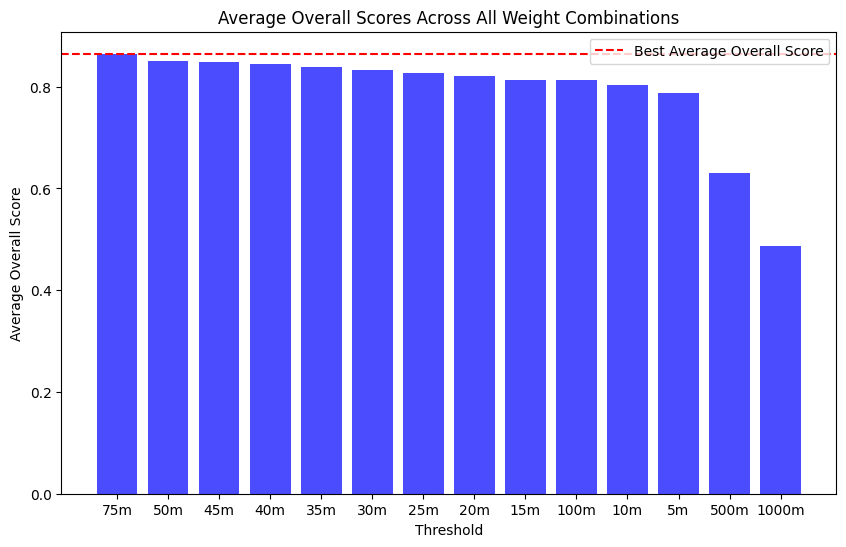

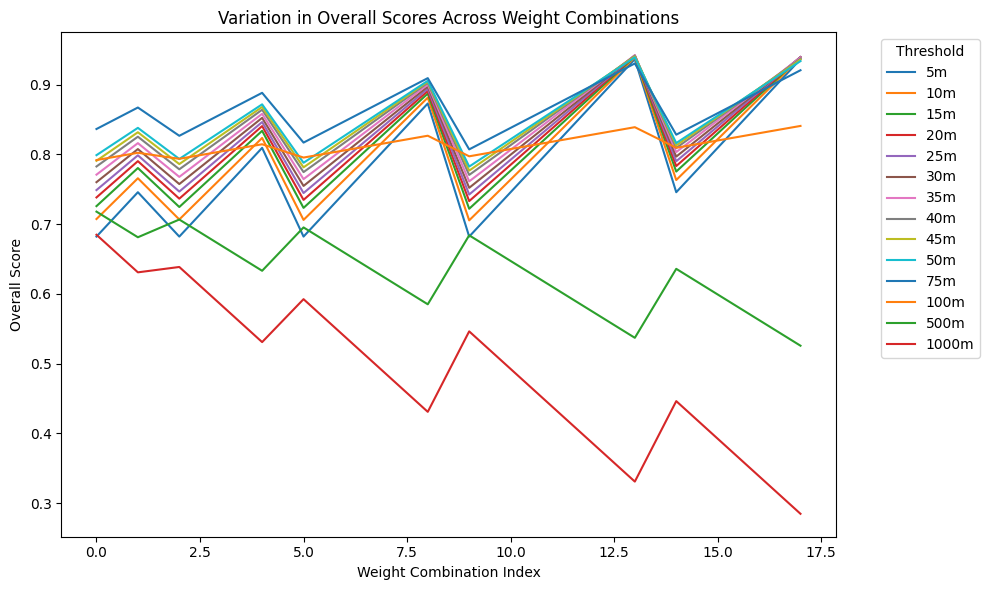


Best Thresholds for Different Weight Combinations:


Weights Best Threshold  Max Score
0   (0.1, 0.4, 0.5)            75m   0.836259
1   (0.1, 0.5, 0.4)            75m   0.867059
2   (0.2, 0.3, 0.5)            75m   0.826518
3   (0.2, 0.4, 0.4)            75m   0.857318
4   (0.2, 0.5, 0.3)            75m   0.888118
5   (0.3, 0.2, 0.5)            75m   0.816777
6   (0.3, 0.3, 0.4)            75m   0.847577
7   (0.3, 0.4, 0.3)            75m   0.878377
8   (0.3, 0.5, 0.2)            75m   0.909177
9   (0.4, 0.1, 0.5)            75m   0.807036
10  (0.4, 0.2, 0.4)            75m   0.837836
11  (0.4, 0.3, 0.3)            75m   0.868636
12  (0.4, 0.4, 0.2)            50m   0.899879
13  (0.4, 0.5, 0.1)            35m   0.941976
14  (0.5, 0.1, 0.4)            75m   0.828095
15  (0.5, 0.2, 0.3)            75m   0.858895
16  (0.5, 0.3, 0.2)            45m   0.894687
17  (0.5, 0.4, 0.1)            25m   0.939521


Best threshold overall (highest average score): 75m


In [ ]:
# Define weight combinations (step of 0.1)
weights = [0.1, 0.2, 0.3, 0.4, 0.5]
weight_combinations = list(itertools.product(weights, repeat=3))
weight_combinations = [wc for wc in weight_combinations if sum(wc) == 1.0]  # Only valid combinations summing to 1

# Initialize results container
evaluation_results = []
weighting_results = []

# Iterate through thresholds and collect metrics
for threshold_label, df in cleaned_dfs.items():
    # Compute metrics
    median_distance = df['distance'].median() if 'distance' in df else None
    median_similarity = df['similarity_score'].median() if 'similarity_score' in df else None
    total_rows = len(ghgrp_combined)
    matched_rows = len(df)
    match_percentage = (matched_rows / total_rows) * 100 if total_rows > 0 else 0

    # Add to results
    evaluation_results.append({
        "Threshold": threshold_label,
        "Median Distance": median_distance,
        "Median Similarity": median_similarity,
        "Match Percentage (%)": match_percentage
    })

# Convert to DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# Normalize metrics for unified comparison (all scores between 0 and 1)
evaluation_df['Normalized Distance'] = 1 - (evaluation_df['Median Distance'] / evaluation_df['Median Distance'].max())
evaluation_df['Normalized Similarity'] = evaluation_df['Median Similarity'] / evaluation_df['Median Similarity'].max()
evaluation_df['Normalized Match Percentage'] = evaluation_df['Match Percentage (%)'] / evaluation_df['Match Percentage (%)'].max()

# Calculate overall scores for each weight combination
for weights in weight_combinations:
    weight_distance, weight_similarity, weight_match = weights

    evaluation_df[f'Overall Score ({weights})'] = (
        evaluation_df['Normalized Distance'] * weight_distance +
        evaluation_df['Normalized Similarity'] * weight_similarity +
        evaluation_df['Normalized Match Percentage'] * weight_match
    )

    # Append the best threshold for this weight combination
    best_threshold = evaluation_df.loc[evaluation_df[f'Overall Score ({weights})'].idxmax()]['Threshold']
    weighting_results.append({
        "Weights": weights,
        "Best Threshold": best_threshold,
        "Max Score": evaluation_df[f'Overall Score ({weights})'].max()
    })

# Aggregate results across weight combinations
weighting_df = pd.DataFrame(weighting_results)

# Calculate the average overall score for each threshold across all weightings
evaluation_df['Average Overall Score'] = evaluation_df[
    [f'Overall Score ({weights})' for weights in weight_combinations]
].mean(axis=1)

# Sort the first table by "Average Overall Score" in descending order
final_table = evaluation_df[['Threshold', 'Median Distance', 'Median Similarity', 'Match Percentage (%)', 'Average Overall Score']]
final_table = final_table.sort_values(by='Average Overall Score', ascending=False)

# Display the final table
print("\nFinal Evaluation Results (average across all weight combinations):")
display(final_table)

# Visualization 1: Average Overall Scores Across Thresholds
plt.figure(figsize=(10, 6))
plt.bar(final_table['Threshold'], final_table['Average Overall Score'], color='blue', alpha=0.7)
plt.title("Average Overall Scores Across All Weight Combinations")
plt.ylabel("Average Overall Score")
plt.xlabel("Threshold")
plt.axhline(y=final_table['Average Overall Score'].max(), color='red', linestyle='--', label='Best Average Overall Score')
plt.legend()
plt.show()

# Visualization 2: Variation in Scores Across Weight Combinations
plt.figure(figsize=(10, 6))
for threshold_label in evaluation_df['Threshold']:
    threshold_scores = [
        evaluation_df.loc[evaluation_df['Threshold'] == threshold_label, f'Overall Score ({weights})'].values[0]
        for weights in weight_combinations
    ]
    plt.plot(threshold_scores, label=threshold_label)

plt.title("Variation in Overall Scores Across Weight Combinations")
plt.xlabel("Weight Combination Index")
plt.ylabel("Overall Score")
plt.legend(title="Threshold", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display the weighting results
print("\nBest Thresholds for Different Weight Combinations:")
display(weighting_df)

print(f"\nBest threshold overall (highest average score): {final_table.iloc[0]['Threshold']}")

# Investigate outliers

Checking the outliers of emissions_discrepancy to check if they're matched correctly

Note: most large discrepancies are in the electricity-generation subsector

In [ ]:
# After manually checking top 1% highest and lowest 1% emissions discrepancies manually
# These matches appear incorrect and will be dropped, total of 15
rows_to_drop = [
    ('1005668', 2021),
    ('1005668', 2019),
    ('1005668', 2022),
    ('1005668', 2018),
    ('1005668', 2019),
    ('1005668', 2022),
    ('1005668', 2015),
    ('1005668', 2017),
    ('1005668', 2016),
    ('1013813', 2020),
    ('1001984', 2020),
    ('1001984', 2017),
    ('1001984', 2016),
    ('1001984', 2015),
    ('1001984', 2022),
]

# Convert the DataFrame to a boolean mask based on the condition
filtered_df = matched_dfs["5m"][~matched_dfs["5m"].apply(
    lambda row: (row['ghgrp_id'], row['ghgrp_year']) in rows_to_drop, axis=1
)]

# Calculate GHG differences

From the CT *about_the_data.pdf*: "Quantity of gas emitted in metric tonnes."

GHG data given in "GHG QUANTITY (METRIC TONS CO2e)"

In [ ]:
# Define the list of thresholds to remove
# only keeping 5m as its the most conservative and 50m as it was shown to hold the best matches
thresholds_to_remove = ['10m', '15m', '20m', '25m', '30m', '35m', '40m', '45m', '75m', '500m', '100m', '1000m']

# Remove the specified thresholds from matched_dfs
for threshold in thresholds_to_remove:
  if threshold in matched_dfs:
    del matched_dfs[threshold]

print(matched_dfs.keys())

dict_keys(['5m', '50m'])


In [ ]:
# Calculate the emissions discrepancy and percentage discrepancy across scenarios
for threshold, df in matched_dfs.items():
    # Exclude rows where GHGRP emissions are zero
    df = df[df['ghgrp_emissions_tons'] > 0].copy()

    # Calculate the emissions discrepancy directly in tons
    df['emissions_discrepancy'] = df['ghgrp_emissions_tons'] - df['ct_emissions_quantity']

    # Separate rows with zero discrepancy for potential later analysis
    df['zero_discrepancy_flag'] = df['emissions_discrepancy'] == 0

    # Calculate the percentage discrepancy relative to GHGRP
    df['emissions_percentage_discrepancy'] = np.where(
        df['ghgrp_emissions_tons'] > 0,
        (df['emissions_discrepancy'] / df['ghgrp_emissions_tons']) * 100,
        np.nan
    )

    # Calculate total emissions for each `ghgrp_subparts` category
    ghgrp_subparts_emissions = df.groupby('ghgrp_subparts')['ghgrp_emissions_tons'].sum()

    # Map the total emissions of the corresponding category to each row
    df['ghgrp_subparts_total_emissions'] = df['ghgrp_subparts'].map(ghgrp_subparts_emissions)

    # Compute the weighted percentage discrepancy
    df['weighted_percentage_discrepancy'] = np.where(
        (df['ghgrp_emissions_tons'] > 0) & (df['ghgrp_subparts_total_emissions'] > 0),
        (
            (df['emissions_discrepancy'] / df['ghgrp_emissions_tons']) * 100 *
            (df['ghgrp_emissions_tons'] / df['ghgrp_subparts_total_emissions'])
        ),
        np.nan
    )

    # Update the original DataFrame
    matched_dfs[threshold] = df

# Print a summary of changes for validation
for threshold, df in matched_dfs.items():
    print(f"\nThreshold: {threshold}")
    print(f"Rows after filtering: {len(df)}")
    print(f"Rows with zero emissions discrepancy: {df['zero_discrepancy_flag'].sum()}")
    print(f"Rows with NaN or -inf in percentage discrepancy: {df['emissions_percentage_discrepancy'].isna().sum()}")
    print(f"Rows with NaN or -inf in weighted discrepancy: {df['weighted_percentage_discrepancy'].isna().sum()}")


Threshold: 5m
Rows after filtering: 17767
Rows with zero emissions discrepancy: 275
Rows with NaN or -inf in percentage discrepancy: 0
Rows with NaN or -inf in weighted discrepancy: 0

Threshold: 50m
Rows after filtering: 29689
Rows with zero emissions discrepancy: 341
Rows with NaN or -inf in percentage discrepancy: 0
Rows with NaN or -inf in weighted discrepancy: 0


In [ ]:
# Calculate and display the median and mean percentage and weighted percentage discrepancies for each threshold
discrepancies_summary = {
    threshold: {
        'Median Absolute Discrepancy (tons)': df['emissions_discrepancy'].median(),
        'Mean Absolute Discrepancy (tons)': df['emissions_discrepancy'].mean(),
        'Median Percentage Discrepancy': df['emissions_percentage_discrepancy'].median(),
        'Mean Percentage Discrepancy': df['emissions_percentage_discrepancy'].mean(),
    }
    for threshold, df in matched_dfs.items()
}

# Convert the discrepancies summary to a DataFrame
discrepancies_summary_df = pd.DataFrame(discrepancies_summary).T

# Display the results
print("\nSummary of percentage, weighted percentage, and absolute discrepancies (Median and Mean) across all data by scenario:")
display(discrepancies_summary_df)


Summary of percentage, weighted percentage, and absolute discrepancies (Median and Mean) across all data by scenario:


Median Absolute Discrepancy (tons)  Mean Absolute Discrepancy (tons)  \
5m                             -2.17511                      56865.890669   
50m                            -1.15372                      39457.515923   

     Median Percentage Discrepancy  Mean Percentage Discrepancy  
5m                       -0.004394                 -2328.714849  
50m                      -0.003529                 -4967.442806

In [ ]:
# Calculate and display median and mean percentage and weighted percentage discrepancies by subsector
subsector_discrepancies = {}

for threshold, df in matched_dfs.items():
    subsector_stats = (
        df.groupby('ct_subsector')[['emissions_percentage_discrepancy', 'weighted_percentage_discrepancy']]
        .agg(['median', 'mean'])  # Calculate both median and mean
        .reset_index()
    )

    # Flatten MultiIndex columns and rename them to include the threshold
    subsector_stats.columns = ['ct_subsector'] + [
        f"{threshold} ({agg_type.capitalize()} {col.replace('_', ' ')})"
        for col, agg_type in subsector_stats.columns[1:]  # Skip the first column (ct_subsector)
    ]

    subsector_discrepancies[threshold] = subsector_stats

# Combine subsector results across scenarios for comparison
subsector_discrepancy_df = subsector_discrepancies[list(matched_dfs.keys())[0]]  # Get the first key of matched_dfs
for threshold in list(matched_dfs.keys())[1:]:  # Iterate over remaining keys of matched_dfs
    subsector_discrepancy_df = pd.merge(subsector_discrepancy_df, subsector_discrepancies[threshold], on='ct_subsector', how='outer')

subsector_discrepancy_df = subsector_discrepancy_df.set_index('ct_subsector')

# Display the results
print("\nMedian and Mean percentage and weighted percentage discrepancy by subsector across scenarios:")
display(subsector_discrepancy_df)


Median and Mean percentage and weighted percentage discrepancy by subsector across scenarios:


5m (Median emissions percentage discrepancy)  \
ct_subsector                                                                       
aluminum                                                                5.187823   
cement                                                                  1.527267   
coal-mining                                                          -281.352177   
copper-mining                                                                NaN   
domestic-aviation                                                     -91.426406   
domestic-shipping                                                      99.621763   
electricity-generation                                                -14.317519   
international-aviation                                                100.000000   
international-shipping                                                 91.778589   
oil-and-gas-refining                                                  -30.215502   
other-manufacturing                                                    -0.004316   
petrochemicals                                                        -10.730585   
road-transportation                                                  -688.555052   
solid-waste-disposal                                                  -11.990325   
steel                                                                 -28.851931   
wastewater-treatment-and-discharge                                     98.852693   

                                    5m (Mean emissions percentage discrepancy)  \
ct_subsector                                                                     
aluminum                                                            -27.420255   
cement                                                            -3104.065274   
coal-mining                                                       -6715.934189   
copper-mining                                                              NaN   
domestic-aviation                                                 -8387.576428   
domestic-shipping                                                    95.574940   
electricity-generation                                            -7230.567927   
international-aviation                                            -7437.499707   
international-shipping                                               92.889645   
oil-and-gas-refining                                              -1832.815870   
other-manufacturing                                                -162.577334   
petrochemicals                                                     -393.838961   
road-transportation                                                -611.857679   
solid-waste-disposal                                                -36.096444   
steel                                                              -178.406715   
wastewater-treatment-and-discharge                                  -11.002417   

                                    5m (Median weighted percentage discrepancy)  \
ct_subsector                                                                      
aluminum                                                           1.445345e-01   
cement                                                             1.067965e-03   
coal-mining                                                       -7.059816e-01   
copper-mining                                                               NaN   
domestic-aviation                                                 -1.589591e-02   
domestic-shipping                                                  1.147593e-02   
electricity-generation                                            -1.341562e-03   
international-aviation                                             1.261975e-02   
international-shipping                                             5.874996e+00   
oil-and-gas-refining                                              -3.838324e-02   
other-manufacturing                               

In [ ]:
# Calculate and display median and mean percentage and weighted percentage discrepancies by year
year_discrepancies = {}

for threshold, df in matched_dfs.items():
    year_stats = (
        df.groupby('ghgrp_year')[['emissions_percentage_discrepancy', 'weighted_percentage_discrepancy']]
        .agg(['median', 'mean'])  # Calculate both median and mean
        .reset_index()
    )

    # Flatten MultiIndex columns and rename them to include the threshold
    year_stats.columns = ['ghgrp_year'] + [
        f"{threshold} ({agg_type.capitalize()} {col.replace('_', ' ')})"
        for col, agg_type in year_stats.columns[1:]  # Skip the first column (ghgrp_year)
    ]

    year_discrepancies[threshold] = year_stats

# Combine year results across scenarios for comparison
year_discrepancy_df = year_discrepancies[list(matched_dfs.keys())[0]]  # Get the first key of matched_dfs
for threshold in list(matched_dfs.keys())[1:]:  # Iterate over remaining keys of matched_dfs
    year_discrepancy_df = pd.merge(year_discrepancy_df, year_discrepancies[threshold], on='ghgrp_year', how='outer')

year_discrepancy_df = year_discrepancy_df.set_index('ghgrp_year')

# Display the results
print("\nMedian and Mean percentage and weighted percentage discrepancy by year across scenarios:")
display(year_discrepancy_df)


Median and Mean percentage and weighted percentage discrepancy by year across scenarios:


5m (Median emissions percentage discrepancy)  \
ghgrp_year                                                 
2015                                           -0.004329   
2016                                           -0.004366   
2017                                           -0.004332   
2018                                           -0.004327   
2019                                           -0.004369   
2020                                           -0.004370   
2021                                           -0.005645   
2022                                           -1.347508   

            5m (Mean emissions percentage discrepancy)  \
ghgrp_year                                               
2015                                        -81.968148   
2016                                       -506.825169   
2017                                       -198.199453   
2018                                       -224.598149   
2019                                      -7458.398072   
2020                                       -363.322798   
2021                                       -806.129668   
2022                                      -4965.030348   

            5m (Median weighted percentage discrepancy)  \
ghgrp_year                                                
2015                                      -3.505568e-07   
2016                                      -3.697099e-07   
2017                                      -3.565190e-07   
2018                                      -3.392938e-07   
2019                                      -3.776015e-07   
2020                                      -3.675183e-07   
2021                                      -8.386993e-07   
2022                                      -1.258882e-04   

            5m (Mean weighted percentage discrepancy)  \
ghgrp_year                                              
2015                                        -2.359801   
2016                                        -2.989537   
2017                                        -3.041332   
2018                                        -3.138026   
2019                                        -1.517258   
2020                                         0.109356   
2021                                         0.087050   
2022                                         0.112270   

            50m (Median emissions percentage discrepancy)  \
ghgrp_year                                                  
2015                                            -0.000097   
2016                                            -0.001253   
2017                                            -0.000871   
2018                                            -0.000752   
2019                                            -0.003232   
2020                                            -0.003104   
2021                                            -0.006083   
2022                                            -0.580001   

            50m (Mean emissions percentage discrepancy)  \
ghgrp_year                                                
2015                                      -22769.153869   
2016                                       -1964.985485   
2017                                        -706.550889   
2018                                       -5548.814363   
2019                                       -5182.802411   
2020                                        -768.860410   
2021                                       -1097.798117   
2022                                       -4783.471288   

            50m (Median weighted percentage discrepancy)  \
ghgrp_year                                                 
2015                                       -5.592089e-09   
2016                                       -6.558555e-08   
2017                                       -4.497757e-08   
2018                                       -4.068624e-08   
2019                                       -1.062718e-07   
2020                                       -1.

In [ ]:
# Calculate and display median and mean percentage and weighted percentage discrepancies by state
state_discrepancies = {}

for threshold, df in matched_dfs.items():
    state_stats = (
        df.groupby('ghgrp_STATE')[['emissions_percentage_discrepancy', 'weighted_percentage_discrepancy']]
        .agg(['median', 'mean'])  # Calculate both median and mean
        .reset_index()
    )

    # Flatten MultiIndex columns and rename them to include the threshold
    state_stats.columns = ['ghgrp_STATE'] + [
        f"{threshold} ({agg_type.capitalize()} {col.replace('_', ' ')})"
        for col, agg_type in state_stats.columns[1:]  # Skip the first column (ghgrp_STATE)
    ]

    state_discrepancies[threshold] = state_stats

# Combine state results across scenarios for comparison
state_discrepancy_df = state_discrepancies[list(matched_dfs.keys())[0]]  # Get the first key of matched_dfs
for threshold in list(matched_dfs.keys())[1:]:  # Iterate over remaining keys of matched_dfs
    state_discrepancy_df = pd.merge(state_discrepancy_df, state_discrepancies[threshold], on='ghgrp_STATE', how='outer')

state_discrepancy_df = state_discrepancy_df.set_index('ghgrp_STATE')

# Display the final DataFrame
print("\nMedian and Mean percentage and weighted percentage discrepancy by state across scenarios:")
display(state_discrepancy_df)


Median and Mean percentage and weighted percentage discrepancy by state across scenarios:


5m (Median emissions percentage discrepancy)  \
ghgrp_STATE                                                 
AK                                              55.427498   
AL                                              -0.004338   
AR                                              -0.004395   
AZ                                              -0.001759   
CA                                              -0.004413   
CO                                              -0.004335   
CT                                              22.986351   
DC                                            -636.193950   
DE                                              -1.869746   
FL                                              -0.004366   
GA                                              -0.005219   
GU                                              52.675178   
HI                                              58.595561   
IA                                              -0.004440   
ID                                              -0.003817   
IL                                              -0.004704   
IN                                              -0.004402   
KS                                              -0.004302   
KY                                              -0.004554   
LA                                              -0.004281   
MA                                              -0.006754   
MD                                              -0.004471   
ME                                             -24.859790   
MI                                              -0.004488   
MN                                              -0.004319   
MO                                              -0.004253   
MS                                              -0.004312   
MT                                              -0.004473   
NC                                              -0.004365   
ND                                              11.176401   
NE                                              -0.004468   
NH                                              -0.005711   
NJ                                              -0.007625   
NM                                              -0.004066   
NV                                              -0.000133   
NY                                              -0.013506   
OH                                              -0.004429   
OK                                              -0.004202   
OR                                              -0.004383   
PA                                              -0.004443   
PR                                            -289.883383   
RI                                              29.830844   
SC                                              -0.004360   
SD                                              -0.006327   
TN                                              -0.004466   
TX                                              -0.004321   
UT                                              -0.004385   
VA                                              -0.005859   
VI                                                    NaN   
VT                                              99.859191   
WA                                              -0.004084   
WI                                              -0.004289   
WV                                              -0.004610   
WY                                              11.302427   

             5m (Mean emissions percentage discrepancy)  \
ghgrp_STATE                                               
AK                                          -265.584934   
AL                                          -881.164031   
AR                                           -35.663952   
AZ                                          -228.253188   
CA                                         -3061.547316   
CO                                           -58.279985   
CT                                          -217.844096   
DC                                          -395.328853   
DE    

# Descriptive statistics

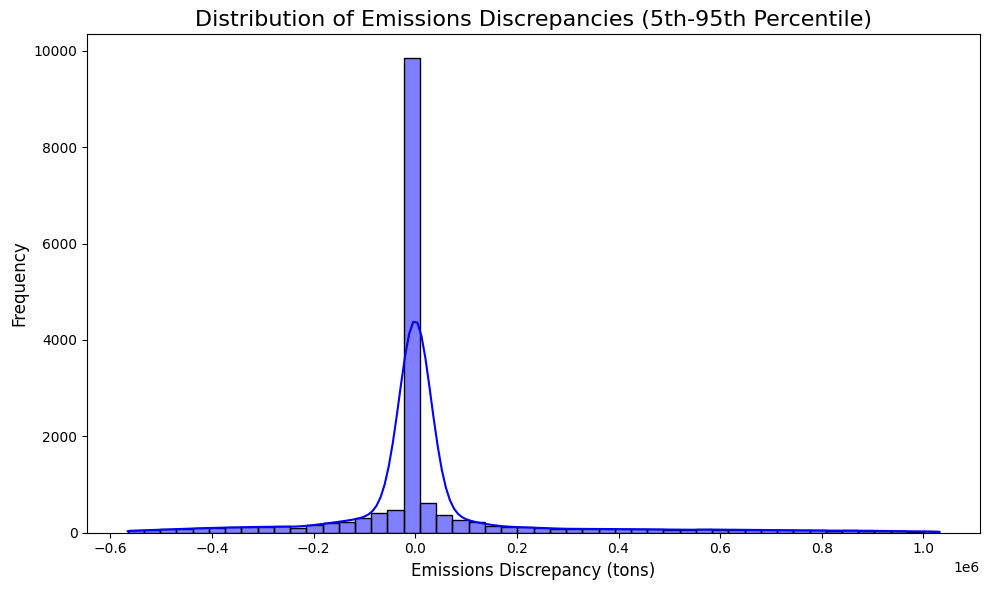

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define 5th and 95th percentiles to cut off extremes
lower_bound = matched_dfs['5m']['emissions_discrepancy'].quantile(0.05)
upper_bound = matched_dfs['5m']['emissions_discrepancy'].quantile(0.95)

# Filter data to exclude extreme values
filtered_data = matched_dfs['5m'][
    (matched_dfs['5m']['emissions_discrepancy'] >= lower_bound) &
    (matched_dfs['5m']['emissions_discrepancy'] <= upper_bound)
]

# Plot histogram of emissions discrepancies
plt.figure(figsize=(10, 6))
sns.histplot(
    filtered_data['emissions_discrepancy'],
    bins=50,
    kde=True,
    color="blue"
)
plt.title("Distribution of Emissions Discrepancies (5th-95th Percentile)", fontsize=16)
plt.xlabel("Emissions Discrepancy (tons)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-70-f94892f4f3e2>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


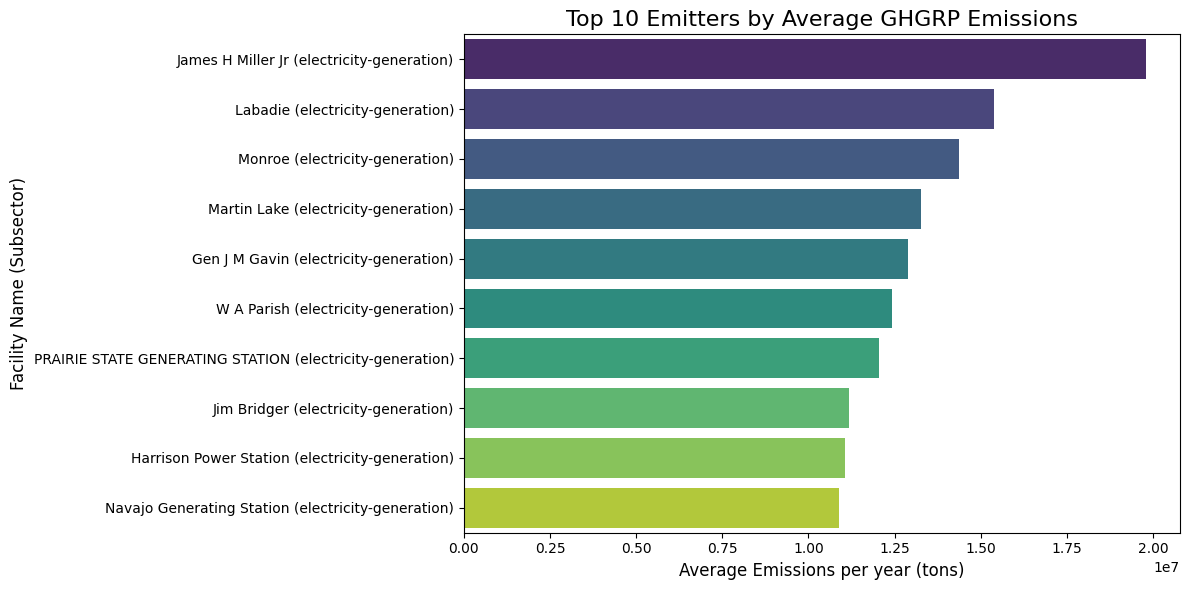

In [ ]:
# Concatenate the facility name with ct_subsector in brackets
matched_dfs['5m']['facility_with_subsector'] = (
    matched_dfs['5m']['ghgrp_facility_name'] +
    " (" + matched_dfs['5m']['ct_subsector'].fillna("Unknown") + ")"
)

# Group by facility name (with subsector), calculate mean emissions
average_emissions = (
    matched_dfs['5m']
    .groupby('facility_with_subsector')['ghgrp_emissions_tons']
    .mean()
    .reset_index()
    .sort_values(by='ghgrp_emissions_tons', ascending=False)
)

# Extract the top 10 unique facilities by average emissions
top_10_facilities = average_emissions.head(10)

# Plotting the top 10 facilities
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(
    x='ghgrp_emissions_tons',
    y='facility_with_subsector',
    data=top_10_facilities,
    palette='viridis',
    orient='h'  # Horizontal bar plot
)
plt.title("Top 10 Emitters by Average GHGRP Emissions", fontsize=16)
plt.xlabel("Average Emissions per year (tons)", fontsize=12)
plt.ylabel("Facility Name (Subsector)", fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-71-0a24a28d843d>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


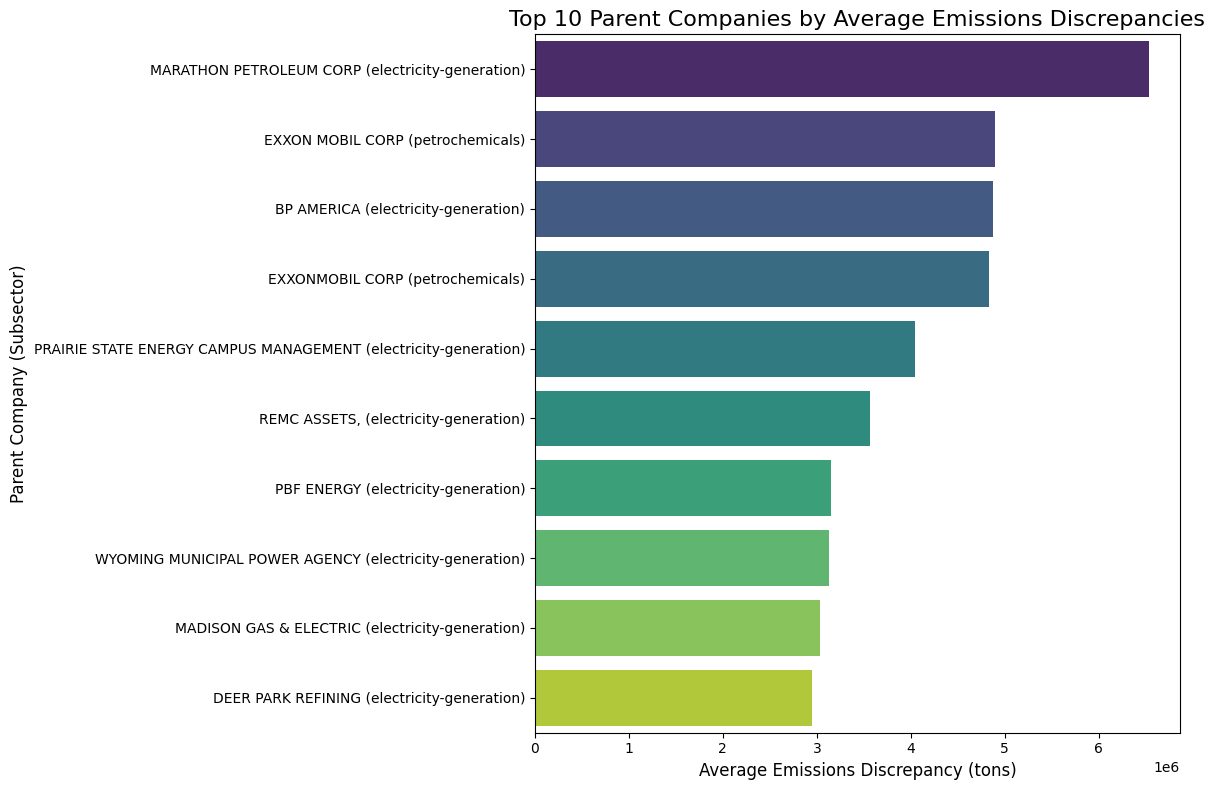

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to process parent companies
def process_parent_companies(value):
    if pd.isna(value):
        return ["Other"]  # Replace NaN with 'Other'
    cleaned_value = re.sub(r'\([^)]*\)', '', str(value))  # Remove anything in parentheses
    companies = [company.strip() for company in cleaned_value.split(';')]  # Split by ';' and strip whitespace
    return companies

# Apply the function to split parent companies
matched_dfs['5m']['ghgrp_parent_companies_processed'] = matched_dfs['5m']['ghgrp_parent_companies'].apply(process_parent_companies)

# Explode the DataFrame to separate each parent company into its own row
exploded_df = matched_dfs['5m'].explode('ghgrp_parent_companies_processed')

# Rename the exploded column for clarity
exploded_df = exploded_df.rename(columns={'ghgrp_parent_companies_processed': 'parent_company'})

# Concatenate the parent company name with ct_subsector in brackets
exploded_df['parent_company_with_subsector'] = (
    exploded_df['parent_company'] +
    " (" + exploded_df['ct_subsector'].fillna("Unknown") + ")"
)

# Aggregate discrepancies by individual parent companies
parent_company_discrepancy = (
    exploded_df.groupby('parent_company_with_subsector')['emissions_discrepancy']
    .mean()
    .reset_index()
)

# Get the top 10 parent companies by average discrepancy
top_parent_companies = parent_company_discrepancy.nlargest(10, 'emissions_discrepancy')

# Bar plot for top parent companies
plt.figure(figsize=(12, 8))
sns.barplot(
    x='emissions_discrepancy',
    y='parent_company_with_subsector',
    data=top_parent_companies,
    palette="viridis"
)
plt.title("Top 10 Parent Companies by Average Emissions Discrepancies", fontsize=16)
plt.xlabel("Average Emissions Discrepancy (tons)", fontsize=12)
plt.ylabel("Parent Company (Subsector)", fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-72-e99d463daaf2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


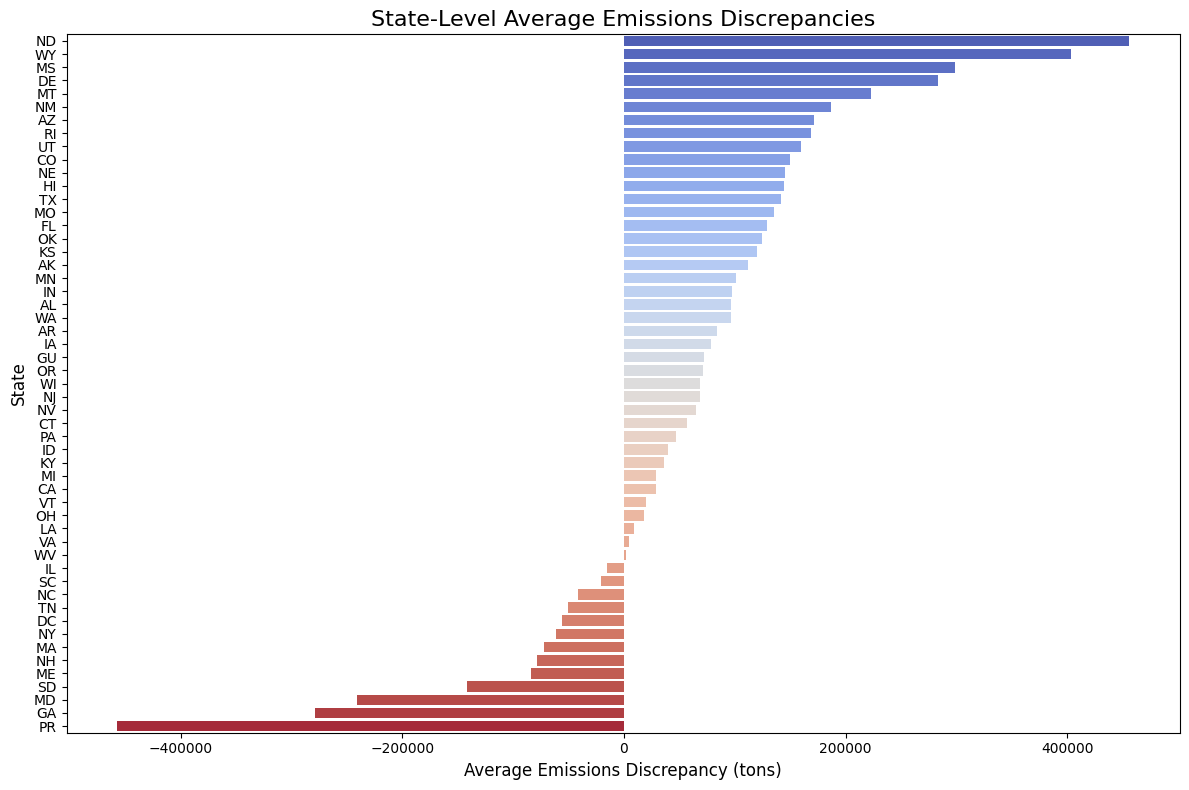

In [ ]:
# Aggregate discrepancies by state
state_discrepancy = matched_dfs['5m'].groupby('ghgrp_STATE')['emissions_discrepancy'].mean().reset_index()

# Bar plot for state-level discrepancies
plt.figure(figsize=(12, 8))
sns.barplot(
    x='emissions_discrepancy',
    y='ghgrp_STATE',
    data=state_discrepancy.sort_values(by='emissions_discrepancy', ascending=False),
    palette="coolwarm"
)
plt.title("State-Level Average Emissions Discrepancies", fontsize=16)
plt.xlabel("Average Emissions Discrepancy (tons)", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.tight_layout()
plt.show()

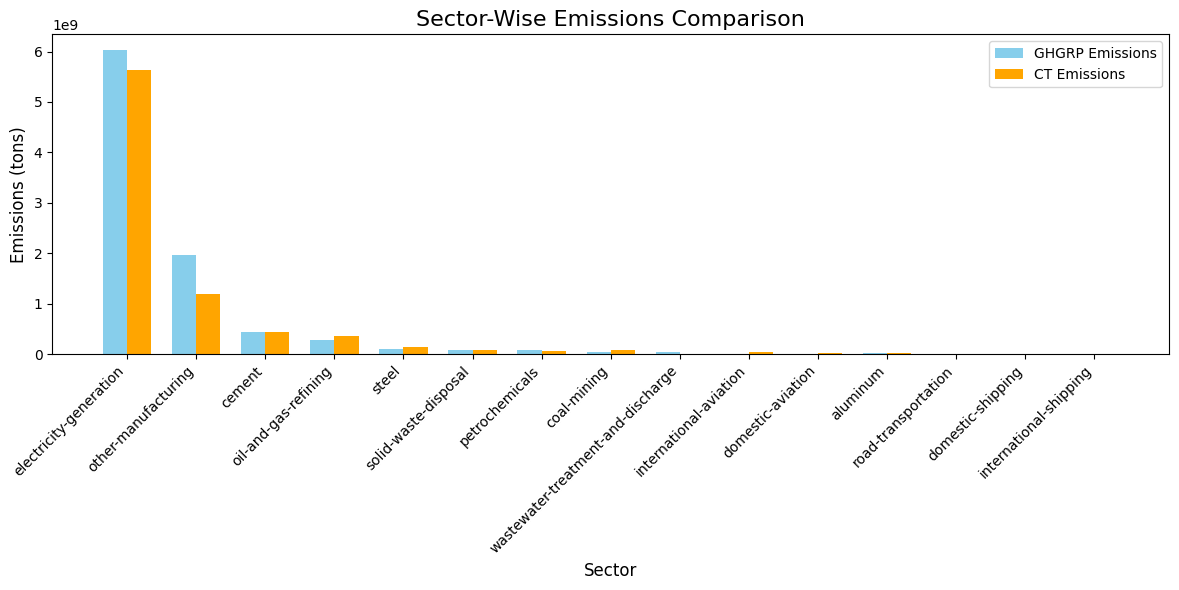

In [ ]:
# Aggregate emissions by sector and sort in descending order
sector_comparison = matched_dfs['5m'].groupby('ct_subsector')[
    ['ghgrp_emissions_tons', 'ct_emissions_quantity']
].sum().reset_index()

# Add a column for total emissions (for sorting)
sector_comparison['total_emissions'] = (
    sector_comparison['ghgrp_emissions_tons'] + sector_comparison['ct_emissions_quantity']
)

# Sort by total emissions in descending order
sector_comparison = sector_comparison.sort_values(by='total_emissions', ascending=False)

# Plot side-by-side bar chart
plt.figure(figsize=(12, 6))
width = 0.35  # Width of each bar

# X positions for bars
x = np.arange(len(sector_comparison['ct_subsector']))

plt.bar(
    x - width/2,
    sector_comparison['ghgrp_emissions_tons'],
    width=width,
    label='GHGRP Emissions',
    color='skyblue'
)
plt.bar(
    x + width/2,
    sector_comparison['ct_emissions_quantity'],
    width=width,
    label='CT Emissions',
    color='orange'
)

# Add labels and legend
plt.title("Sector-Wise Emissions Comparison", fontsize=16)
plt.xlabel("Sector", fontsize=12)
plt.ylabel("Emissions (tons)", fontsize=12)
plt.xticks(x, sector_comparison['ct_subsector'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

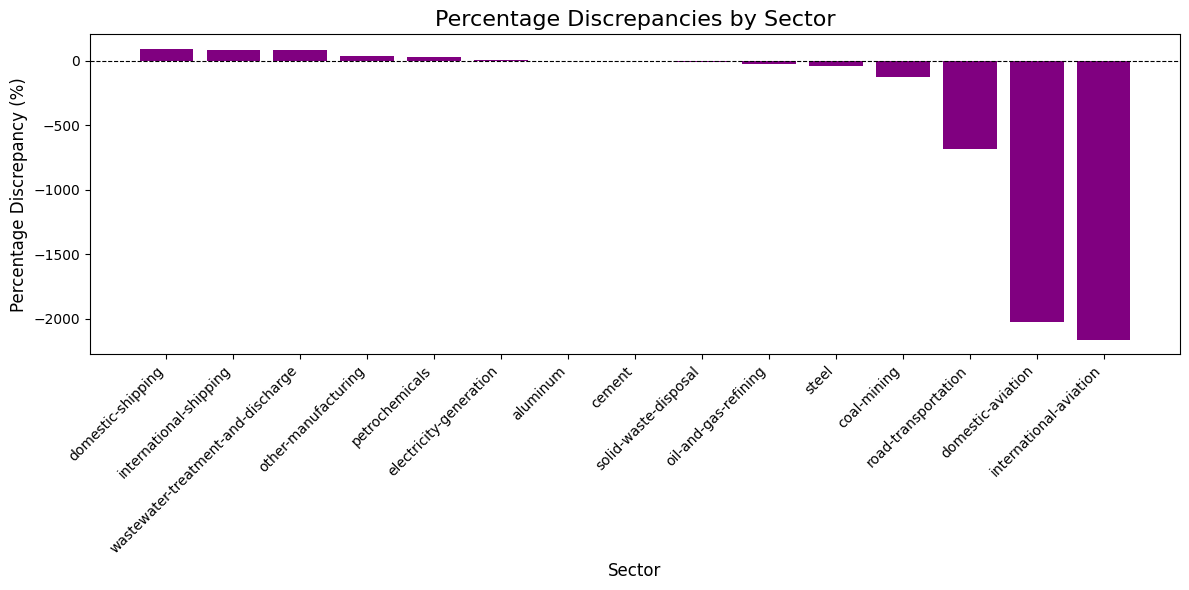

In [ ]:
# Aggregate emissions by sector and calculate percentage discrepancies
sector_comparison = matched_dfs['5m'].groupby('ct_subsector')[
    ['ghgrp_emissions_tons', 'ct_emissions_quantity']
].sum().reset_index()

# Calculate percentage discrepancy
sector_comparison['percentage_discrepancy'] = (
    (sector_comparison['ghgrp_emissions_tons'] - sector_comparison['ct_emissions_quantity'])
    / sector_comparison['ghgrp_emissions_tons']
) * 100

# Sort by absolute percentage discrepancies in descending order
sector_comparison = sector_comparison.sort_values(by='percentage_discrepancy', ascending=False)

# Plot percentage discrepancies
plt.figure(figsize=(12, 6))
plt.bar(
    sector_comparison['ct_subsector'],
    sector_comparison['percentage_discrepancy'],
    color='purple'
)

# Add labels and title
plt.title("Percentage Discrepancies by Sector", fontsize=16)
plt.xlabel("Sector", fontsize=12)
plt.ylabel("Percentage Discrepancy (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at 0
plt.tight_layout()
plt.show()

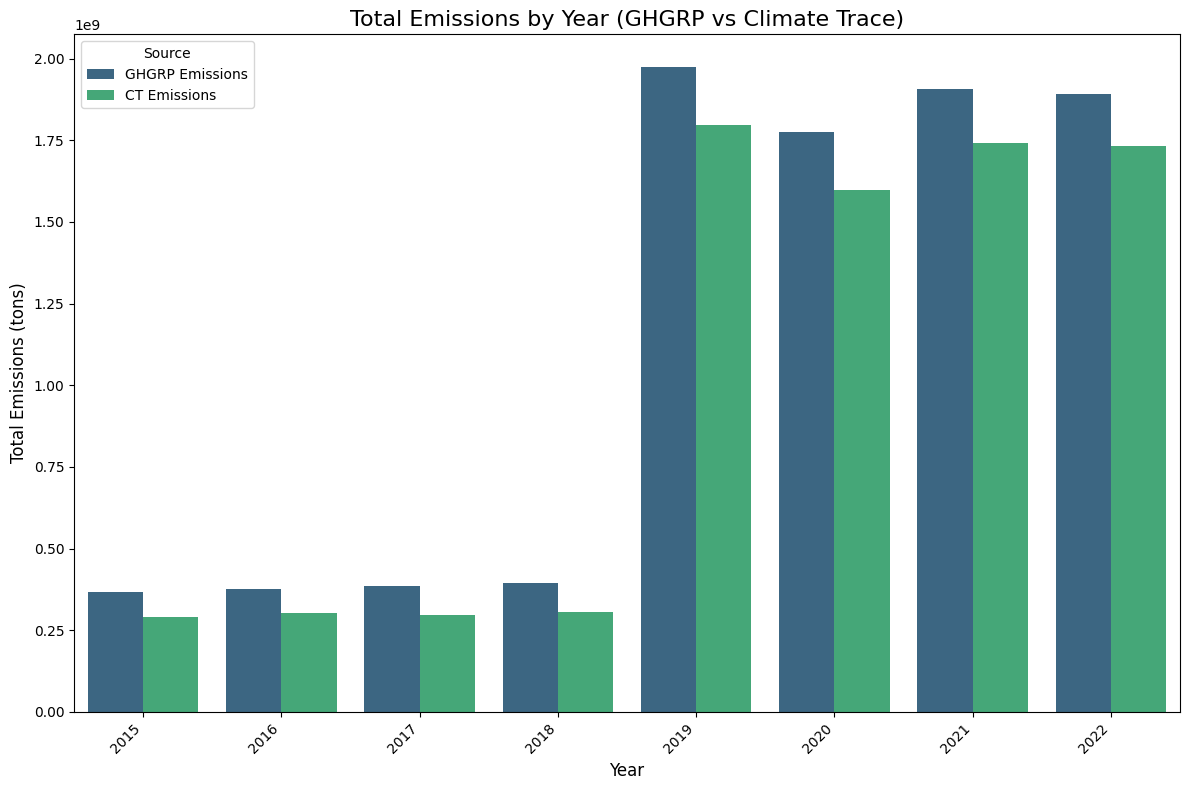

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate GHGRP and CT emissions by year
yearly_emissions = (
    matched_dfs['5m']
    .groupby('ghgrp_year')[['ghgrp_emissions_tons', 'ct_emissions_quantity']]
    .sum()
    .reset_index()
)

# Reshape the data for easier plotting
yearly_emissions_melted = yearly_emissions.melt(
    id_vars='ghgrp_year',
    value_vars=['ghgrp_emissions_tons', 'ct_emissions_quantity'],
    var_name='Source',
    value_name='Total Emissions'
)

# Map source names for better labels
source_map = {
    'ghgrp_emissions_tons': 'GHGRP Emissions',
    'ct_emissions_quantity': 'CT Emissions'
}
yearly_emissions_melted['Source'] = yearly_emissions_melted['Source'].map(source_map)

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    x='ghgrp_year',
    y='Total Emissions',
    hue='Source',
    data=yearly_emissions_melted,
    palette='viridis'
)

# Add labels and title
plt.title("Total Emissions by Year (GHGRP vs Climate Trace)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Emissions (tons)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Source", fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the number of rows per year in matched_dfs['5m']
matched_row_counts = matched_dfs['5m'].groupby('ghgrp_year').size().rename('Matched Rows')

# Display the counts
print("Number of rows per year in matched_dfs['5m']:")
display(matched_row_counts)

Number of rows per year in matched_dfs['5m']:


ghgrp_year
2015    1494
2016    1481
2017    1464
2018    1487
2019    2738
2020    2689
2021    3214
2022    3200
Name: Matched Rows, dtype: int64

In [ ]:
# Select specific columns to display
columns_to_display = [
    'ghgrp_year', 'ghgrp_facility_name',
    'ghgrp_city_name', 'ghgrp_county_name',
    'ghgrp_parent_companies', 'ghgrp_emissions_tons', 'ghgrp_subparts',

    'ct_emissions_quantity', 'ct_source_name', 'ct_subsector',
 'distance',
    'emissions_discrepancy'
]

# Display 10 random rows with the selected columns
display(matched_dfs['5m'][columns_to_display].sample(10, random_state=42))

ghgrp_year                       ghgrp_facility_name ghgrp_city_name  \
1086         2015                        OWENSBORO GRAIN CO       OWENSBORO   
16740        2022  Nouryon Pulp & Performance Chemicals LLC        COLUMBUS   
4106         2017                    PRYOR CHEMICAL COMPANY           PRYOR   
2684         2016             ROCKY MOUNTAIN BOTTLE COMPANY     WHEAT RIDGE   
15514        2022    Dow Corning Corporation - Midland Site         Midland   
12826        2021               IESI Hardin County Landfill         Kountze   
11607        2021                          Argos Cement LLC        NEWBERRY   
9323         2020          Cornell University Ithaca Campus          ITHACA   
736          2015         INEOS Pigments USA, Inc.- Plant 1       ASHTABULA   
101          2015              ASARCO LLC Hayden Operations          Hayden   

      ghgrp_county_name       ghgrp_parent_companies  ghgrp_emissions_tons  \
1086     Daviess County      OWENSBORO GRAIN HOLDING                101607   
16740    Lowndes County            NOURYON CHEMICALS                 36097   
4106       Mayes County               LSB INDUSTRIES                258400   
2684   Jefferson County  MILLERCOORS; OWENS-ILLINOIS                 86993   
15514    Midland County                          DOW                 39573   
12826     Hardin County            REPUBLIC SERVICES                 32694   
11607    Alachua County                    ARGOS USA               1065706   
9323    Tompkins County           CORNELL UNIVERSITY                152368   
736    Ashtabula County                  CRISTAL USA                141553   
101         Gila County         AMERICAS MINING CORP                 49820   

                                          ghgrp_subparts  \
1086          General Stationary Fuel Combustion Sources   
16740         General Stationary Fuel Combustion Sources   
4106   General Stationary Fuel Combustion Sources, Am...   
2684   General Stationary Fuel Combustion Sources, Gl...   
15514         General Stationary Fuel Combustion Sources   
12826                    Municipal Solid Waste Landfills   
11607                                  Cement Production   
9323          General Stationary Fuel Combustion Sources   
736    General Stationary Fuel Combustion Sources, Ti...   
101           General Stationary Fuel Combustion Sources   

       ct_emissions_quantity                            ct_source_name  \
1086            63061.823760                        OWENSBORO GRAIN CO   
16740           32413.369930  Nouryon Pulp & Performance Chemicals LLC   
4106             4219.590604                    PRYOR CHEMICAL COMPANY   
2684            86996.607540             ROCKY MOUNTAIN BOTTLE COMPANY   
15514           40170.610360    Dow Corning Corporation - Midland Site   
12826           36617.280000               Iesi Hardin County Landfill   
11607          447262.000000                     Newberry cement plant   
9323            34000.000000           Cornell University Central Heat   
736            141554.453800         INEOS Pigments USA, Inc.- Plant 1   
101             49822.259010              ASARCO LLC Hayden Operations   

                 ct_subsector  distance  emissions_discrepancy  
1086      other-manufacturing  0.000000           38545.176240  
16740     other-manufacturing  0.000000            3683.630070  
4106      other-manufacturing  0.000000          254180.409396  
2684      other-manufacturing  0.001150              -3.607540  
15514     other-manufacturing  0.000000            -597.610360  
12826    solid-waste-disposal  0.000000           -3923.280000  
11607                  cement  0.000449          618444.000000  
9323   electricity-generation  0.001900          118368.000000  
736       other-manufacturing  0.000000              -1.453800  
101       other-manufacturing  0.002269              -2.259010

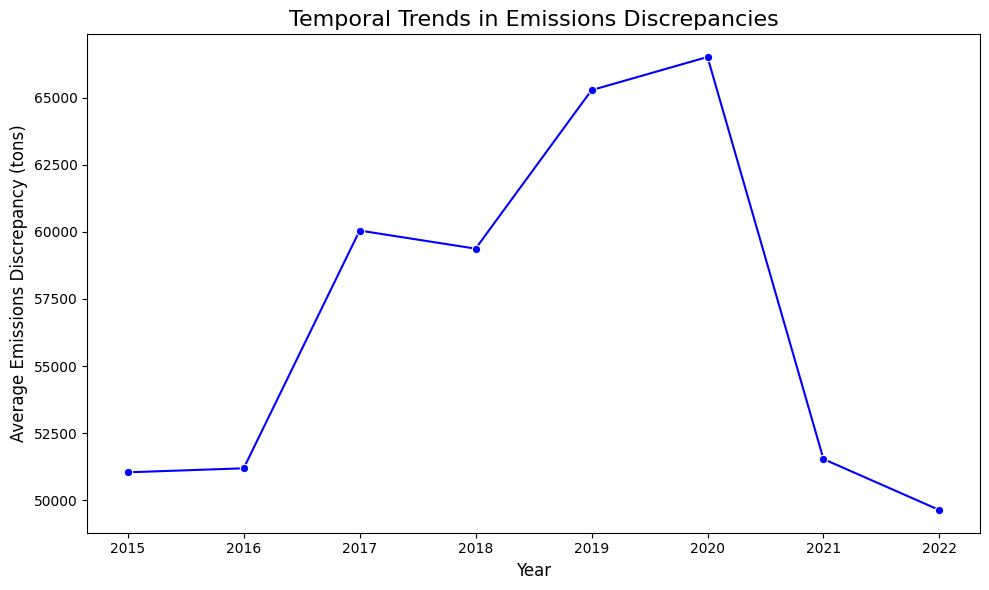

In [ ]:
# Aggregate discrepancies by year
yearly_discrepancy = matched_dfs['5m'].groupby('ghgrp_year')['emissions_discrepancy'].mean().reset_index()

# Line plot for temporal trends
plt.figure(figsize=(10, 6))
sns.lineplot(x='ghgrp_year', y='emissions_discrepancy', data=yearly_discrepancy, marker='o', color='blue')
plt.title("Temporal Trends in Emissions Discrepancies", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Emissions Discrepancy (tons)", fontsize=12)
plt.tight_layout()
plt.show()

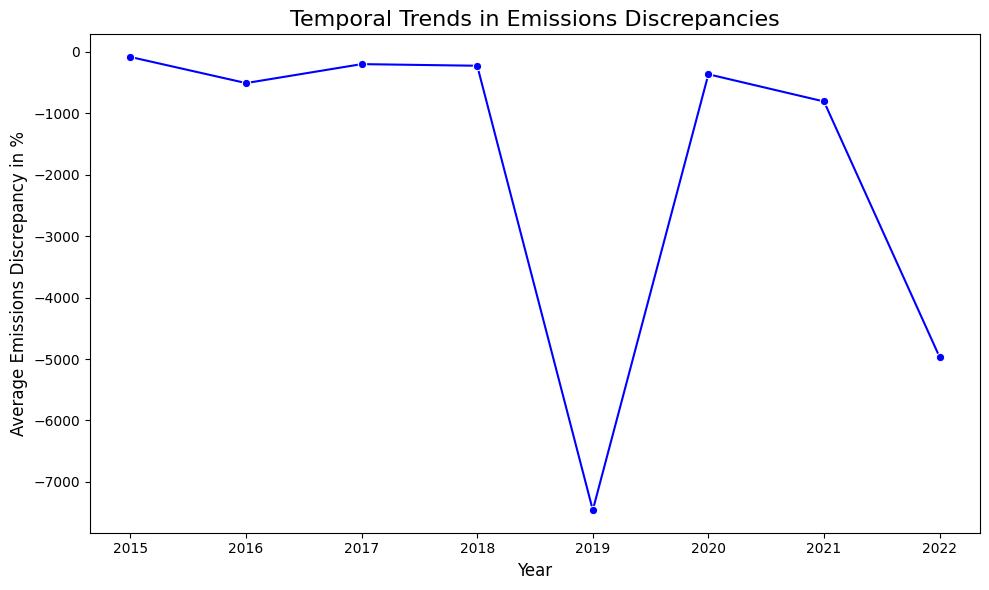

In [ ]:
# Aggregate discrepancies by year
yearly_discrepancy = matched_dfs['5m'].groupby('ghgrp_year')['emissions_percentage_discrepancy'].mean().reset_index()

# Line plot for temporal trends
plt.figure(figsize=(10, 6))
sns.lineplot(x='ghgrp_year', y='emissions_percentage_discrepancy', data=yearly_discrepancy, marker='o', color='blue')
plt.title("Temporal Trends in Emissions Discrepancies", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Emissions Discrepancy in %", fontsize=12)
plt.tight_layout()
plt.show()

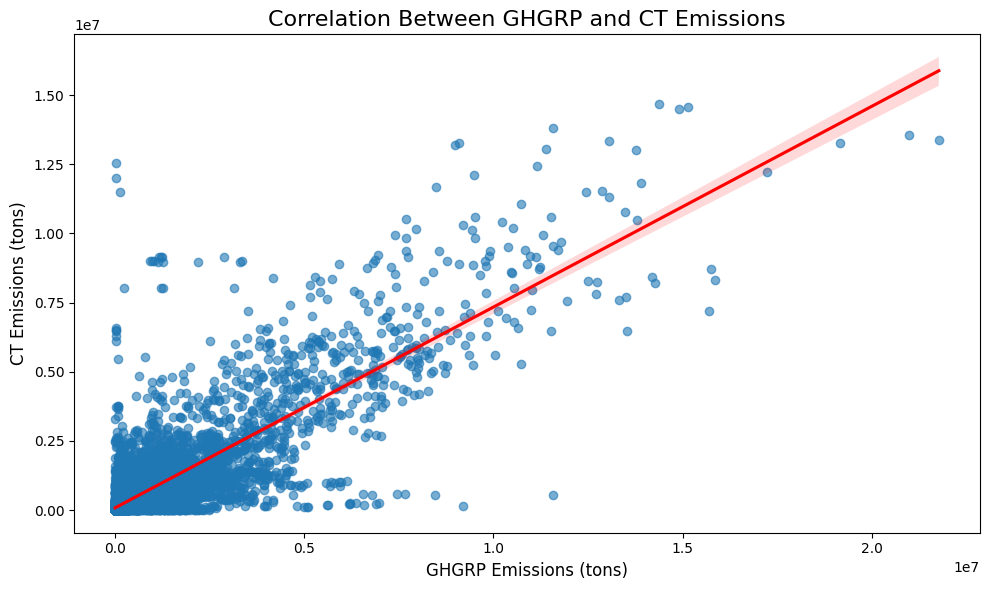

In [ ]:
# Scatter plot with trendline
plt.figure(figsize=(10, 6))
sns.regplot(
    x='ghgrp_emissions_tons',
    y='ct_emissions_quantity',
    data=matched_dfs['5m'],
    scatter_kws={'alpha': 0.6},
    line_kws={"color": "red"}
)
plt.title("Correlation Between GHGRP and CT Emissions", fontsize=16)
plt.xlabel("GHGRP Emissions (tons)", fontsize=12)
plt.ylabel("CT Emissions (tons)", fontsize=12)
plt.tight_layout()
plt.show()

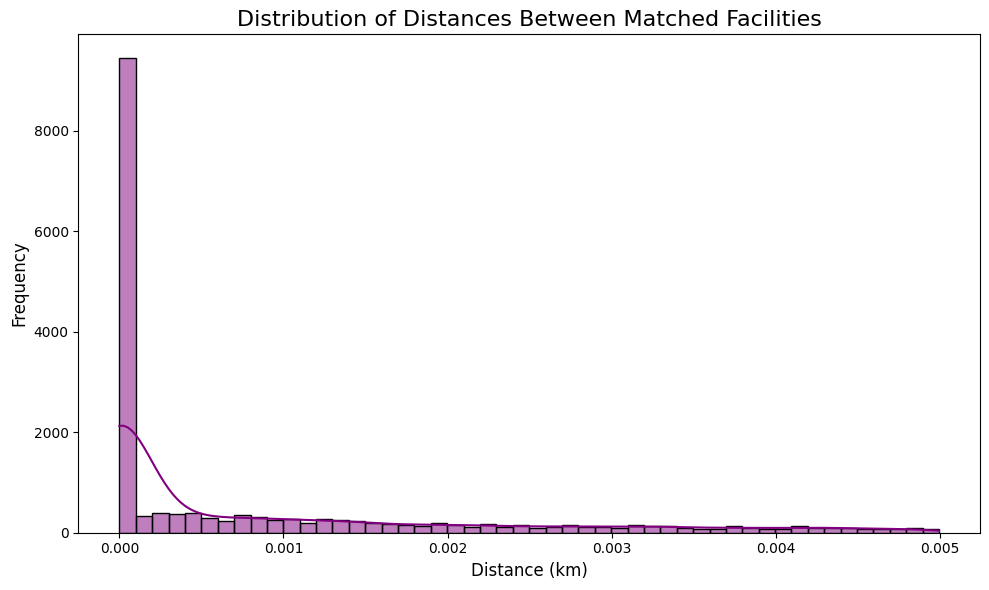

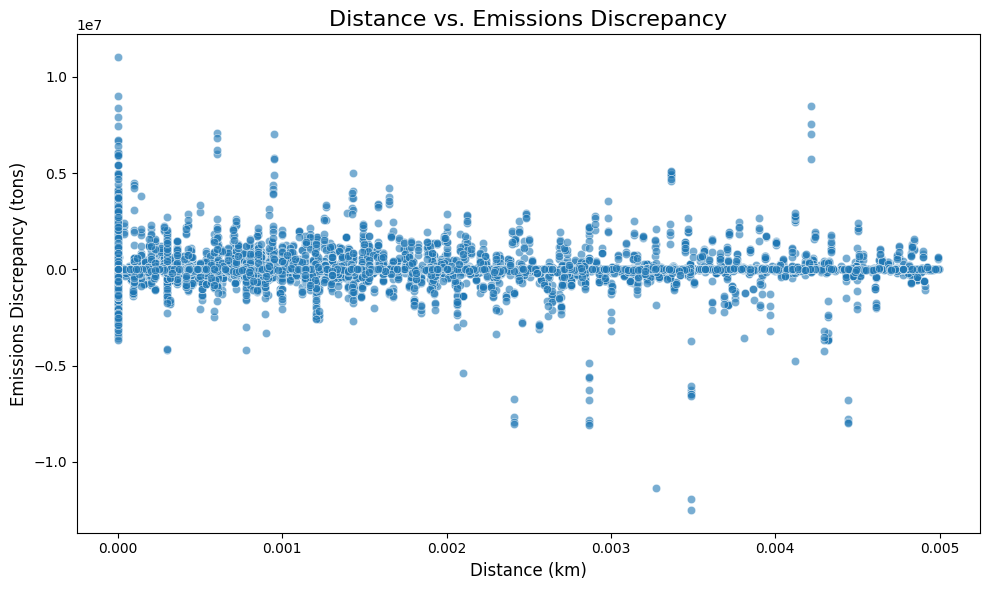

In [ ]:
# Histogram for distances
plt.figure(figsize=(10, 6))
sns.histplot(
    matched_dfs['5m']['distance'],
    bins=50,
    kde=True,
    color="purple"
)
plt.title("Distribution of Distances Between Matched Facilities", fontsize=16)
plt.xlabel("Distance (km)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Scatter plot for distance vs. emissions discrepancy
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='distance',
    y='emissions_discrepancy',
    data=matched_dfs['5m'],
    alpha=0.6
)
plt.title("Distance vs. Emissions Discrepancy", fontsize=16)
plt.xlabel("Distance (km)", fontsize=12)
plt.ylabel("Emissions Discrepancy (tons)", fontsize=12)
plt.tight_layout()
plt.show()

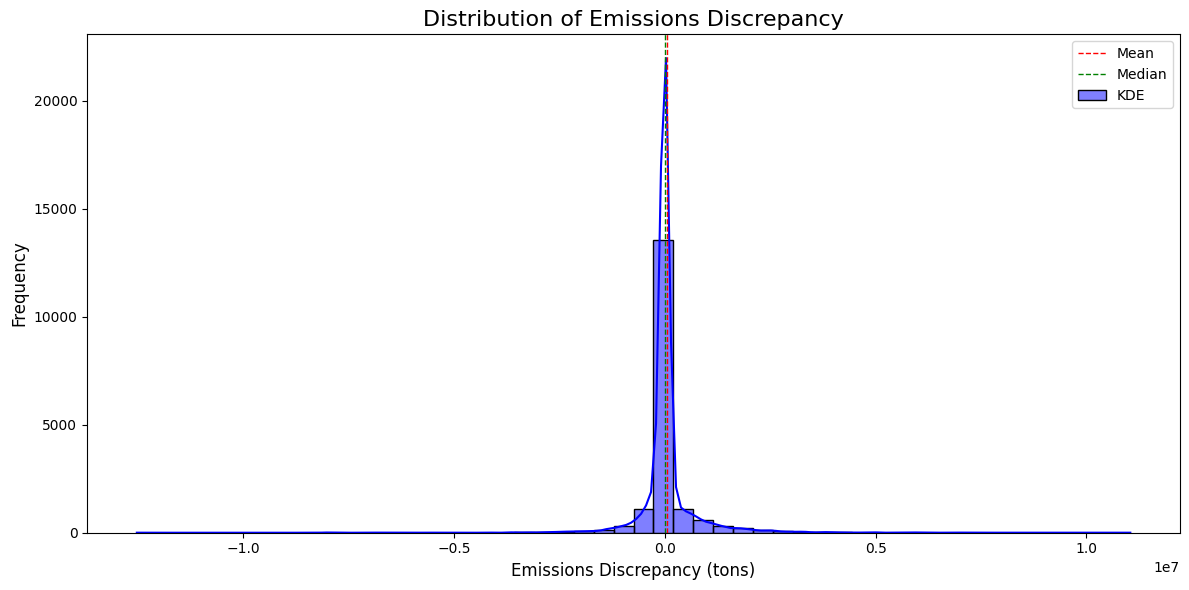

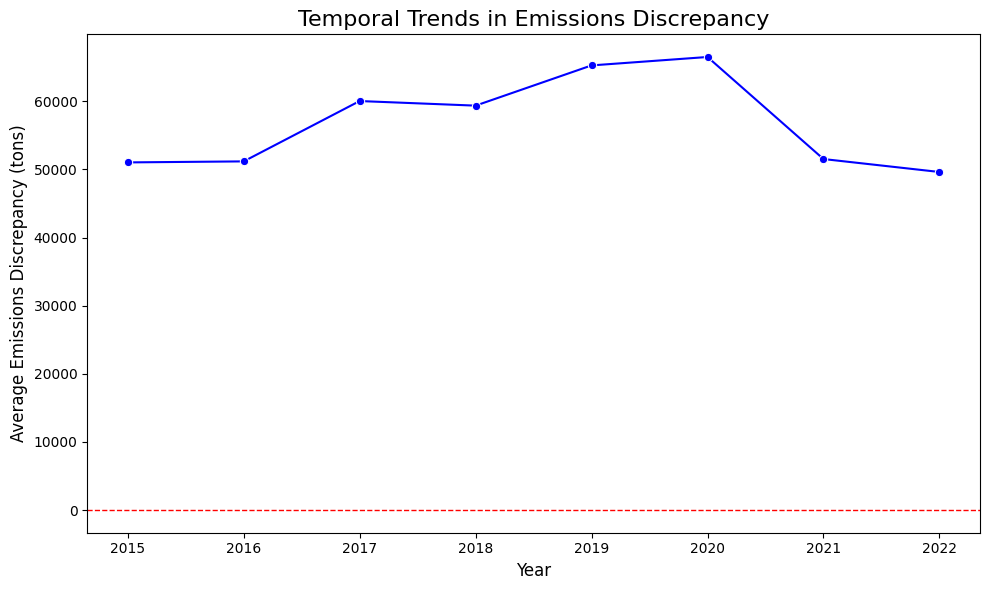

<ipython-input-82-30da02ba75e7>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=matched_dfs['5m'], x='ghgrp_year', y='emissions_discrepancy', palette="Set3")


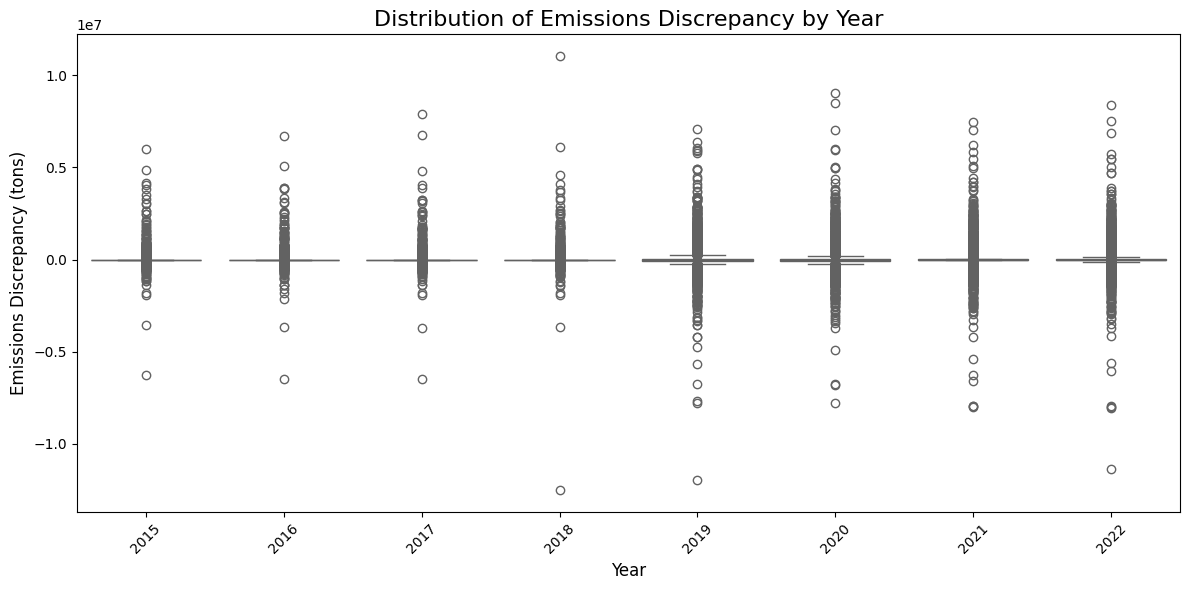

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Distribution Plot (Histogram and KDE)
plt.figure(figsize=(12, 6))
sns.histplot(matched_dfs['5m']['emissions_discrepancy'], bins=50, kde=True, color="blue", label="KDE")
plt.axvline(matched_dfs['5m']['emissions_discrepancy'].mean(), color='red', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(matched_dfs['5m']['emissions_discrepancy'].median(), color='green', linestyle='dashed', linewidth=1, label="Median")
plt.title("Distribution of Emissions Discrepancy", fontsize=16)
plt.xlabel("Emissions Discrepancy (tons)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Temporal Trend (Line Plot)
yearly_discrepancy = matched_dfs['5m'].groupby('ghgrp_year')['emissions_discrepancy'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_discrepancy, x='ghgrp_year', y='emissions_discrepancy', marker='o', color='blue')
plt.title("Temporal Trends in Emissions Discrepancy", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Emissions Discrepancy (tons)", fontsize=12)
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)  # Highlight zero line
plt.tight_layout()
plt.show()

# 3. Boxplot by Category (e.g., County or Parent Company)
plt.figure(figsize=(12, 6))
sns.boxplot(data=matched_dfs['5m'], x='ghgrp_year', y='emissions_discrepancy', palette="Set3")
plt.title("Distribution of Emissions Discrepancy by Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Emissions Discrepancy (tons)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Test which transformation to apply to DP variable


=== Normality Checks ===
Dependent Variable:
Shapiro-Wilk p-value: 2.1948e-111
D'Agostino p-value: 0.0000e+00

Residuals:
Shapiro-Wilk p-value: 3.0091e-112
D'Agostino p-value: 0.0000e+00

=== Heteroscedasticity Check ===
Breusch-Pagan Test p-value: 3.7062e-266


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17767.
  res = hypotest_fun_out(*samples, **kwds)


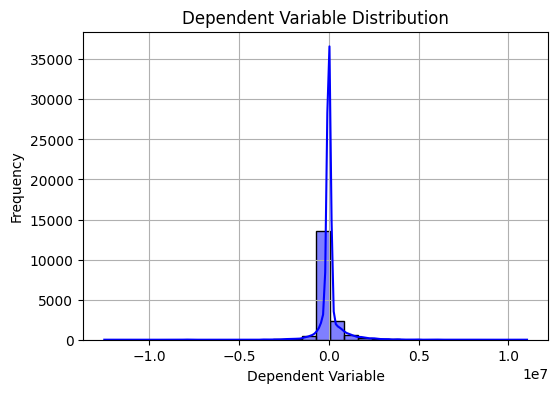

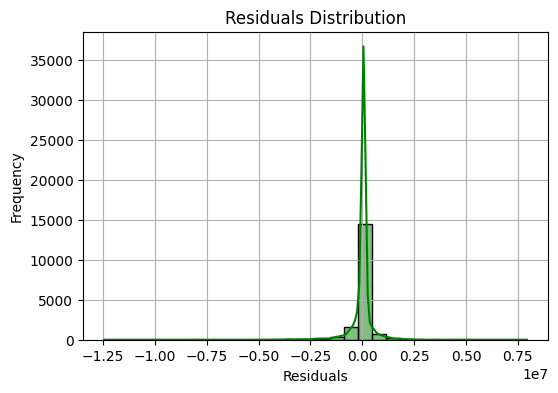

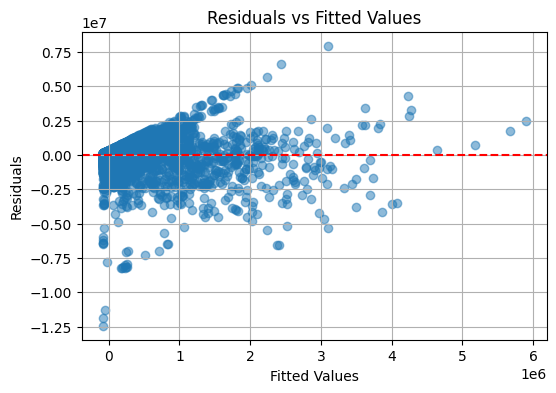

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan

# ------------------------------------------------------------------------------
# 1) Check Normality of the Dependent Variable and Residuals
# ------------------------------------------------------------------------------
def normality_checks(y, residuals):
    print("\n=== Normality Checks ===")

    # Normality test on the dependent variable
    print("Dependent Variable:")
    shapiro_test = stats.shapiro(y)
    dagostino_test = stats.normaltest(y)
    print(f"Shapiro-Wilk p-value: {shapiro_test.pvalue:.4e}")
    print(f"D'Agostino p-value: {dagostino_test.pvalue:.4e}")

    # Normality test on residuals
    print("\nResiduals:")
    shapiro_test_res = stats.shapiro(residuals)
    dagostino_test_res = stats.normaltest(residuals)
    print(f"Shapiro-Wilk p-value: {shapiro_test_res.pvalue:.4e}")
    print(f"D'Agostino p-value: {dagostino_test_res.pvalue:.4e}")

# ------------------------------------------------------------------------------
# 2) Check for Heteroscedasticity
# ------------------------------------------------------------------------------
def heteroscedasticity_checks(X, residuals):
    print("\n=== Heteroscedasticity Check ===")

    # Add a constant to X for the Breusch-Pagan test
    X_with_const = sm.add_constant(X)
    _, pval, _, _ = het_breuschpagan(residuals, X_with_const)
    print(f"Breusch-Pagan Test p-value: {pval:.4e}")

# ------------------------------------------------------------------------------
# 3) Visualization of Distribution & Residuals
# ------------------------------------------------------------------------------
def plot_diagnostics(y, residuals):
    # Dependent variable distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(y, kde=True, color="blue", bins=30)
    plt.title("Dependent Variable Distribution")
    plt.xlabel("Dependent Variable")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Residuals distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color="green", bins=30)
    plt.title("Residuals Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Residuals vs Fitted Values
    plt.figure(figsize=(6, 4))
    plt.scatter(fitted_values, residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Residuals vs Fitted Values")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.show()

# ------------------------------------------------------------------------------
# 4) Load Original Data and Run Diagnostics
# ------------------------------------------------------------------------------
# Use the original dataframe
df = matched_dfs["5m"].copy()

# Extract dependent and independent variables
y_original = df["emissions_discrepancy"].values  # Untransformed dependent variable
X_original = df[["ghgrp_emissions_tons"]].values  # Untransformed independent variable

# Fit a simple linear regression model
X_with_const = sm.add_constant(X_original)  # Add a constant for the model
model = sm.OLS(y_original, X_with_const).fit()
fitted_values = model.fittedvalues
residuals = model.resid

# Run diagnostics
normality_checks(y_original, residuals)
heteroscedasticity_checks(X_original, residuals)
plot_diagnostics(y_original, residuals)

**Summary of findings**

1.	Non-Normality of Dependent Variable:
	The dependent variable significantly deviates from normality based on extremely low p-values from the Shapiro-Wilk and D’Agostino tests. This violates key assumptions of many statistical models, including ordinary least squares regression.
2.	Non-Normality of Residuals:
	Residuals from the model also exhibit non-normality, as confirmed by similar normality test results. This could lead to unreliable inference, particularly with p-values and confidence intervals.
3.	Heteroscedasticity:
	The Breusch-Pagan test p-value indicates severe heteroscedasticity in the residuals, meaning that the variance of errors is not constant across levels of the independent variable. This can lead to biased standard errors.
4.	Visual Insights:
	Histograms and residual plots further confirm the above findings:
	•	The dependent variable and residuals are sharply peaked with long tails, consistent with non-normality.
	•	A “funnel-like” pattern in the residuals versus fitted values plot is indicative of heteroscedasticity.
5.	Implications for Transformation:
	Transforming the dependent variable may address the non-normality and heteroscedasticity issues.
	Transformations such as logarithmic, Box-Cox, quantile-based, or Yeo-Johnson could help stabilize variance and improve the normality of the residuals, leading to better model performance.

Next step: find out which transformation works best

Column 'emissions_discrepancy_scaled' not found. Creating it...


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17767.
  res = hypotest_fun_out(*samples, **kwds)


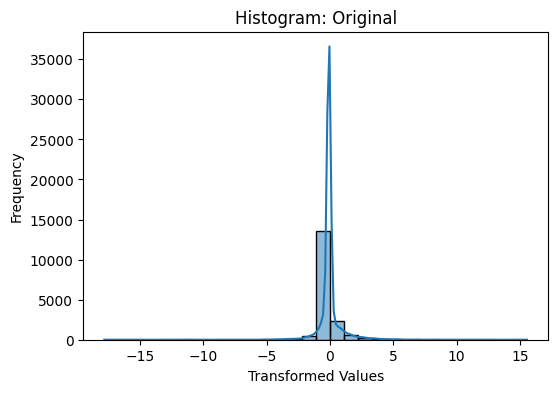

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17767.
  res = hypotest_fun_out(*samples, **kwds)


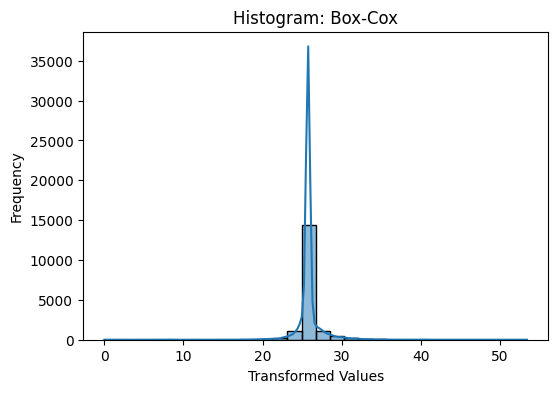

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17767.
  res = hypotest_fun_out(*samples, **kwds)


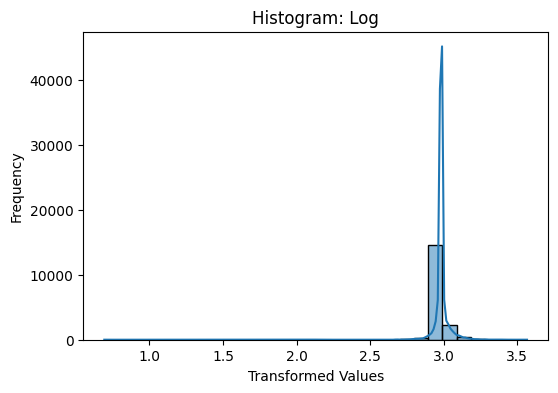

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17767.
  res = hypotest_fun_out(*samples, **kwds)


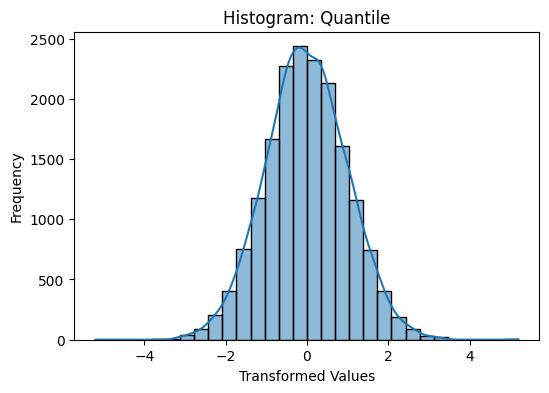

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17767.
  res = hypotest_fun_out(*samples, **kwds)


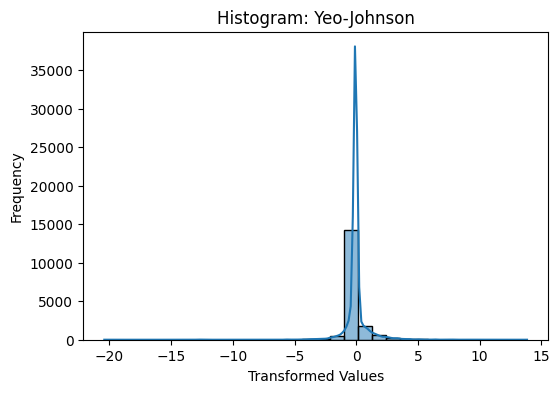

  Transformation  Skewness    Kurtosis  Shapiro-Wilk (p-value)  \
0       Original  0.372224   49.503915           2.194816e-111   
1        Box-Cox  1.164955   44.963419           3.158320e-111   
2            Log -9.321395  318.957549           3.208471e-116   
3       Quantile  0.038444    0.108746            1.028700e-04   
4    Yeo-Johnson -1.252875   60.426559           1.422691e-111   

   Breusch-Pagan (p-value)  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  

Best Transformation(s):
No transformation met all criteria.


In [ ]:
from scipy.stats import skew, kurtosis, shapiro, boxcox
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import StandardScaler

# Function to evaluate transformations
def evaluate_transformations(df, target_col):
    results = []

    # Original
    original = df[target_col]
    results.append(('Original', original))

    # Box-Cox (ensure all values > 0)
    if (original + abs(original.min()) + 1).min() > 0:
        boxcox_transformed, _ = boxcox(original + abs(original.min()) + 1)
        results.append(('Box-Cox', boxcox_transformed))

    # Log
    log_transformed = np.log1p(original + abs(original.min()) + 1)
    results.append(('Log', log_transformed))

    # Quantile Transformation
    qt = QuantileTransformer(output_distribution='normal', random_state=42)
    quantile_transformed = qt.fit_transform(original.values.reshape(-1, 1)).flatten()
    results.append(('Quantile', quantile_transformed))

    # Yeo-Johnson Transformation
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    yeo_johnson_transformed = pt.fit_transform(original.values.reshape(-1, 1)).flatten()
    results.append(('Yeo-Johnson', yeo_johnson_transformed))

    # Analyze each transformation
    analysis = []
    for name, transformed in results:
        skewness = skew(transformed)
        kurt = kurtosis(transformed)
        shapiro_test = shapiro(transformed)

        # Add a constant for Breusch-Pagan test
        explanatory_vars = sm.add_constant(df.drop(columns=[target_col])._get_numeric_data())
        bp_test = het_breuschpagan(transformed, explanatory_vars)

        analysis.append({
            'Transformation': name,
            'Skewness': skewness,
            'Kurtosis': kurt,
            'Shapiro-Wilk (p-value)': shapiro_test[1],
            'Breusch-Pagan (p-value)': bp_test[3]
        })

        # Plot histogram
        plt.figure(figsize=(6, 4))
        sns.histplot(transformed, kde=True, bins=30)
        plt.title(f'Histogram: {name}')
        plt.xlabel('Transformed Values')
        plt.ylabel('Frequency')
        plt.show()

    # Return results as a DataFrame
    return pd.DataFrame(analysis)

# Ensure the column is created properly
if 'emissions_discrepancy_scaled' not in df.columns:
    print("Column 'emissions_discrepancy_scaled' not found. Creating it...")
    scaler = StandardScaler()
    df['emissions_discrepancy_scaled'] = scaler.fit_transform(df[['emissions_discrepancy']])
else:
    print("Column 'emissions_discrepancy_scaled' found.")

# Evaluate transformations on 'emissions_discrepancy_scaled'
transformation_results = evaluate_transformations(df, 'emissions_discrepancy_scaled')
print(transformation_results)

# Highlight the best transformation based on lowest skewness, kurtosis, and highest p-values
best_transformation = transformation_results.loc[
    (transformation_results['Skewness'].abs() < 0.5) &
    (transformation_results['Shapiro-Wilk (p-value)'] > 0.05) &
    (transformation_results['Breusch-Pagan (p-value)'] > 0.05)
]

print("\nBest Transformation(s):")
print(best_transformation if not best_transformation.empty else "No transformation met all criteria.")

**Observations**



1.   Quantile Transformation performed best in reducing skewness and kurtosis but still fell short of perfect normality due to sample size sensitivity in tests
2.   None of the transformations addressed heteroscedasticity



**Justification for Applying Quantile Transformation**

The dependent variable, emissions discrepancy, shows high skewness, kurtosis, and heteroscedasticity, as evidenced by diagnostic tests. These issues violate the assumptions of statistical models like ANOVA, Elastic Net, and Bayesian Regression, potentially biasing results.

**Benefits**



1.	Improves Normality: Converts the variable closer to a standard normal distribution, reducing skewness and kurtosis more effectively than other transformations.
2.	Reduces Heteroscedasticity: Helps stabilize variance across the dataset, though additional modeling adjustments may still be required.
3.	Enhances Model Validity: Aligns data with parametric model assumptions and benefits both parametric (e.g., ANOVA) and non-parametric models (e.g., Random Forest).
4.	Consistency Across Models: Ensures comparability of results across ANOVA, Elastic Net, and Bayesian frameworks.
5.	Better Interpretability: Predictions can be back-transformed for real-world understanding, ensuring usability of model outputs.





# Variance Decomposition Analysis (base model, not suitable)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, levene
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load data
df = matched_dfs["5m"].copy()

# Apply Quantile Transformation to the dependent variable and the explanatory variable
qt = QuantileTransformer(output_distribution='normal', random_state=42)

df['emissions_discrepancy_quantile'] = qt.fit_transform(df[['emissions_discrepancy']])
df['ghgrp_emissions_tons_quantile'] = qt.fit_transform(df[['ghgrp_emissions_tons']])

# Ensure variables are of the correct data type
df['ghgrp_year'] = df['ghgrp_year'].astype(int)

# Preprocessing functions
def process_parent_companies(value):
    if pd.isna(value):
        return ["Other"]  # Replace NaN with 'Other'
    # Remove percentages in parentheses
    cleaned_value = re.sub(r'\([^)]*\)', '', str(value))
    # Split by ';' and strip spaces
    companies = [company.strip() for company in cleaned_value.split(';')]
    return companies

def process_subparts(value):
    if pd.isna(value):
        return []
    subparts = [subpart.strip() for subpart in str(value).split(',')]
    return subparts

# Apply the processing functions
df['ghgrp_parent_companies'] = df['ghgrp_parent_companies'].apply(process_parent_companies)
df['ghgrp_subparts'] = df['ghgrp_subparts'].apply(process_subparts)

# Explode both parent companies and subparts so that each is a separate category
df = df.explode('ghgrp_parent_companies')
df = df.explode('ghgrp_subparts')

# Convert to categorical
df['ghgrp_parent_companies'] = df['ghgrp_parent_companies'].astype('category')
df['ghgrp_county_name'] = df['ghgrp_county_name'].astype('category')
df['ghgrp_subparts'] = df['ghgrp_subparts'].astype('category')
df['ghgrp_id'] = df['ghgrp_id'].astype('category')  # Include ghgrp_id as a categorical variable

# Define ANOVA model (updated to use Quantile Transformed variables)
model_formula = (
    'emissions_discrepancy_quantile ~ '
    'C(ghgrp_year) + ghgrp_emissions_tons_quantile + '
    'C(ghgrp_county_name) + C(ghgrp_parent_companies) + '
    'C(ghgrp_subparts) + C(ghgrp_id)'
)

print("Fitting the ANOVA model...")
model = ols(model_formula, data=df).fit()

# Display model summary
print("\nModel Summary:")
print(model.summary())

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table['Partial Eta Squared'] = anova_table['sum_sq'] / anova_table['sum_sq'].sum()

# Add p-values to Partial Eta Squared
anova_table['p-value'] = anova_table['PR(>F)']  # Copy p-values from the ANOVA table
anova_table['Significant'] = anova_table['p-value'] < 0.05  # Add significance indicator

# Print the updated ANOVA table
print("\nUpdated ANOVA Table with p-values and robust mean coefficient handling:")
print(anova_table)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
C(ghgrp_parent_companies)[T.EVERGY]                                                                                                                -0.5405      0.239     -2.260      0.024      -1.009      -0.072
C(ghgrp_parent_companies)[T.EVERYWARE GLOBAL]                                                                                                      -0.1144      0.197     -0.580      0.562      -0.501       0.272
C(ghgrp_parent_companies)[T.EVONIK CORP]                                                                                                            0.0565      0.088      0.639      0.523      -0.117       0.230
C(ghgrp_parent_companies)[T.EVONIK INDUSTRIES]                                                                                                      0.1636      0.078      2.088      0.037       0.010       0.317
C(ghgrp_parent_companies)[T.EVRAZ INC NORTH AMERICA]                                 

In [ ]:
# Diagnostics

residuals = model.resid

# Shapiro-Wilk Test
shapiro_test = shapiro(residuals)
print(f"\nShapiro-Wilk Test:")
print(f"Statistic: {shapiro_test.statistic:.3f}, p-value: {shapiro_test.pvalue:.3e}")

# Levene's Test
levene_test = levene(df['emissions_discrepancy_quantile'], df['ghgrp_emissions_tons_quantile'])
print(f"\nLevene's Test:")
print(f"Statistic: {levene_test.statistic:.3f}, p-value: {levene_test.pvalue:.3e}")

# Breusch-Pagan Test
bp_test = het_breuschpagan(residuals, model.model.exog)
print(f"\nBreusch-Pagan Test:")
print(f"Statistic: {bp_test[0]:.3f}, p-value: {bp_test[1]:.3e}")


Shapiro-Wilk Test:
Statistic: 0.777, p-value: 1.174e-104

Levene's Test:
Statistic: 465.900, p-value: 6.361e-103


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29031.
  res = hypotest_fun_out(*samples, **kwds)



Breusch-Pagan Test:
Statistic: 14295.721, p-value: 0.000e+00


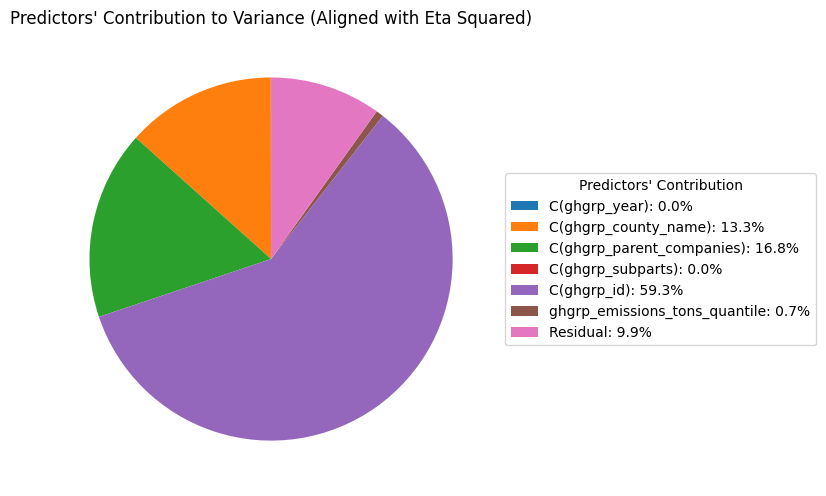

In [ ]:
# Plot Predictors' Contribution

total_sum_sq = anova_table['sum_sq'].sum()  # Total variance including residual
factor_names = anova_table.index
factor_sum_sq = anova_table['sum_sq']

# Calculate Partial Eta Squared-like percentages
percentages = factor_sum_sq / total_sum_sq * 100

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, _ = ax.pie(factor_sum_sq, startangle=90)

# Prepare the legend labels with factor names and percentages
labels_with_values = [f"{name}: {pct:.1f}%" for name, pct in zip(factor_names, percentages)]

# Add legend to the right side of the chart
ax.legend(wedges, labels_with_values, title="Predictors' Contribution", loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

# Add title
plt.title("Predictors' Contribution to Variance (Aligned with Eta Squared)")

plt.tight_layout()
plt.show()

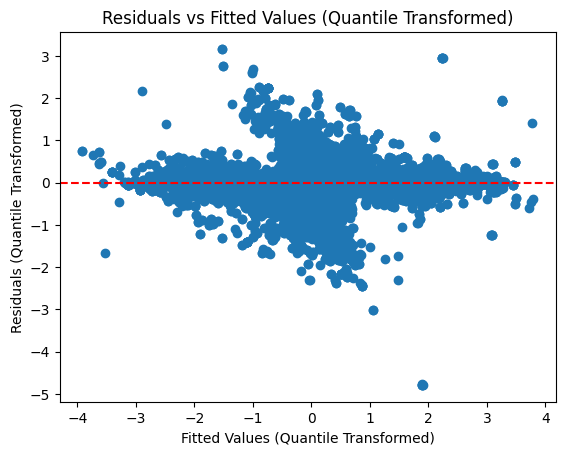

In [ ]:
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values (Quantile Transformed)")
plt.xlabel("Fitted Values (Quantile Transformed)")
plt.ylabel("Residuals (Quantile Transformed)")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Fit the model on the training set
model_train = ols(model_formula, data=train_data).fit()

# Predict on the testing set
test_data['predicted'] = model_train.predict(test_data)

# Calculate R-squared for the testing set
test_r_squared = 1 - (sum((test_data['emissions_discrepancy_quantile'] - test_data['predicted'])**2) /
                      sum((test_data['emissions_discrepancy_quantile'] - test_data['emissions_discrepancy_quantile'].mean())**2))

print(f"Test R-squared: {test_r_squared:.3f}")

Test R-squared: 0.861


In [ ]:
# Compute original R-squared and Adjusted R-squared
original_r_squared = model.rsquared
original_adj_r_squared = model.rsquared_adj

print(f"\nOriginal R-squared (Quantile Transformed): {original_r_squared:.4f}")
print(f"Original Adjusted R-squared (Quantile Transformed): {original_adj_r_squared:.4f}")


Original R-squared (Quantile Transformed): 0.9097
Original Adjusted R-squared (Quantile Transformed): 0.8921


In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Initialize KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Containers for R-squared and adjusted R-squared values
r_squared_list = []
adj_r_squared_list = []

print("Performing 5-Fold Cross-Validation with Quantile Transformed Variables...")

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(df):
    # Split data into training and validation sets
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    # Fit the model on the training set
    model = ols(model_formula, data=train_df).fit()

    # Predict on the validation set
    test_y = test_df['emissions_discrepancy_quantile']
    test_y_pred = model.predict(test_df)

    # Calculate R-squared
    ss_total = np.sum((test_y - test_y.mean()) ** 2)
    ss_residual = np.sum((test_y - test_y_pred) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    r_squared_list.append(r_squared)

    # Calculate Adjusted R-squared
    n = len(test_y)
    p = model.df_model
    adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
    adj_r_squared_list.append(adj_r_squared)

# Print Cross-Validation Results
mean_r_squared = np.mean(r_squared_list)
mean_adj_r_squared = np.mean(adj_r_squared_list)

print(f"\nR-squared values across folds (Quantile Transformed): {r_squared_list}")
print(f"Adjusted R-squared values across folds (Quantile Transformed): {adj_r_squared_list}")
print(f"\nMean R-squared: {mean_r_squared:.4f}")
print(f"Mean Adjusted R-squared: {mean_adj_r_squared:.4f}")

Performing 5-Fold Cross-Validation with Quantile Transformed Variables...

R-squared values across folds (Quantile Transformed): [0.8559051494699735, 0.870181952979148, 0.8629554512335396, 0.8476459017523071, 0.8612580875863052]
Adjusted R-squared values across folds (Quantile Transformed): [0.2922041436739986, 0.3688494447604307, 0.32865518515670644, 0.24473480757655253, 0.3282762288894925]

Mean R-squared: 0.8596
Mean Adjusted R-squared: 0.3125


**Key Observations:**


1.	Residual Normality (Shapiro-Wilk Test): Residuals are not normally distributed, violating a key assumption of classical ANOVA models. While the quantile transformation improves normality, the residuals still deviate significantly from normality.
2.	Homogeneity of Variance (Levene’s Test): Homoscedasticity is still violated. The residual variance differs significantly across groups, requiring robust standard errors or alternative modeling approaches.
3.	Heteroscedasticity (Breusch-Pagan Test): Strong evidence of heteroscedasticity persists, emphasizing the need for models designed to handle such variance patterns.
4.	Omnibus and Jarque-Bera Tests: Confirm heavy-tailed residual distributions, suggesting the presence of outliers or over-dispersion in the data.
5.	Model Overfitting: The slight overfitting observed through the disparity between R-squared and Adjusted R-squared highlights the challenge of high dimensionality in the predictor set.
6.	Adjusted R-squared Discrepancy: The notably lower Adjusted R-squared reflects high dimensionality, redundancy, and the penalty applied to models with numerous predictors.








**Next steps:**


*   VDA with Robust Standard Errors: The violations of residual assumptions (non-normality and heteroscedasticity) justify using models with robust standard errors to ensure valid statistical inference.
*   Elastic Net:  valuable for handling multicollinearity and regularizing coefficients.



# ANOVA VDA with Robust Standard Errors

## Run model

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
import re
from google.colab import drive

# Define the model save/load path
MODEL_PATH = '/content/drive/MyDrive/Master_Thesis/simplified_anova_model.pkl'

# Load data
df = matched_dfs["5m"].copy()

# Apply Quantile Transformation
qt = QuantileTransformer(output_distribution='normal', random_state=42)

# Transform dependent variable (emissions_discrepancy)
df['emissions_discrepancy_transformed'] = qt.fit_transform(df[['emissions_discrepancy']])

# Transform explanatory variable (ghgrp_emissions_tons)
df['ghgrp_emissions_tons_transformed'] = qt.fit_transform(df[['ghgrp_emissions_tons']])

# Ensure variables are of the correct data type
df['ghgrp_year'] = df['ghgrp_year'].astype(int)

# Preprocessing functions
def process_parent_companies(value):
    if pd.isna(value):
        return ["Other"]  # Replace NaN with 'Other'
    cleaned_value = re.sub(r'\([^)]*\)', '', str(value))
    companies = [company.strip() for company in cleaned_value.split(';')]
    return companies

def process_subparts(value):
    if pd.isna(value):
        return []
    subparts = [subpart.strip() for subpart in str(value).split(',')]
    return subparts

# Apply the processing functions
df['ghgrp_parent_companies'] = df['ghgrp_parent_companies'].apply(process_parent_companies)
df['ghgrp_subparts'] = df['ghgrp_subparts'].apply(process_subparts)

# Explode both parent companies and subparts
df = df.explode('ghgrp_parent_companies')
df = df.explode('ghgrp_subparts')

# Convert to categorical
df['ghgrp_parent_companies'] = df['ghgrp_parent_companies'].astype('category')
df['ghgrp_county_name'] = df['ghgrp_county_name'].astype('category')
df['ghgrp_subparts'] = df['ghgrp_subparts'].astype('category')
df['ghgrp_id'] = df['ghgrp_id'].astype('category')  # Convert ghgrp_id to categorical

# Define ANOVA model
def run_model(df, formula):
    model = ols(formula, data=df).fit(cov_type='HC0')
    return model

model_formula = (
    'emissions_discrepancy_transformed ~ '
    'C(ghgrp_year) + ghgrp_emissions_tons_transformed + '
    'C(ghgrp_county_name) + C(ghgrp_parent_companies) + '
    'C(ghgrp_subparts) + C(ghgrp_id)'
)

# Check if the model already exists in Google Drive
if os.path.exists(MODEL_PATH):
    print("Loading the saved model from Google Drive...")
    with open(MODEL_PATH, 'rb') as file:
        simplified_model = pickle.load(file)
else:
    # Run the full model
    print("Fitting the full ANOVA model...")
    full_model = run_model(df, model_formula)

    # Identify minimally contributing categories
    def identify_minimal_contributors(model, df, variable, threshold=0.1):
        group_means = df.groupby(variable)['emissions_discrepancy_transformed'].mean()
        overall_mean = df['emissions_discrepancy_transformed'].mean()
        group_sizes = df[variable].value_counts()
        group_contributions = group_sizes * (group_means - overall_mean)**2

        total_variance = df['emissions_discrepancy_transformed'].var()
        variance_proportions = (group_contributions / total_variance) * 100

        minimal_contributors = variance_proportions[variance_proportions < threshold].index
        return minimal_contributors

    # Identify minimally contributing parent companies, subparts, and IDs
    min_contributing_parent_companies = identify_minimal_contributors(full_model, df, 'ghgrp_parent_companies')
    min_contributing_subparts = identify_minimal_contributors(full_model, df, 'ghgrp_subparts')
    min_contributing_ids = identify_minimal_contributors(full_model, df, 'ghgrp_id')

    print(f"\nNumber of minimally contributing parent companies: {len(min_contributing_parent_companies)}")
    print(f"Number of minimally contributing subparts: {len(min_contributing_subparts)}")
    print(f"Number of minimally contributing IDs: {len(min_contributing_ids)}")

    # Group minimal contributors into "Other"
    df['ghgrp_parent_companies_grouped'] = df['ghgrp_parent_companies'].apply(
        lambda x: 'Other' if x in min_contributing_parent_companies else x
    )
    df['ghgrp_subparts_grouped'] = df['ghgrp_subparts'].apply(
        lambda x: 'Other' if x in min_contributing_subparts else x
    )
    df['ghgrp_id_grouped'] = df['ghgrp_id'].apply(
        lambda x: 'Other' if x in min_contributing_ids else x
    )

    # Define the model with grouped variables and interaction
    model_formula_grouped = (
        'emissions_discrepancy_transformed ~ '
        'C(ghgrp_year) + ghgrp_emissions_tons_transformed + '
        'C(ghgrp_county_name) + C(ghgrp_parent_companies_grouped) + '
        'C(ghgrp_subparts_grouped) + C(ghgrp_id_grouped)'
    )

    # Rerun the model with grouped variables
    print("\nFitting the simplified ANOVA model...")
    simplified_model = run_model(df, model_formula_grouped)

    # Save the simplified model to Google Drive
    print("Saving the simplified model to Google Drive...")
    with open(MODEL_PATH, 'wb') as file:
        pickle.dump(simplified_model, file)

# Display the simplified model summary
print("\nSimplified Model Summary with Grouped Variables:")
print(simplified_model.summary())

Fitting the full ANOVA model...


<ipython-input-68-69e268dd4aad>:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = df.groupby(variable)['emissions_discrepancy_transformed'].mean()
<ipython-input-68-69e268dd4aad>:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = df.groupby(variable)['emissions_discrepancy_transformed'].mean()
<ipython-input-68-69e268dd4aad>:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = df.gro


Number of minimally contributing parent companies: 39
Number of minimally contributing subparts: 0
Number of minimally contributing IDs: 59

Fitting the simplified ANOVA model...
Saving the simplified model to Google Drive...

Simplified Model Summary with Grouped Variables:


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6762, but rank is 4286
  warnings.warn('covariance of constraints does not have full '


                                    OLS Regression Results                                   
Dep. Variable:     emissions_discrepancy_transformed   R-squared:                       0.910
Model:                                           OLS   Adj. R-squared:                  0.892
Method:                                Least Squares   F-statistic:                 1.114e+06
Date:                               Sun, 05 Jan 2025   Prob (F-statistic):               0.00
Time:                                       09:26:36   Log-Likelihood:                -10942.
No. Observations:                              29031   AIC:                         3.135e+04
Df Residuals:                                  24298   BIC:                         7.052e+04
Df Model:                                       4732                                         
Covariance Type:                                 HC0                                         
                                                            

In [ ]:
# Perform ANOVA on the simplified model
anova_table = sm.stats.anova_lm(simplified_model, typ=2)

# Calculate Partial Eta Squared
anova_table['Partial Eta Squared'] = anova_table['sum_sq'] / anova_table['sum_sq'].sum()

# Copy p-values and determine significance
anova_table['p-value'] = anova_table['PR(>F)']
anova_table['Significant'] = anova_table['p-value'] < 0.05

# Print and display the updated ANOVA table
print("\nUpdated ANOVA Table for Simplified Model (Transformed Dependent Variable):")
display(anova_table)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 985, but rank is 973
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2250, but rank is 2092
  warnings.warn('covariance of constraints does not have full '



Updated ANOVA Table for Simplified Model (Transformed Dependent Variable):


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3483, but rank is 3374
  warnings.warn('covariance of constraints does not have full '


sum_sq       df              F  \
C(ghgrp_year)                      1.221731e+01      7.0      11.740426   
C(ghgrp_county_name)               1.864718e+06    985.0   12734.540803   
C(ghgrp_parent_companies_grouped)  3.116520e+07   2250.0   93173.785860   
C(ghgrp_subparts_grouped)          1.877359e+00     36.0       0.350793   
C(ghgrp_id_grouped)                1.813477e+08   3483.0  350239.378801   
ghgrp_emissions_tons_transformed   6.638649e+01      1.0     446.566438   
Residual                           3.612136e+03  24298.0            NaN   

                                         PR(>F)  Partial Eta Squared  \
C(ghgrp_year)                      5.250058e-15         5.698868e-08   
C(ghgrp_county_name)               0.000000e+00         8.698136e-03   
C(ghgrp_parent_companies_grouped)  0.000000e+00         1.453727e-01   
C(ghgrp_subparts_grouped)          9.998928e-01         8.757102e-09   
C(ghgrp_id_grouped)                0.000000e+00         8.459119e-01   
ghgrp_emissions_tons_transformed   3.087731e-98         3.096655e-07   
Residual                                    NaN         1.684912e-05   

                                        p-value  Significant  
C(ghgrp_year)                      5.250058e-15         True  
C(ghgrp_county_name)               0.000000e+00         True  
C(ghgrp_parent_companies_grouped)  0.000000e+00         True  
C(ghgrp_subparts_grouped)          9.998928e-01        False  
C(ghgrp_id_grouped)                0.000000e+00         True  
ghgrp_emissions_tons_transformed   3.087731e-98         True  
Residual                                    NaN        False

## Residual analyis

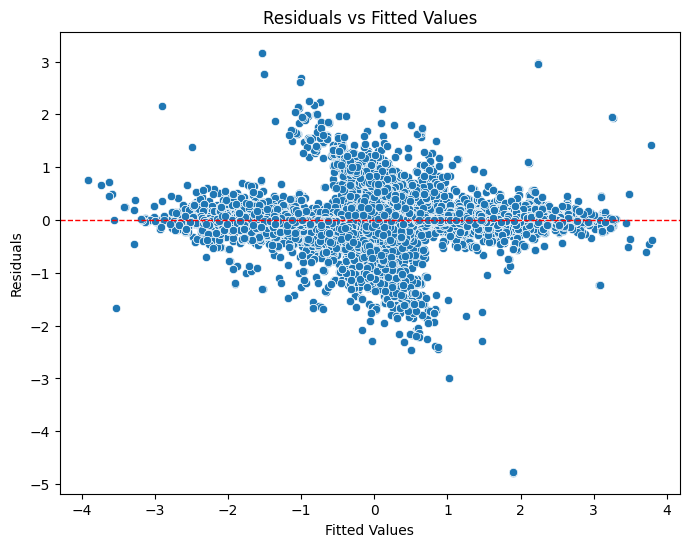

In [ ]:
# Residuals vs. Fitted Values Plot for Simplified Model
plt.figure(figsize=(8, 6))

# Plot residuals against fitted values
sns.scatterplot(x=simplified_model.fittedvalues, y=simplified_model.resid)
plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Titles and labels
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

# Display the plot
plt.show()

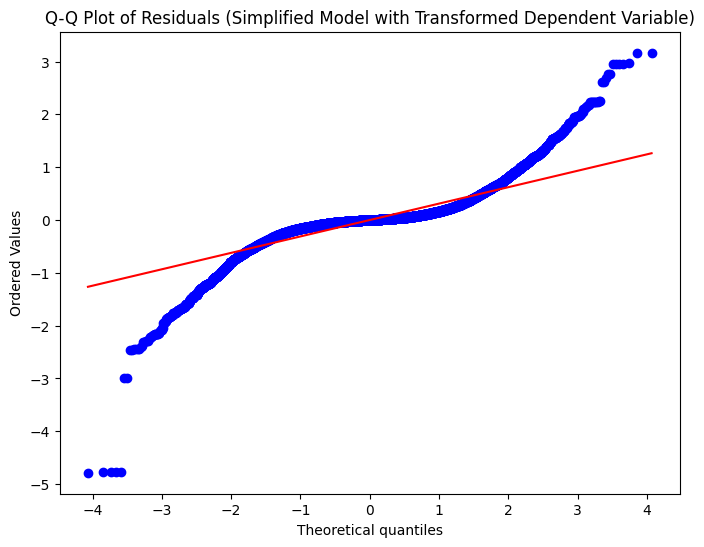

In [ ]:
from scipy.stats import probplot

# Q-Q Plot for Residuals of Simplified Model
plt.figure(figsize=(8, 6))

# Generate Q-Q plot for residuals
probplot(simplified_model.resid, dist="norm", plot=plt)

# Title for the plot
plt.title("Q-Q Plot of Residuals (Simplified Model with Transformed Dependent Variable)")

# Display the plot
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Breusch-Pagan test for Simplified Model
bp_test = het_breuschpagan(simplified_model.resid, simplified_model.model.exog)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

print("\nBreusch-Pagan Test Results for Simplified Model:")
print(dict(zip(bp_labels, bp_test)))


Breusch-Pagan Test Results for Simplified Model:
{'Lagrange multiplier statistic': 14298.699302577608, 'p-value': 0.0, 'f-value': 4.983698380185764, 'f p-value': 0.0}


In [ ]:
from scipy.stats import shapiro

# Shapiro-Wilk test for Residuals of Simplified Model
shapiro_test = shapiro(simplified_model.resid)
print("\nShapiro-Wilk Test for Normality (Simplified Model):")
print(f"Statistic: {shapiro_test.statistic:.3f}, p-value: {shapiro_test.pvalue:.3e}")


Shapiro-Wilk Test for Normality (Simplified Model):
Statistic: 0.777, p-value: 1.344e-104


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29031.
  res = hypotest_fun_out(*samples, **kwds)


## Model performance

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import QuantileTransformer

# Quantile transformation for explanatory and dependent variables
qt = QuantileTransformer(output_distribution='normal', random_state=42)

# Apply the transformation to the explanatory and dependent variables
df['ghgrp_emissions_tons_quantile'] = qt.fit_transform(df[['ghgrp_emissions_tons']])
df['emissions_discrepancy_quantile'] = qt.fit_transform(df[['emissions_discrepancy']])

# Prepare data for the simplified model
X_cv = pd.get_dummies(df[['ghgrp_year', 'ghgrp_emissions_tons_quantile', 'ghgrp_county_name',
                          'ghgrp_parent_companies_grouped', 'ghgrp_subparts_grouped', 'ghgrp_id']], drop_first=True)
y_cv = df['emissions_discrepancy_quantile']

# Linear regression model
linear_model = LinearRegression()

# Perform cross-validation for MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # Negative MSE for consistency
cv_mse_scores = cross_val_score(linear_model, X_cv, y_cv, cv=5, scoring=mse_scorer)

# Perform cross-validation for R^2
cv_r2_scores = cross_val_score(linear_model, X_cv, y_cv, cv=5, scoring='r2')

# Cross-validation predictions for evaluation
y_cv_pred = cross_val_predict(linear_model, X_cv, y_cv, cv=5)

# Calculate additional metrics
mean_absolute_error = np.mean(np.abs(y_cv - y_cv_pred))
total_variance = np.var(y_cv)
explained_variance = total_variance - np.var(y_cv - y_cv_pred)

# Output cross-validation results
print("\nCross-Validation Results for Simplified Model:")
print(f"Mean CV MSE: {np.mean(cv_mse_scores):.4f}")
print(f"CV MSE Standard Deviation: {np.std(cv_mse_scores):.4f}")
print(f"Mean CV R-squared: {np.mean(cv_r2_scores):.4f}")
print(f"Explained Variance: {explained_variance / total_variance:.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error:.4f}")


Cross-Validation Results for Simplified Model:
Mean CV MSE: -0.1948
CV MSE Standard Deviation: 0.0511
Mean CV R-squared: 0.7980
Explained Variance: 0.8064
Mean Absolute Error (MAE): 0.2391


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Prepare data for the simplified model
X_simplified = pd.get_dummies(df[['ghgrp_year', 'ghgrp_emissions_tons_quantile', 'ghgrp_county_name',
                                  'ghgrp_parent_companies_grouped', 'ghgrp_subparts_grouped', 'ghgrp_id']], drop_first=True)
y_simplified = df['emissions_discrepancy_quantile']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_simplified, y_simplified, test_size=0.3, random_state=42)

# Fit the model
linear_model.fit(X_train, y_train)

# Predict on test data
y_pred = linear_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"\nMean Absolute Error (MAE) on Test Data (Simplified Model): {mae:.4f}")


Mean Absolute Error (MAE) on Test Data (Simplified Model): 0.1936


In [ ]:
# MAE on transformed scale
mae_transformed = np.array([[0.1936]])

# Backtransform MAE to the original scale
mae_original = qt.inverse_transform(mae_transformed)

print(f"MAE in original scale (tons): {mae_original[0][0]:.4f}")

MAE in original scale (tons): -1.0456


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


## Predictor importance

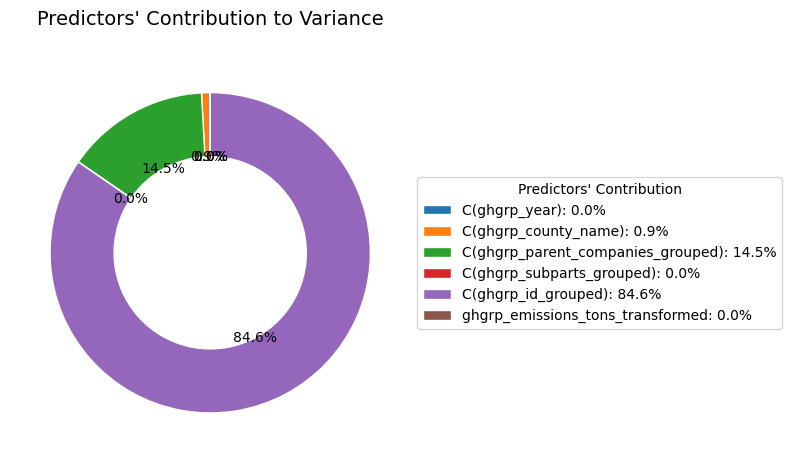

In [ ]:
import matplotlib.pyplot as plt

# Exclude residuals from the ANOVA table
anova_table_no_residuals = anova_table.drop(index='Residual', errors='ignore')

# Recalculate percentages without residuals
total_sum_sq_no_residuals = anova_table_no_residuals['sum_sq'].sum()
anova_table_no_residuals['Percentage'] = (
    anova_table_no_residuals['sum_sq'] / total_sum_sq_no_residuals
) * 100

# Extract data for visualization
factor_names = anova_table_no_residuals.index
factor_sum_sq = anova_table_no_residuals['sum_sq']
percentages = anova_table_no_residuals['Percentage']

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    factor_sum_sq,
    labels=None,  # Avoid overlapping text, legend will provide labels
    startangle=90,
    wedgeprops=dict(width=0.4, edgecolor='w'),
    autopct='%1.1f%%'
)

# Prepare legend labels with factor names and percentages
labels_with_values = [
    f"{name}: {pct:.1f}%" for name, pct in zip(factor_names, percentages)
]
ax.legend(
    wedges,
    labels_with_values,
    title="Predictors' Contribution",
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

# Add title
plt.title("Predictors' Contribution to Variance", fontsize=14, pad=20)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
sum_of_predictors = anova_table['sum_sq'].sum()
print(f"Sum of Squares for Predictors: {sum_of_predictors}")
print(f"Residual Sum of Squares: {simplified_model.ssr}")
print(f"Total Sum of Squares (Predictors + Residuals): {sum_of_predictors + simplified_model.ssr}")

Sum of Squares for Predictors: 214381308.30819383
Residual Sum of Squares: 3612.1363433480024
Total Sum of Squares (Predictors + Residuals): 214384920.4445372


# Elastic Net Model (using Regularization)

In [ ]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer
from scipy.stats import boxcox, yeojohnson
import numpy as np

# Define transformations
def log_transform(x):
    return np.log1p(x)  # Log(1 + x) to handle zeros

def sqrt_transform(x):
    return np.sqrt(x)

def boxcox_transform(x):
    return boxcox(x + abs(x.min()) + 1)[0]  # Add constant to avoid negatives

def yeo_johnson_transform(x):
    return yeojohnson(x)[0]

# Dictionary of transformations to test
transformations = {
    "Log": log_transform,
    "Square Root": sqrt_transform,
    "Box-Cox": boxcox_transform,
    "Yeo-Johnson": yeo_johnson_transform
}

# Apply each transformation and evaluate
results = {}
for name, func in transformations.items():
    try:
        # Apply transformation
        df['emissions_discrepancy_transformed'] = func(df['emissions_discrepancy'])
        df['ghgrp_emissions_tons_transformed'] = func(df['ghgrp_emissions_tons'])

        # Refit model and evaluate
        model = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)  # Example params
        model.fit(X, y)  # Replace with your transformed X, y
        results[name] = {
            "Train R²": model.score(X_train, y_train),
            "Test R²": model.score(X_test, y_test),
            "MAE": mean_absolute_error(y_test, model.predict(X_test))
        }
    except Exception as e:
        print(f"Transformation {name} failed: {e}")

# Compare results
print(results)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'Log': {'Train R²': 0.8926063193948577, 'Test R²': 0.896908568403678, 'MAE': 0.19552466405330857}, 'Square Root': {'Train R²': 0.8926063193948577, 'Test R²': 0.896908568403678, 'MAE': 0.19552466405330857}, 'Box-Cox': {'Train R²': 0.8926063193948577, 'Test R²': 0.896908568403678, 'MAE': 0.19552466405330857}, 'Yeo-Johnson': {'Train R²': 0.8926063193948577, 'Test R²': 0.896908568403678, 'MAE': 0.19552466405330857}}


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score, mean_absolute_error
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Load data
df = matched_dfs["5m"].copy()

# Dependent and explanatory variables
y = df['emissions_discrepancy'].values  # Original dependent variable
X = df[['ghgrp_emissions_tons']].values  # Explanatory variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a dictionary to store results
results = {}

# 1. No Transformation
elastic_net_no_transform = ElasticNetCV(cv=5, random_state=42, n_jobs=-1)
elastic_net_no_transform.fit(X_train, y_train)

# Predictions and metrics for no transformation
y_pred_train_no_transform = elastic_net_no_transform.predict(X_train)
y_pred_test_no_transform = elastic_net_no_transform.predict(X_test)
results['No Transformation'] = {
    'Train R²': r2_score(y_train, y_pred_train_no_transform),
    'Test R²': r2_score(y_test, y_pred_test_no_transform),
    'MAE': mean_absolute_error(y_test, y_pred_test_no_transform)
}

# 2. Yeo-Johnson Transformation
# Apply Yeo-Johnson to the dependent variable
transformer = PowerTransformer(method='yeo-johnson', standardize=True)
y_train_transformed = transformer.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_transformed = transformer.transform(y_test.reshape(-1, 1)).flatten()

elastic_net_yeo_johnson = ElasticNetCV(cv=5, random_state=42, n_jobs=-1)
elastic_net_yeo_johnson.fit(X_train, y_train_transformed)

# Predictions and metrics for Yeo-Johnson transformation
y_pred_train_yeo_johnson = elastic_net_yeo_johnson.predict(X_train)
y_pred_test_yeo_johnson = elastic_net_yeo_johnson.predict(X_test)
results['Yeo-Johnson Transformation'] = {
    'Train R²': r2_score(y_train_transformed, y_pred_train_yeo_johnson),
    'Test R²': r2_score(y_test_transformed, y_pred_test_yeo_johnson),
    'MAE': mean_absolute_error(y_test_transformed, y_pred_test_yeo_johnson)
}

# Display the results
for transformation, metrics in results.items():
    print(f"\nResults for {transformation}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Results for No Transformation:
Train R²: 0.2547
Test R²: 0.2479
MAE: 248681.7098

Results for Yeo-Johnson Transformation:
Train R²: 0.1896
Test R²: 0.1894
MAE: 0.3537


Yeo-Johnson

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import re

# Path to save/load Elastic Net results
elastic_net_results_path = "/content/drive/MyDrive/Master_Thesis/elastic_net_results.pkl"

# Check if results already exist
if os.path.exists(elastic_net_results_path):
    print("Elastic Net results found. Loading from file...")
    with open(elastic_net_results_path, "rb") as file:
        results = pickle.load(file)
    optimal_alpha = results["optimal_alpha"]
    optimal_l1_ratio = results["optimal_l1_ratio"]
    elastic_net_train_r2 = results["train_r2"]
    elastic_net_train_mse = results["train_mse"]
    elastic_net_test_r2 = results["test_r2"]
    elastic_net_test_mse = results["test_mse"]
    print("Elastic Net results successfully loaded.")
else:
    # Load data
    df = matched_dfs["5m"].copy()

    # Apply quantile transformation to numeric variables
    qt = QuantileTransformer(output_distribution='normal', random_state=42)
    df['emissions_discrepancy_quantile'] = qt.fit_transform(df[['emissions_discrepancy']])
    df['ghgrp_emissions_tons_quantile'] = qt.fit_transform(df[['ghgrp_emissions_tons']])

    # Ensure variables are of the correct data type
    df['ghgrp_year'] = df['ghgrp_year'].astype(int)

    # Preprocessing functions
    def process_parent_companies(value):
        if pd.isna(value):
            return ["Other"]  # Replace NaN with 'Other'
        cleaned_value = re.sub(r'\([^)]*\)', '', str(value))
        companies = [company.strip() for company in cleaned_value.split(';')]
        return companies

    def process_subparts(value):
        if pd.isna(value):
            return []
        subparts = [subpart.strip() for subpart in str(value).split(',')]
        return subparts

    # Apply the processing functions
    df['ghgrp_parent_companies'] = df['ghgrp_parent_companies'].apply(process_parent_companies)
    df['ghgrp_subparts'] = df['ghgrp_subparts'].apply(process_subparts)

    # Explode both parent companies and subparts
    df = df.explode('ghgrp_parent_companies')
    df = df.explode('ghgrp_subparts')

    # Convert to categorical
    df['ghgrp_parent_companies'] = df['ghgrp_parent_companies'].astype('category')
    df['ghgrp_county_name'] = df['ghgrp_county_name'].astype('category')
    df['ghgrp_subparts'] = df['ghgrp_subparts'].astype('category')
    df['ghgrp_id'] = df['ghgrp_id'].astype('category')  # Convert ghgrp_id to categorical

    # Add hierarchical interaction terms
    df['parent_county_interaction'] = df['ghgrp_parent_companies'].astype(str) + "_" + df['ghgrp_county_name'].astype(str)

    # Create dummy variables for modeling, including ghgrp_id
    X = pd.get_dummies(
        df[['ghgrp_year', 'ghgrp_emissions_tons_quantile', 'ghgrp_county_name', 'ghgrp_parent_companies',
            'ghgrp_subparts', 'ghgrp_id']],
        drop_first=True
    )
    y = df['emissions_discrepancy_quantile']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Determine optimal alpha and l1_ratio using ElasticNetCV
    print("Finding optimal alpha and l1_ratio using ElasticNetCV...")
    elastic_net_cv = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0], cv=5, random_state=42, n_jobs=-1)
    elastic_net_cv.fit(X_train, y_train)

    optimal_alpha = elastic_net_cv.alpha_
    optimal_l1_ratio = elastic_net_cv.l1_ratio_
    print(f"Optimal alpha: {optimal_alpha}")
    print(f"Optimal l1_ratio: {optimal_l1_ratio}")

    # Apply ElasticNet with optimal parameters
    elastic_net = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio, random_state=42).fit(X_train, y_train)

    # Evaluate Elastic Net model on training data
    elastic_net_train_r2 = elastic_net.score(X_train, y_train)
    elastic_net_train_mse = mean_squared_error(y_train, elastic_net.predict(X_train))

    # Evaluate Elastic Net model on test data
    elastic_net_test_r2 = elastic_net.score(X_test, y_test)
    elastic_net_test_mse = mean_squared_error(y_test, elastic_net.predict(X_test))

    # Save results to file
    results = {
        "optimal_alpha": optimal_alpha,
        "optimal_l1_ratio": optimal_l1_ratio,
        "train_r2": elastic_net_train_r2,
        "train_mse": elastic_net_train_mse,
        "test_r2": elastic_net_test_r2,
        "test_mse": elastic_net_test_mse,
    }
    with open(elastic_net_results_path, "wb") as file:
        pickle.dump(results, file)
    print("Elastic Net results saved to file.")

Elastic Net results found. Loading from file...
Elastic Net results successfully loaded.


## Model performance

In [ ]:
# Print model performance metrics
print("\nElastic Net model performance:")
print(f"Train R-squared: {elastic_net_train_r2:.4f}")
print(f"Train Mean Squared Error (MSE): {elastic_net_train_mse:.4f}")
print(f"Test R-squared: {elastic_net_test_r2:.4f}")
print(f"Test Mean Squared Error (MSE): {elastic_net_test_mse:.4f}")


Elastic Net model performance:
Train R-squared: 0.5732
Train Mean Squared Error (MSE): 0.5872
Test R-squared: 0.5388
Test Mean Squared Error (MSE): 0.6336


In [ ]:
# Rank features by importance
elastic_net_coeffs = pd.Series(elastic_net.coef_, index=X.columns)

# Extract top features by absolute value of coefficients
top_features = elastic_net_coeffs.abs().sort_values(ascending=False).head(10)

print("\nTop 10 most influential features:")
print(top_features)

NameError: name 'elastic_net' is not defined

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.linear_model import ElasticNet
from tqdm import tqdm  # For the progress bar

# Path to save/load bootstrap results
elasticnet_bootstrap_path = "/content/drive/MyDrive/Master_Thesis/elasticnet_bootstrap_results.pkl"

# Parameters
n_bootstraps = 100

# Check if bootstrap results already exist
if os.path.exists(elasticnet_bootstrap_path):
    print("Bootstrap results found. Loading from file...")
    with open(elasticnet_bootstrap_path, "rb") as file:
        coefs_array = pickle.load(file)
    print("Bootstrap results successfully loaded.")
else:
    print("Bootstrap results not found. Performing bootstrapping...")
    # Initialize a NumPy array for coefficients
    coefs_array = np.zeros((X_train.shape[1], n_bootstraps))

    # Precompute bootstrap samples
    bootstrap_samples = [(resample(X_train, y_train, random_state=i)) for i in range(n_bootstraps)]

    # Perform bootstrapping with ElasticNet
    print("Performing bootstrapping...")
    for i, (X_resampled, y_resampled) in tqdm(enumerate(bootstrap_samples), total=n_bootstraps, desc="Bootstrapping Elastic Net coefficients"):
        # Fit ElasticNet model with optimal parameters
        model_bootstrap = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio, random_state=i).fit(X_resampled, y_resampled)
        coefs_array[:, i] = model_bootstrap.coef_

    # Save the results
    with open(elasticnet_bootstrap_path, "wb") as file:
        pickle.dump(coefs_array, file)
    print(f"Bootstrap results saved to: {elasticnet_bootstrap_path}")

# Convert coefficients array to DataFrame
coefs_bootstrap = pd.DataFrame(coefs_array, index=X_train.columns)

# Calculate mean coefficient and confidence intervals
coef_mean = coefs_bootstrap.mean(axis=1)
coef_lower = coefs_bootstrap.quantile(0.025, axis=1)
coef_upper = coefs_bootstrap.quantile(0.975, axis=1)

# Create a summary DataFrame
coef_summary = pd.DataFrame({
    "Mean Coefficient": coef_mean,
    "Lower CI (2.5%)": coef_lower,
    "Upper CI (97.5%)": coef_upper,
    "Significant": (coef_lower > 0) | (coef_upper < 0)  # Significant if CI does not cross zero
}).sort_values("Mean Coefficient", ascending=False)

# Display top 10 results
print("\nBootstrap Coefficient Summary:")
print(coef_summary.head(10))

In [ ]:
# Aggregate the importance and significance of predictors by group
group_map = {
    'ghgrp_year': 'ghgrp_year',
    'ghgrp_emissions_tons_boxcox': 'ghgrp_emissions_tons',
    'ghgrp_county_name': 'ghgrp_county_name',
    'ghgrp_parent_companies': 'ghgrp_parent_companies',
    'ghgrp_subparts': 'ghgrp_subparts',
    'ghgrp_id': 'ghgrp_id'
}

group_contributions = {}

for group, name in group_map.items():
    # Filter columns belonging to the current group
    group_cols = [col for col in coef_summary.index if group in col]

    if group_cols:  # Ensure the group has columns
        # Aggregate total contribution and count significant predictors
        total_contribution = coef_summary.loc[group_cols, "Mean Coefficient"].abs().sum()
        significant_count = coef_summary.loc[group_cols, "Significant"].sum()  # Count of significant predictors

        group_contributions[name] = {
            "Total Contribution": total_contribution,
            "Percentage": 100 * total_contribution / coef_summary["Mean Coefficient"].abs().sum(),
            "Significant Predictors": significant_count,
            "Total Predictors": len(group_cols)
        }

# Create a DataFrame for visualization
group_contributions_df = pd.DataFrame.from_dict(group_contributions, orient='index')
group_contributions_df["Significance Percentage"] = (
    group_contributions_df["Significant Predictors"] / group_contributions_df["Total Predictors"]
) * 100

# Display the results
print("\nGroup Contributions Summary with Significance:")
display(group_contributions_df)

In [ ]:
# Visualization (e.g., pie chart)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(group_contributions_df)))

# Plot pie chart
wedges, texts, autotexts = ax.pie(
    group_contributions_df['Percentage'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)

# Add a legend to the right with percentages and significance
labels = [
    f"{index} ({row['Percentage']:.1f}%, {row['Significance Percentage']:.1f}% Sig.)"
    for index, row in group_contributions_df.iterrows()
]
ax.legend(
    wedges,
    labels,
    title="Groups (Contribution %, Sig. %)",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)

plt.title("Predictor Group Contributions and Significance (Elastic Net with ghgrp_id)")
plt.tight_layout()
plt.show()

## Residual diagnostics

In [ ]:
sns.scatterplot(x=elastic_net.predict(X_test), y=y_test - elastic_net.predict(X_test))
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values (Elastic Net)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [ ]:
from scipy.stats import probplot

# Q-Q plot
probplot(y_test - elastic_net.predict(X_test), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Elastic Net)")
plt.show()

## Validation

In [ ]:
import os
import pickle
import numpy as np
from sklearn.model_selection import cross_val_score

# Path to save/load cross-validation results
cv_results_path = "/content/drive/MyDrive/Master_Thesis/elasticnet_cv_results.pkl"

# Sample a subset of the data for cross-validation
X_sampled, y_sampled = X.sample(frac=0.5, random_state=42), y.sample(frac=0.5, random_state=42)

# Check if cross-validation results already exist
if os.path.exists(cv_results_path):
    print("Cross-validation results found. Loading from file...")
    with open(cv_results_path, "rb") as file:
        cv_scores = pickle.load(file)
    print("Cross-validation results successfully loaded.")
else:
    print("Cross-validation results not found. Performing cross-validation...")
    # Perform cross-validation
    cv_scores = cross_val_score(elastic_net, X_sampled, y_sampled, cv=5, scoring='r2', n_jobs=-1)

    # Save the results to the drive
    with open(cv_results_path, "wb") as file:
        pickle.dump(cv_scores, file)
    print(f"Cross-validation results saved to: {cv_results_path}")

# Display results
print("\nCross-Validation R^2 Scores:", cv_scores)
print(f"Mean R^2: {np.mean(cv_scores):.4f}")
print(f"Std Dev of R^2: {np.std(cv_scores):.4f}")

# Bayesian Model

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
import os
import re
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1) Data Preprocessing
# ------------------------------------------------------------------------------
def preprocess_data(df, min_prop=0.1):
    # Apply Quantile Transformation
    qt = QuantileTransformer(output_distribution="normal", random_state=42)
    df["emissions_discrepancy_transformed"] = qt.fit_transform(df[["emissions_discrepancy"]])
    df["ghgrp_emissions_tons_transformed"] = qt.fit_transform(df[["ghgrp_emissions_tons"]])

    # Ensure variables are correct type
    df["ghgrp_year"] = df["ghgrp_year"].astype(int)

    # Helper functions for categorical variables
    def process_parent_companies(value):
        if pd.isna(value):
            return ["Other"]
        cleaned_value = re.sub(r"\([^)]*\)", "", str(value))
        companies = [company.strip() for company in cleaned_value.split(";")]
        return companies

    def process_subparts(value):
        if pd.isna(value):
            return []
        subparts = [subpart.strip() for subpart in str(value).split(",")]
        return subparts

    df["ghgrp_parent_companies"] = df["ghgrp_parent_companies"].apply(process_parent_companies)
    df["ghgrp_subparts"] = df["ghgrp_subparts"].apply(process_subparts)

    # Explode categorical variables
    df = df.explode("ghgrp_parent_companies")
    df = df.explode("ghgrp_subparts")

    # Combine rare categories dynamically based on proportion
    def combine_rare_categories(column, min_prop):
        counts = df[column].value_counts(normalize=True)
        rare_categories = counts[counts < min_prop].index
        df.loc[df[column].isin(rare_categories), column] = "Other"
        return df

    df = combine_rare_categories("ghgrp_parent_companies", min_prop=min_prop)
    df = combine_rare_categories("ghgrp_subparts", min_prop=min_prop)
    df = combine_rare_categories("ghgrp_county_name", min_prop=min_prop)

    # Convert columns to categorical
    df["ghgrp_parent_companies"] = df["ghgrp_parent_companies"].astype("category")
    df["ghgrp_subparts"] = df["ghgrp_subparts"].astype("category")
    df["ghgrp_county_name"] = df["ghgrp_county_name"].astype("category")

    # Encode as integers for modeling
    df["parent_code"] = df["ghgrp_parent_companies"].cat.codes
    df["county_code"] = df["ghgrp_county_name"].cat.codes
    df["subpart_code"] = df["ghgrp_subparts"].cat.codes
    df["facility_code"] = df["ghgrp_id"].astype("category").cat.codes
    df["year_code"] = df["ghgrp_year"].astype("category").cat.codes

    return df


# ------------------------------------------------------------------------------
# 2) Load & Preprocess a Subset of the Data
# ------------------------------------------------------------------------------
print("Loading and preprocessing a subset of the data...")
df = matched_dfs["5m"].copy()
df_sample = df.sample(frac=0.05, random_state=42).copy()  # Use 5% of the data
df_sample = preprocess_data(df_sample, min_prop=0.1)
subset_size = 200  # Instead of 888
df_subset = df.sample(subset_size, random_state=42).copy()

# Extract response variable and predictors
y = df_sample["emissions_discrepancy_transformed"].values
X = df_sample[["ghgrp_emissions_tons_transformed"]].values
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)  # Center and scale

# Prepare indices for hierarchical levels
parent_idx = df_sample["parent_code"].values
facility_idx = df_sample["facility_code"].values
year_idx = df_sample["year_code"].values
county_idx = df_sample["county_code"].values
subpart_idx = df_sample["subpart_code"].values

# Unique counts for the subset
n_parent = df_sample["parent_code"].nunique()
n_facility = df_sample["facility_code"].nunique()
n_year = df_sample["year_code"].nunique()
n_county = df_sample["county_code"].nunique()
n_subpart = df_sample["subpart_code"].nunique()

# ------------------------------------------------------------------------------
# 3) Model Definition
# ------------------------------------------------------------------------------
# Adjusted priors and sampling parameters
print("Defining the Bayesian model...")
bayesian_model = pm.Model()
with bayesian_model:
    # Global intercept
    intercept = pm.Normal("intercept", mu=0.0, sigma=0.5)  # Tighter prior

    # Random effects with non-centered parameterization
    parent_raw = pm.Normal("parent_raw", mu=0, sigma=1, shape=n_parent)
    facility_raw = pm.Normal("facility_raw", mu=0, sigma=1, shape=n_facility)
    year_raw = pm.Normal("year_raw", mu=0, sigma=1, shape=n_year)
    county_raw = pm.Normal("county_raw", mu=0, sigma=1, shape=n_county)

    # Adjusted priors on group-level standard deviations
    parent_sigma = pm.HalfNormal("parent_sigma", sigma=0.2)
    facility_sigma = pm.HalfNormal("facility_sigma", sigma=0.2)
    year_sigma = pm.HalfNormal("year_sigma", sigma=0.1)
    county_sigma = pm.HalfNormal("county_sigma", sigma=0.2)

    # Scaled random effects
    parent_effect = parent_raw * parent_sigma
    facility_effect = facility_raw * facility_sigma
    year_effect = year_raw * year_sigma
    county_effect = county_raw * county_sigma

    # Random effect contributions
    parent_effect_scaled = parent_effect[parent_idx]
    facility_effect_scaled = facility_effect[facility_idx]
    year_effect_scaled = year_effect[year_idx]
    county_effect_scaled = county_effect[county_idx]

    # Fixed effect(s)
    beta = pm.Normal("beta", mu=0.0, sigma=0.5, shape=X.shape[1])  # Tighter prior

    # Likelihood noise
    sigma = pm.HalfNormal("sigma", sigma=0.5)  # Tighter prior

    # Linear predictor
    mu = (
        intercept
        + parent_effect_scaled
        + facility_effect_scaled
        + pm.math.dot(X, beta)
    )

    # Observed likelihood
    y_obs = pm.StudentT("y_obs", mu=mu, sigma=sigma, nu=3, observed=y)

# Sampling with adjusted parameters
print("Running the model on a small subset...")
with bayesian_model:
    trace = pm.sample(
        draws=1000,  # Keep it lower for testing
        tune=2000,
        chains=2,
        target_accept=0.99,  # Higher target_accept
        max_treedepth=15,    # Increased tree depth
        random_seed=42,
        return_inferencedata=True,
    )

# ------------------------------------------------------------------------------
# 5) Diagnostics and Visualization
# ------------------------------------------------------------------------------
print("Diagnostics and visualization...")
az.summary(
    trace,
    var_names=[
        "intercept",
        "parent_sigma",
        "facility_sigma",
        "year_sigma",
        "county_sigma",
        "subpart_sigma",
        "beta",
        "sigma",
    ]
)
az.plot_trace(
    trace,
    var_names=[
        "intercept",
        "parent_sigma",
        "facility_sigma",
        "year_sigma",
        "county_sigma",
        "subpart_sigma",
        "beta",
        "sigma",
    ]
)
plt.show()

Loading and preprocessing a subset of the data...
Defining the Bayesian model...
Running the model on a small subset...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2824: UserWarning: n_quantiles (1000) is greater than the total number of samples (888). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2824: UserWarning: n_quantiles (1000) is greater than the total number of samples (888). n_quantiles is set to n_samples.
  warnings.warn(


Output()

In [ ]:
# ------------------------------------------------------------------------------
# 6) Posterior Predictive Checks (PPC)
# ------------------------------------------------------------------------------
print("Running Posterior Predictive Checks (PPC)...")
with bayesian_model:
    ppc = pm.sample_posterior_predictive(
        trace,
        var_names=["y_obs"],
        random_seed=42,
        return_inferencedata=True,
    )

az.plot_ppc(ppc, figsize=(10, 5))
plt.title("Posterior Predictive Check (PPC)")
plt.show()

# ------------------------------------------------------------------------------
# 7) Effective Sample Sizes and Convergence Diagnostics
# ------------------------------------------------------------------------------
print("Checking Effective Sample Size (ESS) and R-hat Diagnostics...")
ess_summary = az.ess(trace, var_names=["intercept", "beta", "sigma"])
print("\nEffective Sample Size (ESS):")
print(ess_summary)

rhat_summary = az.rhat(trace, var_names=["intercept", "beta", "sigma"])
print("\nR-hat Values:")
print(rhat_summary)

# ------------------------------------------------------------------------------
# 8) Detailed Trace Summary
# ------------------------------------------------------------------------------
print("Generating a Detailed Trace Summary...")
detailed_summary = az.summary(
    trace,
    var_names=[
        "intercept",
        "parent_sigma",
        "facility_sigma",
        "year_sigma",
        "county_sigma",
        "beta",
        "sigma",
    ],
    hdi_prob=0.95,
    round_to=3
)
print(detailed_summary)

# ------------------------------------------------------------------------------
# 9) Visualizing Posterior Distributions
# ------------------------------------------------------------------------------
print("Plotting Posterior Distributions...")
az.plot_posterior(
    trace,
    var_names=[
        "intercept",
        "parent_sigma",
        "facility_sigma",
        "year_sigma",
        "county_sigma",
        "sigma",
        "beta",
    ],
    hdi_prob=0.95,
    figsize=(12, 8),
)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 10) Correlation Between Model Parameters
# ------------------------------------------------------------------------------
print("Visualizing Pairwise Parameter Correlations...")
az.plot_pair(
    trace,
    var_names=["intercept", "sigma", "beta"],
    kind="kde",
    marginals=True,
    figsize=(10, 8),
)
plt.show()

# ------------------------------------------------------------------------------
# 11) Log-Likelihood Evaluation
# ------------------------------------------------------------------------------
print("Computing Log-Likelihood and Comparing Models...")
loo_result = az.loo(trace, scale="deviance")
waic_result = az.waic(trace, scale="deviance")
print("\nLOO-CV Result:")
print(loo_result)
print("\nWAIC Result:")
print(waic_result)

# ------------------------------------------------------------------------------
# 12) Residual Analysis
# ------------------------------------------------------------------------------
print("Performing Residual Analysis...")
posterior_samples = ppc["posterior_predictive"]["y_obs"]
mean_posterior_predictions = posterior_samples.mean(axis=0)
residuals = y - mean_posterior_predictions

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color="steelblue", alpha=0.7, edgecolor="black")
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
import os
import re
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1) Data Preprocessing
# ------------------------------------------------------------------------------
def preprocess_data(df, min_prop=0.1):
    # Apply Quantile Transformation
    qt = QuantileTransformer(output_distribution="normal", random_state=42)
    df["emissions_discrepancy_transformed"] = qt.fit_transform(df[["emissions_discrepancy"]])
    df["ghgrp_emissions_tons_transformed"] = qt.fit_transform(df[["ghgrp_emissions_tons"]])

    # Ensure variables are correct type
    df["ghgrp_year"] = df["ghgrp_year"].astype(int)

    # Helper functions for categorical variables
    def process_parent_companies(value):
        if pd.isna(value):
            return ["Other"]
        cleaned_value = re.sub(r"\([^)]*\)", "", str(value))
        companies = [company.strip() for company in cleaned_value.split(";")]
        return companies

    def process_subparts(value):
        if pd.isna(value):
            return []
        subparts = [subpart.strip() for subpart in str(value).split(",")]
        return subparts

    df["ghgrp_parent_companies"] = df["ghgrp_parent_companies"].apply(process_parent_companies)
    df["ghgrp_subparts"] = df["ghgrp_subparts"].apply(process_subparts)

    # Explode categorical variables
    df = df.explode("ghgrp_parent_companies")
    df = df.explode("ghgrp_subparts")

    # Combine rare categories dynamically based on proportion
    def combine_rare_categories(column, min_prop):
        counts = df[column].value_counts(normalize=True)
        rare_categories = counts[counts < min_prop].index
        df.loc[df[column].isin(rare_categories), column] = "Other"
        return df

    df = combine_rare_categories("ghgrp_parent_companies", min_prop=min_prop)
    df = combine_rare_categories("ghgrp_subparts", min_prop=min_prop)
    df = combine_rare_categories("ghgrp_county_name", min_prop=min_prop)

    # Convert columns to categorical
    df["ghgrp_parent_companies"] = df["ghgrp_parent_companies"].astype("category")
    df["ghgrp_subparts"] = df["ghgrp_subparts"].astype("category")
    df["ghgrp_county_name"] = df["ghgrp_county_name"].astype("category")

    # Encode as integers for modeling
    df["parent_code"] = df["ghgrp_parent_companies"].cat.codes
    df["county_code"] = df["ghgrp_county_name"].cat.codes
    df["subpart_code"] = df["ghgrp_subparts"].cat.codes
    df["facility_code"] = df["ghgrp_id"].astype("category").cat.codes
    df["year_code"] = df["ghgrp_year"].astype("category").cat.codes

    return df


# ------------------------------------------------------------------------------
# 2) Load & Preprocess the Data
# ------------------------------------------------------------------------------
df = matched_dfs["5m"].copy()
df = preprocess_data(df, min_prop=0.1)

# Extract response variable and predictors
y = df["emissions_discrepancy_transformed"].values
X = df[["ghgrp_emissions_tons_transformed"]].values
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)  # Center and scale the predictor

# Prepare indices for hierarchical levels
parent_idx = df["parent_code"].values
facility_idx = df["facility_code"].values
year_idx = df["year_code"].values
county_idx = df["county_code"].values
subpart_idx = df["subpart_code"].values

# Unique counts for each level
n_parent = df["parent_code"].nunique()
n_facility = df["facility_code"].nunique()
n_year = df["year_code"].nunique()
n_county = df["county_code"].nunique()
n_subpart = df["subpart_code"].nunique()

# ------------------------------------------------------------------------------
# 3) Model Definition
# ------------------------------------------------------------------------------
trace_file_path = "/content/drive/MyDrive/Master_Thesis/bayesian_model_trace_v5.nc"

# Define the model
bayesian_model = pm.Model()
with bayesian_model:
    # Global intercept
    intercept = pm.Normal("intercept", mu=0.0, sigma=1.0)

    # Random effects with non-centered parameterization
    parent_raw = pm.Normal("parent_raw", mu=0, sigma=1, shape=n_parent)
    facility_raw = pm.Normal("facility_raw", mu=0, sigma=1, shape=n_facility)
    year_raw = pm.Normal("year_raw", mu=0, sigma=1, shape=n_year)
    county_raw = pm.Normal("county_raw", mu=0, sigma=1, shape=n_county)
    subpart_raw = pm.Normal("subpart_raw", mu=0, sigma=1, shape=n_subpart)

    # Group-level standard deviations (stronger priors)
    parent_sigma = pm.HalfNormal("parent_sigma", sigma=1.0)
    facility_sigma = pm.HalfNormal("facility_sigma", sigma=0.3)
    year_sigma = pm.HalfNormal("year_sigma", sigma=0.1)
    county_sigma = pm.HalfNormal("county_sigma", sigma=0.5)
    subpart_sigma = pm.HalfNormal("subpart_sigma", sigma=0.5)

    # Scaled random effects
    parent_effect = parent_raw * parent_sigma
    facility_effect = facility_raw * facility_sigma
    year_effect = year_raw * year_sigma
    county_effect = county_raw * county_sigma
    subpart_effect = subpart_raw * subpart_sigma

    # Random effect contributions
    parent_effect_scaled = parent_effect[parent_idx]
    facility_effect_scaled = facility_effect[facility_idx]
    year_effect_scaled = year_effect[year_idx]
    county_effect_scaled = county_effect[county_idx]
    subpart_effect_scaled = subpart_effect[subpart_idx]

    # Fixed effect(s)
    beta = pm.Normal("beta", mu=0.0, sigma=2.0, shape=X.shape[1])

    # Likelihood noise
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # Linear predictor
    mu = (
        intercept
        + parent_effect_scaled
        + facility_effect_scaled
        + year_effect_scaled
        + county_effect_scaled
        + subpart_effect_scaled
        + pm.math.dot(X, beta)
    )

    # Observed likelihood
    y_obs = pm.StudentT("y_obs", mu=mu, sigma=sigma, nu=3, observed=y)  # Student's t-distribution

# ------------------------------------------------------------------------------
# 4) Prior Predictive Checks
# ------------------------------------------------------------------------------
with bayesian_model:
    prior = pm.sample_prior_predictive(samples=1000, random_seed=42)
az.plot_ppc(az.from_pymc3(prior), group="prior")
plt.title("Prior Predictive Check")
plt.show()

# ------------------------------------------------------------------------------
# 5) Load or Sample the Trace
# ------------------------------------------------------------------------------
if os.path.exists(trace_file_path):
    print("Trace file exists. Loading the saved model trace...")
    trace = az.from_netcdf(trace_file_path)
else:
    print("Trace file does not exist. Running the model...")
    with bayesian_model:
        trace = pm.sample(
            draws=3000,
            tune=4000,
            target_accept=0.995,  # Higher target_accept
            max_treedepth=25,     # Increased max_treedepth
            random_seed=42,
            return_inferencedata=True,
        )
        trace.to_netcdf(trace_file_path)
        print(f"Trace saved to: {trace_file_path}")

# ------------------------------------------------------------------------------
# 6) Diagnostics and Visualization
# ------------------------------------------------------------------------------
az.summary(
    trace,
    var_names=[
        "intercept",
        "parent_sigma",
        "facility_sigma",
        "year_sigma",
        "county_sigma",
        "subpart_sigma",
        "beta",
        "sigma",
    ]
)
az.plot_trace(
    trace,
    var_names=[
        "intercept",
        "parent_sigma",
        "facility_sigma",
        "year_sigma",
        "county_sigma",
        "subpart_sigma",
        "beta",
        "sigma",
    ]
)
az.plot_posterior(
    trace,
    var_names=[
        "parent_sigma",
        "facility_sigma",
        "county_sigma",
        "subpart_sigma",
        "year_sigma",
        "sigma",
    ],
    hdi_prob=0.95
)

plt.show()

# ------------------------------------------------------------------------------
# 7) Posterior Predictive Checks
# ------------------------------------------------------------------------------
with bayesian_model:
    ppc = pm.sample_posterior_predictive(
        trace,
        random_seed=42,
        return_inferencedata=False
    )

ppc_idata = az.from_dict(posterior_predictive={"y_obs": ppc["y_obs"]})
trace.posterior_predictive = ppc_idata.posterior_predictive

az.plot_ppc(trace, figsize=(10, 5))
plt.title("Posterior Predictive Check")
plt.show()

Sampling 4 chains, 0 divergences ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  20% 53:40:44 / 11:16:34

ValueError: Not enough samples to build a trace.

In [ ]:
# Model Convergence Diagnostics

# Compute R-hat and ESS values for convergence diagnostics
rhat_values = az.rhat(trace, var_names=['beta', 'parent_sigma', 'facility_sigma', 'year_sigma', 'county_sigma', 'subpart_sigma'])
ess_values = az.ess(trace, var_names=['beta', 'parent_sigma', 'facility_sigma', 'year_sigma', 'county_sigma', 'subpart_sigma'])

print("\nConvergence Diagnostics:")
print("R-hat Values:")
print(rhat_values)

print("\nEffective Sample Sizes (ESS):")
print(ess_values)

# Ensure all R-hat values are close to 1 and ESS is sufficiently large
# Access the data values using .to_array().values
if np.all(rhat_values.to_array().values <= 1.01):
    print("\nAll parameters have converged successfully (R-hat <= 1.01).")
else:
    print("\nWarning: Some parameters may not have fully converged (R-hat > 1.01).")

if np.all(ess_values.to_array().values >= 400):
    print("\nEffective sample sizes are adequate (ESS >= 400).")
else:
    print("\nWarning: Effective sample sizes are insufficient for some parameters (ESS < 400).")

## Diagnostics

In [ ]:
# Generate a summary table
posterior_summary = az.summary(trace, var_names=["intercept", "parent_sigma", "facility_sigma",
                                                 "year_sigma", "county_sigma", "subpart_sigma",
                                                 "beta", "sigma"], hdi_prob=0.95)

print("\nPosterior Summary:")
print(posterior_summary)

# Save the summary to a CSV file for documentation
posterior_summary_path = os.path.join(data_folder, "bayesian_posterior_summary.csv")
posterior_summary.to_csv(posterior_summary_path, index=True)
print("\nPosterior summary saved to CSV.")

# Plot posterior distributions and trace plots for selected parameters
az.plot_trace(trace, var_names=["intercept", "parent_sigma", "facility_sigma",
                                "year_sigma", "county_sigma", "subpart_sigma",
                                "beta", "sigma"])

az.plot_posterior(trace, var_names=["parent_sigma", "facility_sigma",
                                    "year_sigma", "county_sigma", "subpart_sigma",
                                    "sigma"], hdi_prob=0.95, figsize=(12, 6))

In [ ]:
# Summary of Posterior
# Extract detailed summary for selected variables
detailed_summary = az.summary(trace, var_names=["beta", "parent_sigma", "facility_sigma",
                                                 "year_sigma", "county_sigma", "subpart_sigma",
                                                 "sigma"], hdi_prob=0.95)

print("\nDetailed Posterior Summary:")
print(detailed_summary)

# Optionally, save the detailed summary to a CSV for further analysis
detailed_summary_path = os.path.join(data_folder, "detailed_bayesian_summary.csv")
detailed_summary.to_csv(detailed_summary_path, index=True)
print("\nDetailed posterior summary saved to CSV.")

In [ ]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\nPerforming Residual Analysis...")

# Extract posterior predictive samples for y_obs
ppc = idata_ppc.posterior_predictive["y_obs"]

# Flatten chain & draw into one dimension
ppc_stacked = ppc.stack(samples=("chain", "draw"))  # shape: (observation, samples)

# Compute the mean prediction for each observation
y_pred_mean = ppc_stacked.mean(dim="samples").values

# Compute residuals
residuals = y - y_pred_mean

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot residuals vs fitted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_mean, residuals, alpha=0.5, color="purple")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate Out-of-Sample Predictive Performance
from sklearn.model_selection import train_test_split
import pymc as pm

print("\nEvaluating Out-of-Sample Predictive Performance...")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Bayesian model for training set
with pm.Model() as bayesian_model_train:
    # Global intercept
    intercept = pm.Normal("intercept", mu=0.0, sigma=1.0)

    # Random effects
    z_parent_effect = pm.Normal("z_parent_effect", 0.0, 1.0, shape=n_parent)
    parent_sigma = pm.HalfNormal("parent_sigma", sigma=1.0)
    parent_effect = z_parent_effect * parent_sigma

    z_facility_effect = pm.Normal("z_facility_effect", 0.0, 1.0, shape=n_facility)
    facility_sigma = pm.HalfNormal("facility_sigma", sigma=1.0)
    facility_effect = z_facility_effect * facility_sigma

    z_year_effect = pm.Normal("z_year_effect", 0.0, 1.0, shape=n_year)
    year_sigma = pm.HalfNormal("year_sigma", sigma=1.0)
    year_effect = z_year_effect * year_sigma

    z_county_effect = pm.Normal("z_county_effect", 0.0, 1.0, shape=n_county)
    county_sigma = pm.HalfNormal("county_sigma", sigma=1.0)
    county_effect = z_county_effect * county_sigma

    z_subpart_effect = pm.Normal("z_subpart_effect", 0.0, 1.0, shape=n_subpart)
    subpart_sigma = pm.HalfNormal("subpart_sigma", sigma=1.0)
    subpart_effect = z_subpart_effect * subpart_sigma

    # Fixed effects
    beta = pm.Normal("beta", mu=0.0, sigma=2.0, shape=X_train.shape[1])

    # Likelihood noise
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # Linear predictor
    mu = (
        intercept
        + parent_effect[parent_idx[:len(X_train)]]
        + facility_effect[facility_idx[:len(X_train)]]
        + year_effect[year_idx[:len(X_train)]]
        + county_effect[county_idx[:len(X_train)]]
        + subpart_effect[subpart_idx[:len(X_train)]]
        + pm.math.dot(X_train, beta)
    )

    # Observed likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    # Sampling
    trace_train = pm.sample(draws=1000, tune=500, target_accept=0.9, max_treedepth=15, random_seed=42)

# Generate predictions for test data
with bayesian_model_train:
    print("\nGenerating posterior predictive samples for test data...")
    ppc_test = pm.sample_posterior_predictive(trace_train, var_names=['y_obs'], random_seed=42)

# Calculate test Bayesian R²
y_pred_test = ppc_test["y_obs"].mean(axis=(0, 1))
bayesian_r2_test = 1 - np.var(y_test - y_pred_test) / np.var(y_test)

print(f"Test Bayesian R²: {bayesian_r2_test:.4f}")

##  Model Evaluation

In [ ]:
print("\nEvaluating Posterior Predictive Values...")

# Sample posterior predictive values
posterior_predictions = pm.sample_posterior_predictive(trace, model=bayesian_model)

# Check the shape of posterior predictive samples
print("Posterior predictive shape:", posterior_predictions.posterior_predictive["y_obs"].shape)

# Aggregate predictions to get the mean for each observation
y_pred_mean = posterior_predictions.posterior_predictive["y_obs"].mean(axis=(0, 1))  # Average over chains and samples

# Check the shapes of y and y_pred_mean
print("Shape of observed values (y):", y.shape)
print("Shape of predicted mean (y_pred_mean):", y_pred_mean.shape)

# Ensure shapes match
if y.shape != y_pred_mean.shape:
    raise ValueError("Shape mismatch between observed and predicted values")

# Calculate Bayesian R²
residual_var = np.var(y - y_pred_mean)
observed_var = np.var(y)
bayesian_r2 = 1 - residual_var / observed_var

print(f"Bayesian R²: {bayesian_r2:.4f}")

In [ ]:
# Variance Contribution Analysis
# ------------------------------------------------------------------------------
print("\nAnalyzing Variance Contributions...")

# Extract posterior samples for variances
parent_var_samples = trace.posterior["parent_sigma"]**2
facility_var_samples = trace.posterior["facility_sigma"]**2
year_var_samples = trace.posterior["year_sigma"]**2
county_var_samples = trace.posterior["county_sigma"]**2
subpart_var_samples = trace.posterior["subpart_sigma"]**2
residual_var_samples = trace.posterior["sigma"]**2

# Fixed effects contributions (beta coefficients)
beta_samples = trace.posterior["beta"]
X_var = X.var(axis=0)  # Variance of predictors
fixed_effects_var_samples = np.sum(
    (beta_samples**2).mean(dim=("chain", "draw")).values * X_var, axis=0
)

# Total variance samples
total_var_samples = (
    parent_var_samples
    + facility_var_samples
    + year_var_samples
    + county_var_samples
    + subpart_var_samples
    + fixed_effects_var_samples
    + residual_var_samples
)

# Compute proportions for each contributor
parent_contrib = (parent_var_samples / total_var_samples).values
facility_contrib = (facility_var_samples / total_var_samples).values
year_contrib = (year_var_samples / total_var_samples).values
county_contrib = (county_var_samples / total_var_samples).values
subpart_contrib = (subpart_var_samples / total_var_samples).values
fixed_contrib = (fixed_effects_var_samples / total_var_samples).values
residual_contrib = (residual_var_samples / total_var_samples).values

# Summarize the contributions with credible intervals
contributors = {
    "Parent Companies (Random Effect)": parent_contrib,
    "Facilities (Random Effect)": facility_contrib,
    "Year (Random Effect)": year_contrib,
    "Counties (Random Effect)": county_contrib,
    "Subparts (Random Effect)": subpart_contrib,
    "Fixed Effects (Predictors)": fixed_contrib,
    "Residual (Unexplained)": residual_contrib,
}

# Create a summary DataFrame
contrib_summary = pd.DataFrame({
    "Mean %": [np.mean(c) * 100 for c in contributors.values()],
    "Lower CI (2.5%)": [np.percentile(c, 2.5) * 100 for c in contributors.values()],
    "Upper CI (97.5%)": [np.percentile(c, 97.5) * 100 for c in contributors.values()]
}, index=contributors.keys())

# Display the summary
print("\nVariance Contributions with Credible Intervals:")
print(contrib_summary)

In [ ]:
# Visualize Variance Contributions

print("\nVisualizing Variance Contributions...")
plt.figure(figsize=(10, 6))
contrib_summary.sort_values(by="Mean %", ascending=False).plot.bar(
    y="Mean %",
    yerr=[
        contrib_summary["Mean %"] - contrib_summary["Lower CI (2.5%)"],
        contrib_summary["Upper CI (97.5%)"] - contrib_summary["Mean %"]
    ],
    legend=False,
    color="skyblue",
    capsize=5,
    figsize=(10, 6)
)
plt.title("Variance Contributions with 95% Credible Intervals")
plt.ylabel("Proportion of Total Variance (%)")
plt.tight_layout()
plt.show()

## Posterior Coefficients

In [ ]:
print("\nCalculating Posterior Coefficients Summary...")

# Calculate posterior mean, std deviation, and credible intervals
beta_samples = trace.posterior["beta"]
beta_mean = beta_samples.mean(dim=("chain", "draw"))
beta_std = beta_samples.std(dim=("chain", "draw"))
credible_intervals = az.hdi(beta_samples, hdi_prob=0.95)  # Credible intervals

# Extract lower and upper bounds of credible intervals
credible_intervals_lower = credible_intervals.sel(hdi="lower").values
credible_intervals_upper = credible_intervals.sel(hdi="higher").values

# Calculate the probability of a positive effect
prob_positive = (beta_samples > 0).mean(dim=("chain", "draw"))

# Compile results into a DataFrame
results_df = pd.DataFrame({
    "Mean": beta_mean.values.flatten(),
    "Std Dev": beta_std.values.flatten(),
    "95% CI Lower": credible_intervals_lower.flatten(),
    "95% CI Upper": credible_intervals_upper.flatten(),
    "P(Effect > 0)": prob_positive.values.flatten()
})

# Display results
print("\nPosterior Coefficients Summary:")
print(results_df)

In [ ]:
print("\nPlotting Posterior Coefficients with Credible Intervals...")

# Ensure you extract credible intervals correctly as numerical arrays
credible_intervals_lower = credible_intervals.sel(hdi="lower").values.flatten()
credible_intervals_upper = credible_intervals.sel(hdi="higher").values.flatten()

# Convert beta_mean to a NumPy array if it isn't already
beta_mean_values = beta_mean.values.flatten()

# Ensure the number of columns matches the coefficients
assert len(beta_mean_values) == X.shape[1], "Mismatch between coefficients and features."

# Calculate error bars for credible intervals
yerr = [
    beta_mean_values - credible_intervals_lower,  # Lower error
    credible_intervals_upper - beta_mean_values   # Upper error
]

# Plot coefficients with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(
    range(len(beta_mean_values)),
    beta_mean_values,
    yerr=yerr,
    fmt='o',
    capsize=5
)

# Use the correct column names from X_df (feature names)
if "X_df" in locals() and len(beta_mean_values) == len(X_df.columns):
    plt.xticks(range(len(beta_mean_values)), X_df.columns, rotation=90)
else:
    plt.xticks(range(len(beta_mean_values)), [f"Feature {i}" for i in range(len(beta_mean_values))], rotation=90)

# Add title and grid
plt.title("Posterior Coefficients with 95% Credible Intervals")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("\nPlotting Hierarchical Effects (Random Effects)...")

plt.figure(figsize=(10, 6))
az.plot_forest(trace, var_names=['parent_sigma', 'facility_sigma', 'year_sigma'], combined=True)
plt.title("Hierarchical Effects (Random Effects)")
plt.tight_layout()
plt.show()

# Random forest

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import pickle
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1) Data Preprocessing
# ------------------------------------------------------------------------------
print("Preprocessing data...")
df = matched_dfs["5m"].copy()

# Apply Quantile Transformation
qt = QuantileTransformer(output_distribution="normal", random_state=42)
df['ghgrp_emissions_tons_quantile'] = qt.fit_transform(df[['ghgrp_emissions_tons']])
df['emissions_discrepancy_quantile'] = qt.fit_transform(df[['emissions_discrepancy']])

# Ensure variables are correct type
df['ghgrp_year'] = df['ghgrp_year'].astype(int)

def process_parent_companies(value):
    if pd.isna(value):
        return ["Other"]
    cleaned_value = re.sub(r'\([^)]*\)', '', str(value))
    return [company.strip() for company in cleaned_value.split(';')]

def process_subparts(value):
    if pd.isna(value):
        return []
    return [subpart.strip() for subpart in str(value).split(',')]

df['ghgrp_parent_companies'] = df['ghgrp_parent_companies'].apply(process_parent_companies)
df['ghgrp_subparts'] = df['ghgrp_subparts'].apply(process_subparts)

# Explode both parent companies and subparts
df = df.explode('ghgrp_parent_companies')
df = df.explode('ghgrp_subparts')

# Convert to categorical
df['ghgrp_parent_companies'] = df['ghgrp_parent_companies'].astype('category')
df['ghgrp_county_name'] = df['ghgrp_county_name'].astype('category')
df['ghgrp_subparts'] = df['ghgrp_subparts'].astype('category')
df['ghgrp_id'] = df['ghgrp_id'].astype('category')

# Aggregate statistics for group-level effects
df['parent_mean_discrepancy'] = df.groupby('ghgrp_parent_companies', observed=True)['emissions_discrepancy_quantile'].transform('mean')
df['facility_mean_discrepancy'] = df.groupby('ghgrp_id', observed=True)['emissions_discrepancy_quantile'].transform('mean')

# Add temporal features
df['year_normalized'] = df['ghgrp_year'] - df['ghgrp_year'].min()

# Create dummy variables for modeling
X = pd.get_dummies(
    df[['ghgrp_year', 'year_normalized', 'ghgrp_emissions_tons_quantile', 'ghgrp_county_name',
        'ghgrp_parent_companies', 'ghgrp_subparts', 'ghgrp_id',
        'parent_mean_discrepancy', 'facility_mean_discrepancy']],
    drop_first=True
)
y = df['emissions_discrepancy_quantile']

# ------------------------------------------------------------------------------
# 2) Train-Test Split
# ------------------------------------------------------------------------------
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Ensure column alignment
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# ------------------------------------------------------------------------------
# 3) Hyperparameter Tuning with RandomizedSearchCV
# ------------------------------------------------------------------------------
model_file_path = "/content/drive/MyDrive/Master_Thesis/random_forest_model_with_improvements.pkl"

if os.path.exists(model_file_path):
    print("Loading the saved Random Forest model...")
    with open(model_file_path, "rb") as file:
        best_rf = pickle.load(file)
else:
    print("Model file does not exist. Training the Random Forest model...")

    param_grid = {
        'n_estimators': [500],
        'max_depth': [50, None],
        'min_samples_leaf': [2, 3],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt'],
        'bootstrap': [True],
        'max_samples': [0.8, 0.9]
    }

    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    random_search = RandomizedSearchCV(
        rf_model, param_distributions=param_grid, n_iter=30, cv=5,
        scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1
    )

    random_search.fit(X_train, y_train)
    best_rf = random_search.best_estimator_

    print("\nBest parameters found:")
    print(random_search.best_params_)

    # Save the model
    with open(model_file_path, "wb") as file:
        pickle.dump(best_rf, file)

print("Model training complete!")

Preprocessing data...
Splitting data...
Loading the saved Random Forest model...
Model training complete!


In [ ]:
# Evaluate the Best Model

y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# Compute RMSE and R² for train and test sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Train RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")
print(f"Test  RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")
print(f"Test  MAE : {mae_test:.4f}")


Model Performance:
Train RMSE: 0.3845, R²: 0.8926
Test  RMSE: 0.4264, R²: 0.8677
Test  MAE : 0.2821


In [ ]:
import os
import pickle
import numpy as np
from sklearn.model_selection import cross_val_score

# Path to save/load cross-validation results
cv_results_path = "/content/drive/MyDrive/Master_Thesis/cross_val_results.pkl"

if os.path.exists(cv_results_path):
    print("Cross-validation results found. Loading from file...")
    with open(cv_results_path, "rb") as file:
        cv_scores = pickle.load(file)
    print("Cross-validation results successfully loaded.")
else:
    print("Cross-validation results not found. Running cross-validation...")

    # Perform cross-validation
    cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2', n_jobs=-1)

    # Save results to file
    with open(cv_results_path, "wb") as file:
        pickle.dump(cv_scores, file)
    print(f"Cross-validation results saved to: {cv_results_path}")

# Display Cross-Validation Results
print("\nCross-Validation R² Scores:", cv_scores)
print(f"Mean R²: {np.mean(cv_scores):.4f}")
print(f"Std Dev of R²: {np.std(cv_scores):.4f}")

Cross-validation results found. Loading from file...
Cross-validation results successfully loaded.

Cross-Validation R² Scores: [0.8567806  0.87452152 0.84554996 0.86836665 0.75958617]
Mean R²: 0.8410
Std Dev of R²: 0.0419



Top 10 Feature Importances:
facility_mean_discrepancy: 0.3709
parent_mean_discrepancy: 0.1349
ghgrp_emissions_tons_quantile: 0.1106
ghgrp_subparts_Electricity Generation: 0.0103
ghgrp_year: 0.0076
year_normalized: 0.0073
ghgrp_subparts_Hydrogen Production: 0.0067
ghgrp_county_name_Heard County: 0.0066
ghgrp_subparts_General Stationary Fuel Combustion Sources: 0.0051
ghgrp_id_1001117: 0.0039


<ipython-input-72-03343526c25b>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

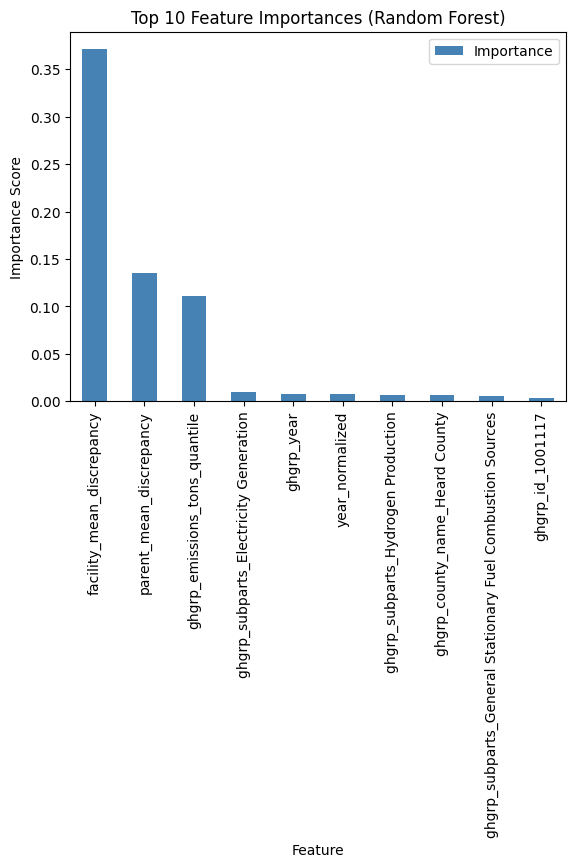

In [ ]:
# Inspect Feature Importances
importances = best_rf.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
top_features = list(zip(feature_names[sorted_idx], importances[sorted_idx]))

print("\nTop 10 Feature Importances:")
for feat, imp in top_features[:10]:
    print(f"{feat}: {imp:.4f}")

# Plot Feature Importances
plt.figure(figsize=(10, 6))

# Create a DataFrame for plotting
top_features_df = pd.DataFrame(top_features[:10], columns=['Feature', 'Importance'])

# Plot using the DataFrame
top_features_df.plot(x='Feature', y='Importance', kind='bar', color='steelblue')

plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

Permutation importance results found. Loading from file...
Permutation importance results successfully loaded.

Top 10 Features Based on Permutation Importance:
                                Feature  Mean Importance   Std Dev
4             facility_mean_discrepancy         0.491156  0.008266
2         ghgrp_emissions_tons_quantile         0.099440  0.001633
3               parent_mean_discrepancy         0.058771  0.001459
1                       year_normalized         0.009272  0.000895
3943                   ghgrp_id_1001117         0.008789  0.000384
0                            ghgrp_year         0.008042  0.000806
283   ghgrp_county_name_Escambia County         0.004245  0.000355
373      ghgrp_county_name_Heard County         0.003766  0.000423
6348                   ghgrp_id_1007959         0.003226  0.000194
970   ghgrp_county_name_Woodbury County         0.003206  0.000215


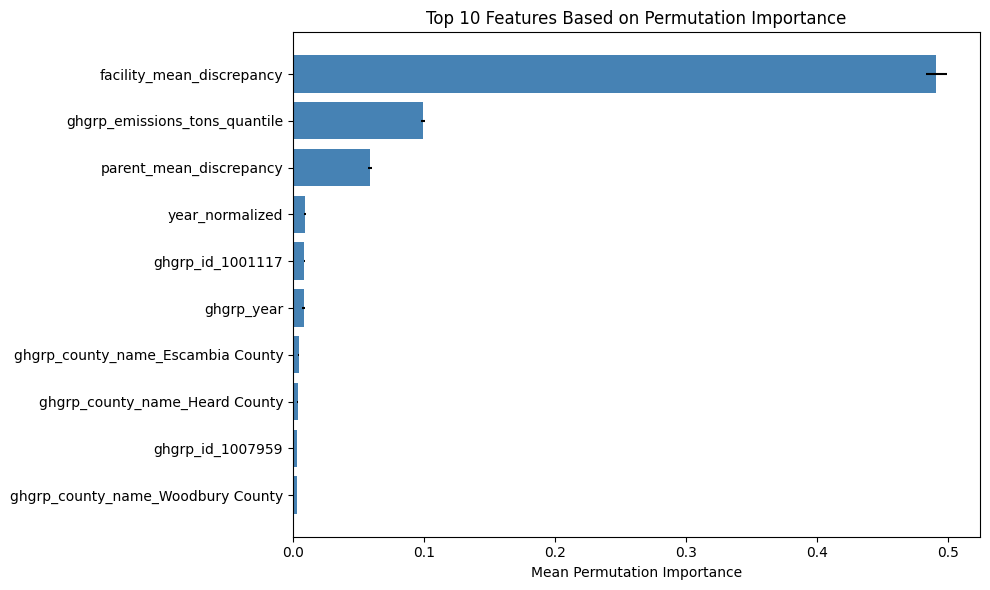

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Path to save/load permutation importance results
perm_importance_path = "/content/drive/MyDrive/Master_Thesis/perm_importance_results.pkl"

# Ensure X_test is a DataFrame and aligned with X_train
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=X_train.columns)  # Convert to DataFrame

# Ensure X_test has the same columns as X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Check if pickle file exists
if os.path.exists(perm_importance_path):
    print("Permutation importance results found. Loading from file...")
    with open(perm_importance_path, "rb") as file:
        perm_importance = pickle.load(file)
    print("Permutation importance results successfully loaded.")
else:
    print("Permutation importance results not found. Calculating Permutation Importance...")

    # Ensure consistent sampling for X_test and y_test
    sample_size = min(5000, len(X_test))  # Use 5,000 samples or the entire dataset if smaller
    sampled_indices = X_test.sample(n=sample_size, random_state=42).index  # Get sampled indices
    X_test_small = X_test.loc[sampled_indices]  # Subset X_test
    y_test_small = y_test.loc[sampled_indices]  # Subset y_test using the same indices

    perm_importance = permutation_importance(
        best_rf,
        X_test_small,
        y_test_small,
        scoring='r2',
        n_repeats=5,
        random_state=42,
        n_jobs=1  # Use single-threaded computation to avoid memory issues
    )

    # Save results to file
    with open(perm_importance_path, "wb") as file:
        pickle.dump(perm_importance, file)
    print(f"Permutation importance results saved to: {perm_importance_path}")

# Convert the permutation importance results to a DataFrame
perm_importance_df = pd.DataFrame({
    "Feature": X_train.columns,  # Use X_train.columns to ensure alignment
    "Mean Importance": perm_importance.importances_mean,
    "Std Dev": perm_importance.importances_std
}).sort_values(by="Mean Importance", ascending=False)

# Display the top 10 features
print("\nTop 10 Features Based on Permutation Importance:")
print(perm_importance_df.head(10))

# Plot the top 10 permutation importances
plt.figure(figsize=(10, 6))
top_perm_features = perm_importance_df.head(10)
plt.barh(
    top_perm_features["Feature"],
    top_perm_features["Mean Importance"],
    xerr=top_perm_features["Std Dev"],
    color="steelblue"
)
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.xlabel("Mean Permutation Importance")
plt.title("Top 10 Features Based on Permutation Importance")
plt.tight_layout()
plt.show()

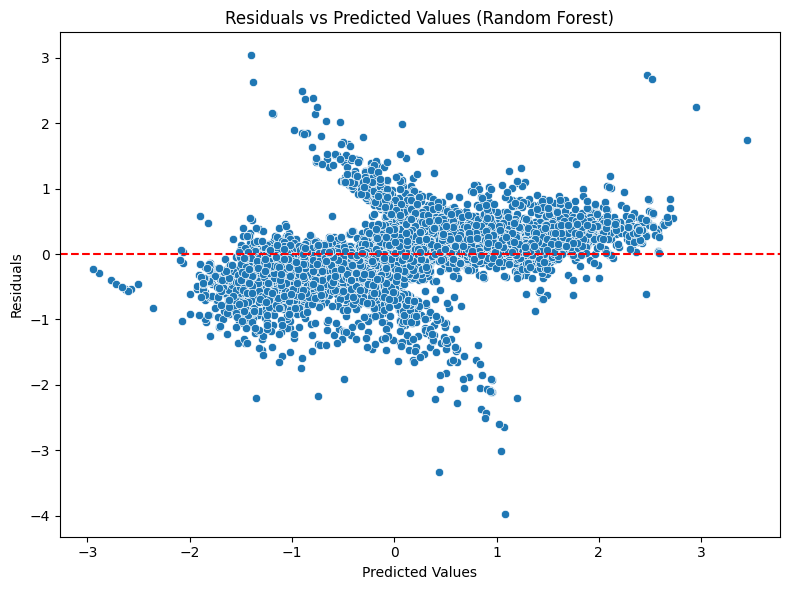

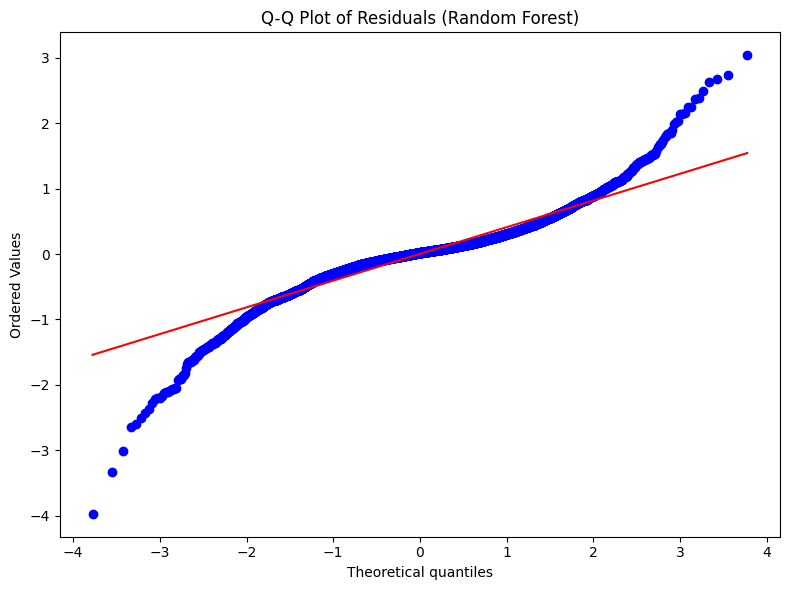

In [ ]:
# Residual Analysis
residuals = y_test - y_pred_test

# Residuals vs Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values (Random Forest)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Q-Q Plot of Residuals
from scipy.stats import probplot

plt.figure(figsize=(8, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Random Forest)")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pickle
from sklearn.preprocessing import QuantileTransformer

# Path to save/load out-of-facility CV results
out_of_facility_results_path = "/content/drive/MyDrive/Master_Thesis/out_of_facility_results.pkl"

if os.path.exists(out_of_facility_results_path):
    print("Out-of-facility CV results found. Loading from file...")
    with open(out_of_facility_results_path, "rb") as file:
        out_of_facility_scores = pickle.load(file)
    print("Out-of-facility CV results successfully loaded.")
else:
    print("Out-of-facility CV results not found. Running evaluation...")

    facilities = df['ghgrp_id'].unique()
    test_facilities = np.random.choice(facilities, size=int(len(facilities) * 0.2), replace=False)

    train_df = df[~df['ghgrp_id'].isin(test_facilities)]
    test_df = df[df['ghgrp_id'].isin(test_facilities)]

    # Apply Quantile Transformation to dependent and explanatory variables
    qt = QuantileTransformer(output_distribution='normal', random_state=42)

    # Select only numeric features for transformation
    numeric_features = train_df.drop('emissions_discrepancy', axis=1).select_dtypes(include=np.number).columns

    X_train = qt.fit_transform(train_df[numeric_features])  # Apply qt.fit_transform to numeric features only
    X_test = qt.transform(test_df[numeric_features])  # Apply qt.transform to numeric features only
    y_train = qt.fit_transform(train_df[['emissions_discrepancy']])
    y_test = qt.transform(test_df[['emissions_discrepancy']])

    # Train model on training set
    best_rf.fit(X_train, y_train.ravel())

    # Test model on test set
    y_pred = best_rf.predict(X_test)

    # Evaluate metrics
    r2_out_of_facility = r2_score(y_test, y_pred)
    rmse_out_of_facility = np.sqrt(mean_squared_error(y_test, y_pred))

    out_of_facility_scores = {
        "R²": r2_out_of_facility,
        "RMSE": rmse_out_of_facility
    }

    # Save results to file
    with open(out_of_facility_results_path, "wb") as file:
        pickle.dump(out_of_facility_scores, file)
    print(f"Out-of-facility results saved to: {out_of_facility_results_path}")

# Display results
print("\nOut-of-Facility Evaluation Results:")
print(out_of_facility_scores)

Out-of-facility CV results found. Loading from file...
Out-of-facility CV results successfully loaded.

Out-of-Facility Evaluation Results:
{'R²': 0.9991621835272425, 'RMSE': 0.030090535262857133}


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pickle
from sklearn.preprocessing import QuantileTransformer

# Path to save/load out-of-time test results
out_of_time_results_path = "/content/drive/MyDrive/Master_Thesis/out_of_time_results.pkl"

if os.path.exists(out_of_time_results_path):
    print("Out-of-time test results found. Loading from file...")
    with open(out_of_time_results_path, "rb") as file:
        out_of_time_scores = pickle.load(file)
    print("Out-of-time test results successfully loaded.")
else:
    print("Out-of-time test results not found. Running evaluation...")

    # Split the data based on time (e.g., using ghgrp_year)
    last_year = df['ghgrp_year'].max()
    split_year = last_year - 1  # Last year for training, earlier years for test
    train_df = df[df['ghgrp_year'] <= split_year]
    test_df = df[df['ghgrp_year'] > split_year]

    # Quantile Transformation for dependent and explanatory variables
    qt = QuantileTransformer(output_distribution='normal', random_state=42)

    # Apply transformation to training and testing data
    numeric_features = train_df.drop('emissions_discrepancy', axis=1).select_dtypes(include=np.number).columns

    X_train = qt.fit_transform(train_df[numeric_features])
    X_test = qt.transform(test_df[numeric_features])
    y_train = qt.fit_transform(train_df[['emissions_discrepancy']])
    y_test = qt.transform(test_df[['emissions_discrepancy']])

    # Train the model on the training set
    best_rf.fit(X_train, y_train.ravel())

    # Test the model on the test set
    y_pred = best_rf.predict(X_test)

    # Evaluate metrics
    r2_out_of_time = r2_score(y_test, y_pred)
    rmse_out_of_time = np.sqrt(mean_squared_error(y_test, y_pred))

    out_of_time_scores = {
        "R²": r2_out_of_time,
        "RMSE": rmse_out_of_time
    }

    # Save the results to a file
    with open(out_of_time_results_path, "wb") as file:
        pickle.dump(out_of_time_scores, file)
    print(f"Out-of-time results saved to: {out_of_time_results_path}")

# Display results
print("\nOut-of-Time Evaluation Results:")
print(out_of_time_scores)

Out-of-time test results found. Loading from file...
Out-of-time test results successfully loaded.

Out-of-Time Evaluation Results:
{'R²': 0.9981843900802152, 'RMSE': 0.04624959964270817}


Bootstrap results not found. Running bootstrap analysis...


Bootstrapping Group Importances: 100%|██████████| 100/100 [1:44:10<00:00, 62.50s/it]


Bootstrap results saved to: /content/drive/MyDrive/Master_Thesis/group_importances_bootstrap.pkl

Group-Level Importance Summary:
                             Mean Importance  Lower CI (2.5%)  \
ghgrp_id                            0.160405         0.154473   
ghgrp_county_name                   0.095290         0.091705   
ghgrp_parent_companies              0.088727         0.084510   
ghgrp_subparts                      0.040617         0.037975   
ghgrp_year                          0.008301         0.007471   
ghgrp_emissions_tons_boxcox         0.000000         0.000000   

                             Upper CI (97.5%)  
ghgrp_id                             0.165735  
ghgrp_county_name                    0.099018  
ghgrp_parent_companies               0.092845  
ghgrp_subparts                       0.043118  
ghgrp_year                           0.008950  
ghgrp_emissions_tons_boxcox          0.000000  


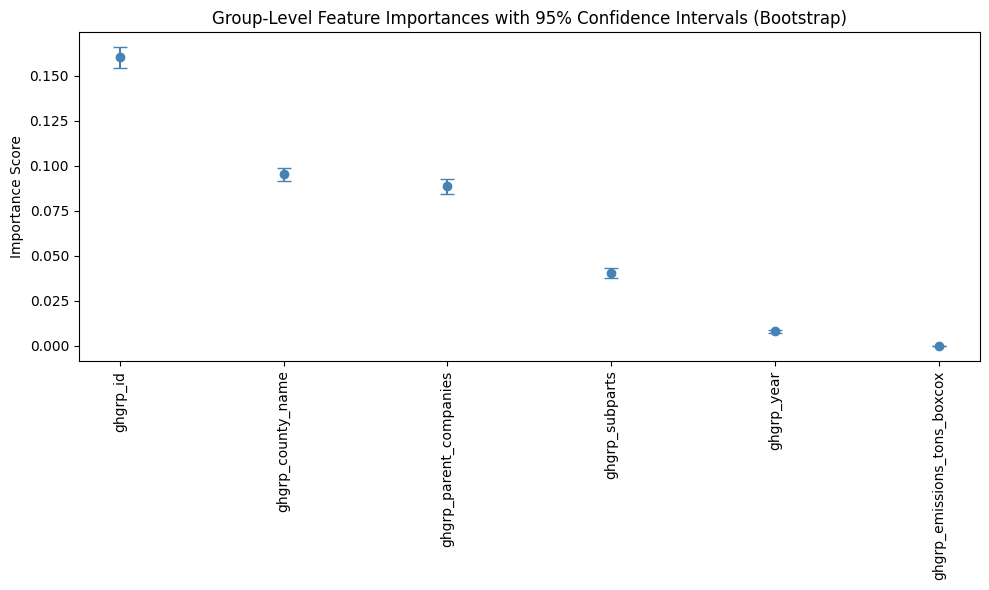

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt

# Path to save/load bootstrap results
bootstrap_results_path = "/content/drive/MyDrive/Master_Thesis/group_importances_bootstrap.pkl"

# Ensure X_train is a DataFrame and aligned with X
if not isinstance(X_train, pd.DataFrame):
    # Convert X_train to a DataFrame using the columns of X
    X_train = pd.DataFrame(X_train, columns=X.columns)

# Apply Quantile Transformation only to numeric columns
qt = QuantileTransformer(output_distribution="normal", random_state=42)
numeric_columns = X_train.select_dtypes(include=np.number).columns
X_train_transformed = X_train.copy()  # Copy original structure

X_train_transformed[numeric_columns] = qt.fit_transform(X_train[numeric_columns])  # Transform numeric columns

# Ensure the predictor groups are correctly defined
predictor_groups = {
    "ghgrp_year": [col for col in X_train.columns if col.startswith("ghgrp_year")],
    "ghgrp_emissions_tons_boxcox": [col for col in X_train.columns if "ghgrp_emissions_tons_boxcox" in col],
    "ghgrp_county_name": [col for col in X_train.columns if col.startswith("ghgrp_county_name")],
    "ghgrp_parent_companies": [col for col in X_train.columns if col.startswith("ghgrp_parent_companies")],
    "ghgrp_subparts": [col for col in X_train.columns if col.startswith("ghgrp_subparts")],
    "ghgrp_id": [col for col in X_train.columns if col.startswith("ghgrp_id")],
}

# Check if bootstrap results already exist
if os.path.exists(bootstrap_results_path):
    print("Bootstrap results found. Loading from file...")
    with open(bootstrap_results_path, "rb") as file:
        group_importances_bootstrap, group_importances_summary = pickle.load(file)
    print("Bootstrap results successfully loaded.")
else:
    print("Bootstrap results not found. Running bootstrap analysis...")

    n_bootstraps = 100
    group_importances_bootstrap = pd.DataFrame(index=predictor_groups.keys())

    # Add progress bar
    for i in tqdm(range(n_bootstraps), desc="Bootstrapping Group Importances"):
        # Resample data for bootstrapping
        X_resampled, y_resampled = resample(X_train_transformed, y_train, random_state=i)

        # Train a Random Forest model on resampled data
        rf_bootstrap = RandomForestRegressor(
            n_estimators=best_rf.n_estimators,
            max_features=best_rf.max_features,
            max_depth=best_rf.max_depth,
            min_samples_split=best_rf.min_samples_split,
            min_samples_leaf=best_rf.min_samples_leaf,
            bootstrap=best_rf.bootstrap,
            random_state=i,
            n_jobs=-1,
        )
        rf_bootstrap.fit(X_resampled, y_resampled)

        # Calculate feature importances
        feature_importances = pd.Series(rf_bootstrap.feature_importances_, index=X_train_transformed.columns)

        # Aggregate feature importances by groups
        group_importances = {}
        for group, cols in predictor_groups.items():
            valid_cols = [col for col in cols if col in feature_importances.index]
            group_importances[group] = feature_importances[valid_cols].sum()

        group_importances_bootstrap[i] = pd.Series(group_importances)

    # Calculate mean importance and 95% confidence intervals
    group_importances_summary = pd.DataFrame({
        "Mean Importance": group_importances_bootstrap.mean(axis=1),
        "Lower CI (2.5%)": group_importances_bootstrap.quantile(0.025, axis=1),
        "Upper CI (97.5%)": group_importances_bootstrap.quantile(0.975, axis=1),
    }).sort_values(by="Mean Importance", ascending=False)

    # Save results to file
    with open(bootstrap_results_path, "wb") as file:
        pickle.dump((group_importances_bootstrap, group_importances_summary), file)
    print(f"Bootstrap results saved to: {bootstrap_results_path}")

# Display Group-Level Summary
print("\nGroup-Level Importance Summary:")
print(group_importances_summary)

# Plot Group Importances with Confidence Intervals
plt.figure(figsize=(10, 6))
plt.errorbar(
    group_importances_summary.index,
    group_importances_summary["Mean Importance"],
    yerr=[
        group_importances_summary["Mean Importance"] - group_importances_summary["Lower CI (2.5%)"],
        group_importances_summary["Upper CI (97.5%)"] - group_importances_summary["Mean Importance"],
    ],
    fmt="o",
    capsize=5,
    color="steelblue",
)
plt.xticks(rotation=90)
plt.title("Group-Level Feature Importances with 95% Confidence Intervals (Bootstrap)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

Top predictors for Partial Dependence Plots: ['facility_mean_discrepancy', 'parent_mean_discrepancy', 'ghgrp_emissions_tons_quantile']


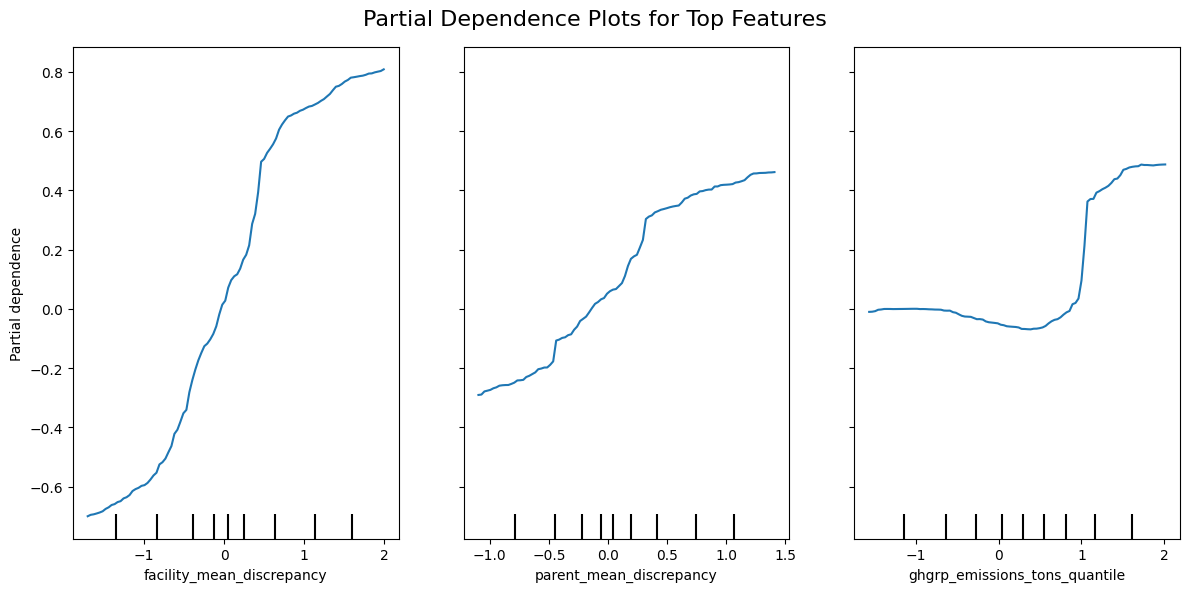

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt

# Ensure 'X_train' has columns for feature names
if not hasattr(X_train, 'columns'):
    raise ValueError("'X_train' must have column names for feature importance mapping.")

# Select top predictors based on Random Forest feature importances
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)
top_features_list = top_features.head(3).index.tolist()

print("Top predictors for Partial Dependence Plots:", top_features_list)

# Partial Dependence Plots
try:
    fig, ax = plt.subplots(figsize=(12, 6))
    PartialDependenceDisplay.from_estimator(
        best_rf, X_test, features=top_features_list, ax=ax
    )
    plt.suptitle("Partial Dependence Plots for Top Features", fontsize=16)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Error generating Partial Dependence Plots:", str(e))

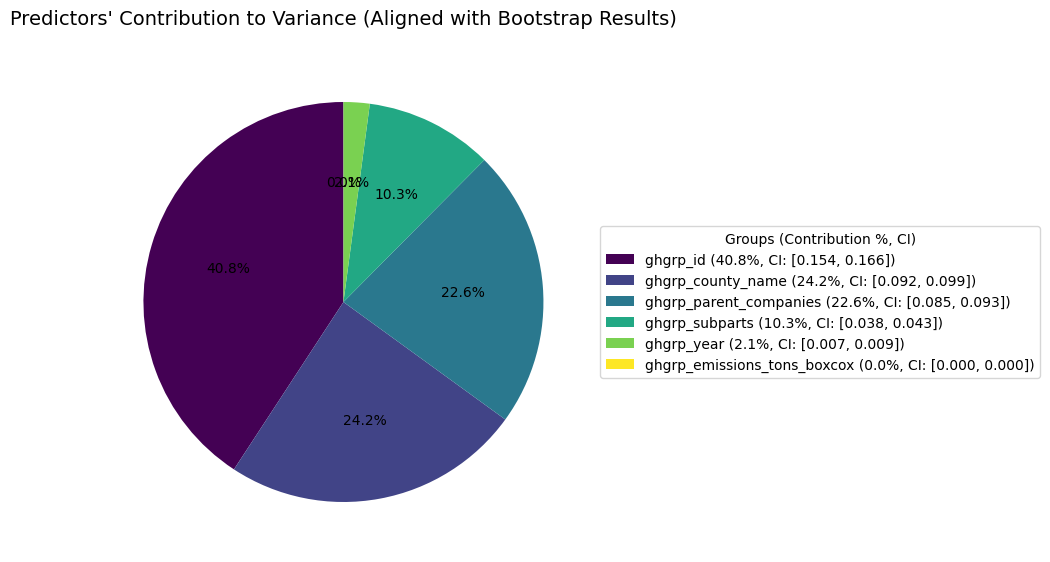

Normalized Group Contributions (as percentages):
                             Mean Importance  Percentage
ghgrp_id                            0.160405   40.780316
ghgrp_county_name                   0.095290   24.225901
ghgrp_parent_companies              0.088727   22.557256
ghgrp_subparts                      0.040617   10.326121
ghgrp_year                          0.008301    2.110407
ghgrp_emissions_tons_boxcox         0.000000    0.000000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize importance values for consistency
group_contributions_df = group_importances_summary.copy()
total_importance = group_contributions_df["Mean Importance"].sum()
group_contributions_df["Percentage"] = (
    group_contributions_df["Mean Importance"] / total_importance * 100
)

# Generate colors for the pie chart
colors = plt.cm.viridis(np.linspace(0, 1, len(group_contributions_df)))

# Plot the pie chart
fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(
    group_contributions_df["Percentage"],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    textprops={"fontsize": 10},
)

# Build labels with percentages and confidence intervals
labels = [
    f"{index} ({row['Percentage']:.1f}%, CI: [{row['Lower CI (2.5%)']:.3f}, {row['Upper CI (97.5%)']:.3f}])"
    for index, row in group_contributions_df.iterrows()
]

# Add legend on the right
ax.legend(
    wedges,
    labels,
    title="Groups (Contribution %, CI)",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    frameon=True,
)

ax.set_aspect("equal")
plt.subplots_adjust(right=0.75)
plt.title("Predictors' Contribution to Variance (Aligned with Bootstrap Results)", fontsize=14, pad=20)
plt.show()

# Display normalized group contributions
print("Normalized Group Contributions (as percentages):")
print(group_contributions_df[["Mean Importance", "Percentage"]])

# Compare models

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import pymc as pm

#---------------------------------------------
# 1) ANOVA (Robust) using simplified_model
#---------------------------------------------
# In-sample predictions for the entire dataset
anova_preds = simplified_model.predict(df)

anova_mse = mean_squared_error(df['emissions_discrepancy_boxcox'], anova_preds)
anova_r2 = r2_score(df['emissions_discrepancy_boxcox'], anova_preds)

#---------------------------------------------
# 2) Elastic Net
#---------------------------------------------
# Test-set predictions
en_preds_test = elastic_net.predict(X_test)
en_mse = mean_squared_error(y_test, en_preds_test)
en_r2 = r2_score(y_test, en_preds_test)

#---------------------------------------------
# 3) Bayesian Model
#---------------------------------------------
# Test-set predictions using posterior predictive sampling
bayesian_posterior_predictive = pm.sample_posterior_predictive(
    trace, model=bayesian_model, var_names=["y_obs"], extend_inferencedata=False
)
bayes_preds_test = bayesian_posterior_predictive["y_obs"].mean(axis=0)

# Compute metrics for test set
bayes_mse_test = mean_squared_error(y_test, bayes_preds_test)
bayes_r2_test = r2_score(y_test, bayes_preds_test)

# In-sample predictions for Bayesian model (entire dataset)
bayes_preds_in_sample = bayesian_posterior_predictive["y_obs"].mean(axis=0)
bayes_mse_in_sample = mean_squared_error(df['emissions_discrepancy_boxcox'], bayes_preds_in_sample)
bayes_r2_in_sample = r2_score(df['emissions_discrepancy_boxcox'], bayes_preds_in_sample)

#---------------------------------------------
# 4) Random Forest
#---------------------------------------------
# Test-set predictions
rf_preds_test = best_rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_preds_test)
rf_r2 = r2_score(y_test, rf_preds_test)

#---------------------------------------------
# Summarize in DataFrames
#---------------------------------------------
# In-sample performance (ANOVA & Bayesian)
perf_in_sample = pd.DataFrame({
    "Model": [
        "ANOVA (robust, in-sample)",
        "Bayesian (in-sample)"
    ],
    "MSE": [anova_mse, bayes_mse_in_sample],
    "R²": [anova_r2, bayes_r2_in_sample]
})

# Test-set performance (Elastic Net, Random Forest, Bayesian)
perf_test = pd.DataFrame({
    "Model": [
        "Elastic Net (test)",
        "Random Forest (test)",
        "Bayesian (test)"
    ],
    "MSE": [en_mse, rf_mse, bayes_mse_test],
    "R²": [en_r2, rf_r2, bayes_r2_test]
})

#---------------------------------------------
# Print Results
#---------------------------------------------
print("=== In-sample Performance (ANOVA & Bayesian) ===")
print(perf_in_sample.to_string(index=False))

print("\n=== Test-set Performance (Elastic Net, Random Forest, Bayesian) ===")
print(perf_test.to_string(index=False))

In [ ]:
### Cell 2: Confidence & Significance

import arviz as az

#---------------------------------------------
# A) ANOVA (Robust Standard Errors)
#---------------------------------------------
print("=== ANOVA (Robust) Summary ===")
anova_summary = simplified_model.summary()
display(anova_summary)  # This includes p-values, robust std. errors, etc.

#---------------------------------------------
# B) Bayesian Model: Posterior Intervals
#---------------------------------------------
print("\n=== Bayesian Credible Intervals ===")
bayes_summary = az.summary(trace, var_names=["beta", "intercept",
                                             "parent_sigma", "facility_sigma",
                                             "year_sigma", "county_sigma",
                                             "subpart_sigma", "sigma"])
display(bayes_summary)

#---------------------------------------------
# C) Elastic Net Coefficients
#---------------------------------------------
# By default, there's no direct p-values or intervals. We can just show coefficients:
import pandas as pd

en_coef_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Coefficient": elastic_net.coef_
}).sort_values("Coefficient", ascending=False)

print("\n=== Elastic Net Coefficients ===")
display(en_coef_df)

#---------------------------------------------
# D) Random Forest Feature Importances
#---------------------------------------------
# RF doesn't give p-values or classical intervals, only importances.
importances = best_rf.feature_importances_
rf_feat_imp_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("\n=== Random Forest Feature Importances ===")
display(rf_feat_imp_df.head(15))

In [ ]:
### Cell 3: How Much Each Model Attributes Variance to Predictors

import statsmodels.api as sm
import numpy as np

#---------------------------------------------
# A) ANOVA partial sums of squares (Type II)
#---------------------------------------------
anova_table = sm.stats.anova_lm(simplified_model, typ=2)
print("=== ANOVA Table (Type II) ===")
display(anova_table)

# If you want partial R² for each factor:
# partial_r2 = SS_factor / (SS_factor + SS_residual)
# You can compute from the columns in anova_table.

#---------------------------------------------
# B) Bayesian random-effect variances
#---------------------------------------------
parent_var   = (trace.posterior['parent_sigma']**2).mean().item()
facility_var = (trace.posterior['facility_sigma']**2).mean().item()
year_var     = (trace.posterior['year_sigma']**2).mean().item()
county_var   = (trace.posterior['county_sigma']**2).mean().item()
subpart_var  = (trace.posterior['subpart_sigma']**2).mean().item()

print("\n=== Bayesian Random-Effect Variances (Posterior Means) ===")
bayes_var_df = pd.DataFrame({
    "Effect": ["Parent", "Facility", "Year", "County", "Subpart"],
    "Posterior_Mean_Var": [parent_var, facility_var, year_var, county_var, subpart_var]
})
display(bayes_var_df)

#---------------------------------------------
# C) Elastic Net: Coefficient Magnitudes
#---------------------------------------------
en_abs_coefs = np.abs(elastic_net.coef_)
en_features  = X_test.columns
en_sorted_idx = np.argsort(en_abs_coefs)[::-1]
en_coef_importance = pd.DataFrame({
    "Feature": en_features[en_sorted_idx],
    "AbsCoef": en_abs_coefs[en_sorted_idx]
})
print("\n=== Elastic Net Feature Importance (|coeff|) ===")
display(en_coef_importance.head(15))

#---------------------------------------------
# D) Random Forest: Feature Importances
#---------------------------------------------
rf_importances_sorted = rf_feat_imp_df.sort_values("Importance", ascending=False)
print("\n=== Random Forest Feature Importances (sorted) ===")
display(rf_importances_sorted.head(15))

# Gradient Boosting Model (LightGBM)

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import pickle
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1) Data Preprocessing
# ------------------------------------------------------------------------------
print("Preprocessing data...")
df = matched_dfs["5m"].copy()

# Apply Quantile Transformation
qt = QuantileTransformer(output_distribution="normal", random_state=42)
df['ghgrp_emissions_tons_quantile'] = qt.fit_transform(df[['ghgrp_emissions_tons']])
df['emissions_discrepancy_quantile'] = qt.fit_transform(df[['emissions_discrepancy']])

# Ensure variables are correct type
df['ghgrp_year'] = df['ghgrp_year'].astype(int)

def process_parent_companies(value):
    if pd.isna(value):
        return ["Other"]
    cleaned_value = re.sub(r'\([^)]*\)', '', str(value))
    return [company.strip() for company in cleaned_value.split(';')]

def process_subparts(value):
    if pd.isna(value):
        return []
    return [subpart.strip() for subpart in str(value).split(',')]

df['ghgrp_parent_companies'] = df['ghgrp_parent_companies'].apply(process_parent_companies)
df['ghgrp_subparts'] = df['ghgrp_subparts'].apply(process_subparts)

# Explode both parent companies and subparts
df = df.explode('ghgrp_parent_companies')
df = df.explode('ghgrp_subparts')

# Convert to categorical
df['ghgrp_parent_companies'] = df['ghgrp_parent_companies'].astype('category')
df['ghgrp_county_name'] = df['ghgrp_county_name'].astype('category')
df['ghgrp_subparts'] = df['ghgrp_subparts'].astype('category')
df['ghgrp_id'] = df['ghgrp_id'].astype('category')

# Aggregate statistics for group-level effects
df['parent_mean_discrepancy'] = df.groupby('ghgrp_parent_companies', observed=True)['emissions_discrepancy_quantile'].transform('mean')
df['facility_mean_discrepancy'] = df.groupby('ghgrp_id', observed=True)['emissions_discrepancy_quantile'].transform('mean')

# Add temporal features
df['year_normalized'] = df['ghgrp_year'] - df['ghgrp_year'].min()

# Create dummy variables for modeling
X = pd.get_dummies(
    df[['ghgrp_year', 'year_normalized', 'ghgrp_emissions_tons_quantile', 'ghgrp_county_name',
        'ghgrp_parent_companies', 'ghgrp_subparts', 'ghgrp_id',
        'parent_mean_discrepancy', 'facility_mean_discrepancy']],
    drop_first=True
)

# Sanitize feature names to remove problematic characters and ensure uniqueness
X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]
X.columns = pd.Index([f"{col}_{i}" if X.columns.duplicated()[i] else col
                      for i, col in enumerate(X.columns)])

y = df['emissions_discrepancy_quantile']

# ------------------------------------------------------------------------------
# 2) Train-Test Split
# ------------------------------------------------------------------------------
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ------------------------------------------------------------------------------
# 3) Hyperparameter Tuning and Training the Model
# ------------------------------------------------------------------------------
print("Training Gradient Boosting Model...")
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [10, 20, 30],
    'num_leaves': [31, 50, 100],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.1, 1.0],
    'reg_lambda': [0.1, 1.0]
}

lgb_model = LGBMRegressor(random_state=42)
random_search = RandomizedSearchCV(
    lgb_model, param_distributions=param_grid, n_iter=50, cv=5,
    scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1
)

# Ensure column alignment for the test set
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Fit the Gradient Boosting Model
random_search.fit(X_train, y_train)
best_lgbm = random_search.best_estimator_

print("\nBest parameters found:")
print(random_search.best_params_)

# Save the model
model_file_path = "/content/drive/MyDrive/Master_Thesis/lgbm_model.pkl"
with open(model_file_path, "wb") as file:
    pickle.dump(best_lgbm, file)

print("Model training complete!")

Preprocessing data...
Splitting data...
Training Gradient Boosting Model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3904
[LightGBM] [Info] Number of data points in the train set: 20321, number of used features: 1566
[LightGBM] [Info] Start training from score 0.100898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [ ]:
# ------------------------------------------------------------------------------
# 4) Evaluate the Model
# ------------------------------------------------------------------------------
print("Evaluating the model...")
y_pred_train = best_lgbm.predict(X_train)
y_pred_test = best_lgbm.predict(X_test)

# Compute metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")

Evaluating the model...
Train RMSE: 0.1228, R²: 0.9890
Test RMSE: 0.2413, R²: 0.9576


Analyzing feature importance...


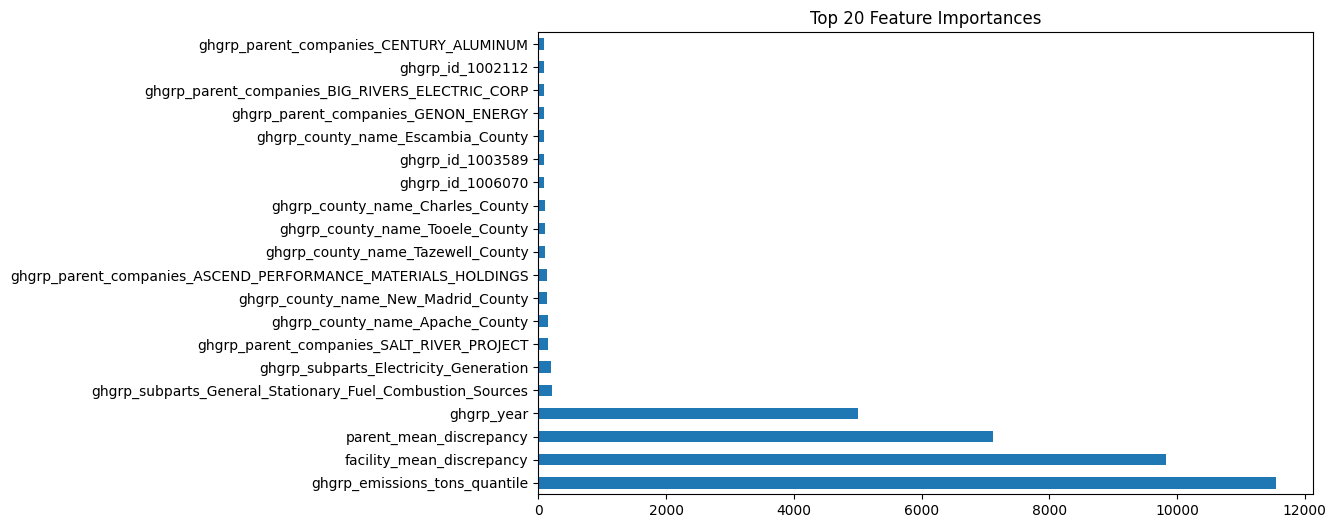

In [ ]:
# ------------------------------------------------------------------------------
# 5) Feature Importance Analysis
# ------------------------------------------------------------------------------
print("Analyzing feature importance...")
feature_importances = pd.Series(best_lgbm.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances[:20].plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()

Performing residual analysis...


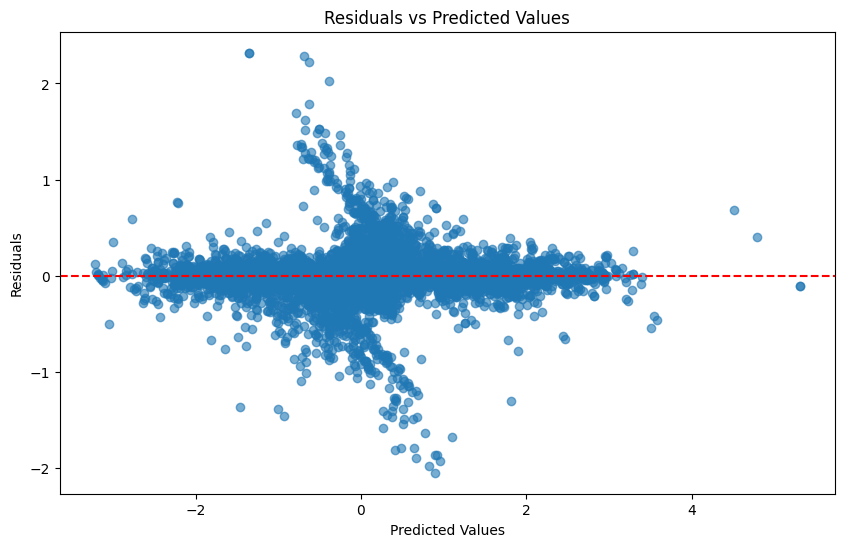

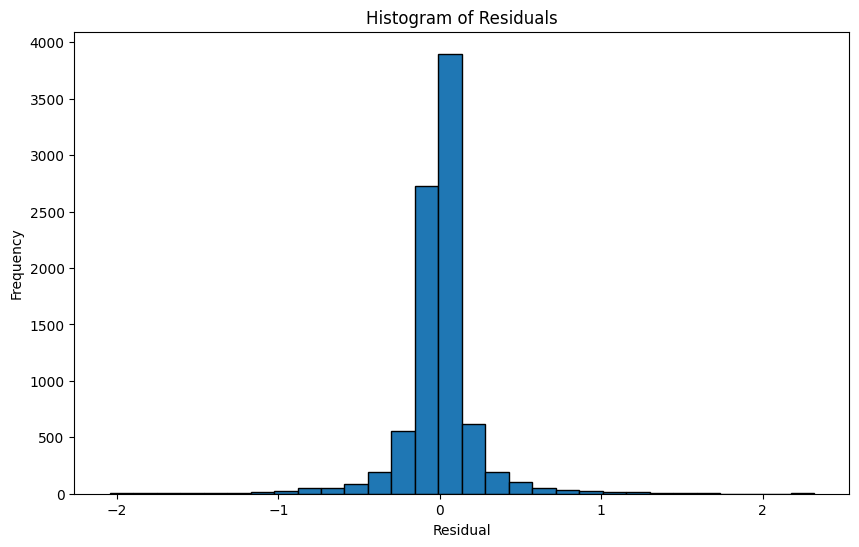

In [ ]:
print("Performing residual analysis...")

# Calculate residuals
residuals = y_test - y_pred_test

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor="k")
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

print("Performing cross-validation evaluation...")
cv_scores = cross_val_score(
    best_lgbm, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1
)
cv_rmse_scores = np.sqrt(-cv_scores)

print(f"Cross-Validation RMSE Scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: {np.mean(cv_rmse_scores):.4f}")
print(f"Std Dev CV RMSE: {np.std(cv_rmse_scores):.4f}")

Performing cross-validation evaluation...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Cross-Validation RMSE Scores: [0.30610163 0.3113333  0.42727721 0.38394013 0.59289819]
Mean CV RMSE: 0.4043
Std Dev CV RMSE: 0.1047
